In [2]:
# --- 1. 安装依赖 ---
!pip install xarray netCDF4 matplotlib geopandas rasterio rioxarray --quiet

# --- 2. 挂载Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 3. 导入库 ---
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. NO2 Year-to-Year Correlation Analysis

🚀 NO2 Year-to-Year Correlation Analysis
📅 NO2 Year-to-Year Correlation Analyzer
📁 File template: /content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_{}.tif
📁 AOI: /content/drive/MyDrive/AOI/delimitazione_distretto.shp
📅 Years: [2019, 2020, 2021, 2022, 2023]
🚀 Starting NO2 Year-to-Year Correlation Analysis

📊 Analyzing 2019...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.469 (46.9%)
   📊 Std missing: 0.092

📊 Analyzing 2020...
   Bands: (366, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.462 (46.2%)
   📊 Std missing: 0.088

📊 Analyzing 2021...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.485 (48.5%)
   📊 Std missing: 0.116

📊 Analyzing 2022...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.413 (41.3%)
   📊 Std missing: 0.101

📊 Analyzing 2023...
   Bands: (365, 300, 621)
✅ AOI m

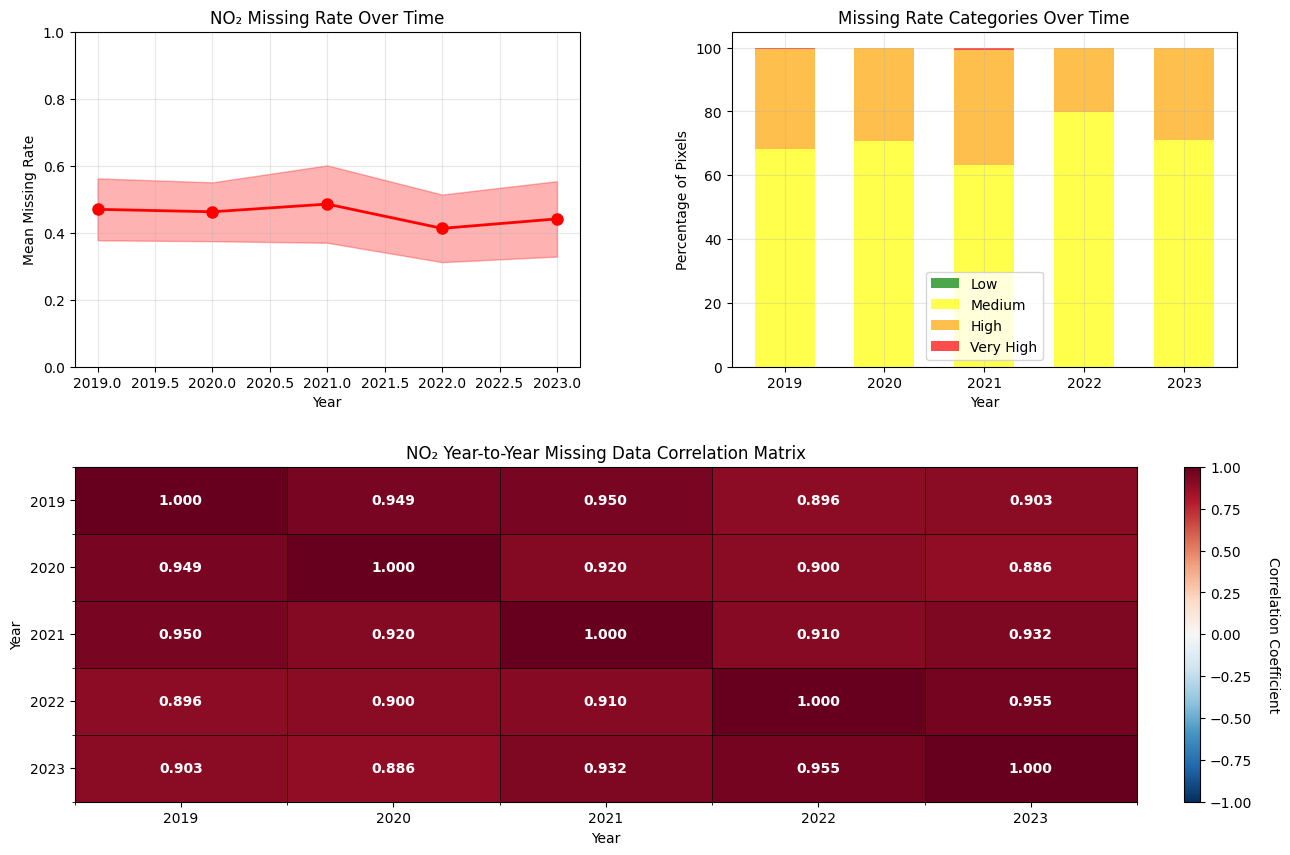


📋 NO2 Year-to-Year Correlation Summary Report

📊 Overall Statistics:
   Years analyzed: 5
   Year range: 2019 - 2023

📅 Yearly Statistics:
   2019:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.469 (46.9%)
     Std missing: 0.092
     P90 missing: 0.608 (60.8%)
   2020:
     Total days: 366
     Valid pixels: 94,666
     Mean missing: 0.462 (46.2%)
     Std missing: 0.088
     P90 missing: 0.593 (59.3%)
   2021:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.485 (48.5%)
     Std missing: 0.116
     P90 missing: 0.666 (66.6%)
   2022:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.413 (41.3%)
     Std missing: 0.101
     P90 missing: 0.573 (57.3%)
   2023:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.441 (44.1%)
     Std missing: 0.113
     P90 missing: 0.611 (61.1%)

🔗 Correlation Analysis:
   Year-to-Year Correlation Matrix:
     Matrix size: 5x5
     Highest correlation: 0.955 (2022 vs 2023)
     

In [ ]:
#!/usr/bin/env python3
"""
NO2 Year-to-Year Correlation Analysis

Based on the user's existing code for missing value analysis,
this script analyzes year-to-year correlations in NO2 missing patterns.
"""

import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import os

class NO2YearToYearCorrelation:
    """Analyze year-to-year correlations in NO2 missing patterns"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.file_template = os.path.join(base_path, "GEE_NO2", "NO2_Daily_Multiband_{}.tif")
        self.aoi_path = os.path.join(base_path, "AOI", "delimitazione_distretto.shp")
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("📅 NO2 Year-to-Year Correlation Analyzer")
        print(f"📁 File template: {self.file_template}")
        print(f"📁 AOI: {self.aoi_path}")
        print(f"📅 Years: {self.years}")

    def load_aoi_mask(self, transform, out_shape):
        """Load AOI mask"""
        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_mask = geometry_mask([aoi.geometry.union_all()],
                                   transform=transform,
                                   invert=True,
                                   out_shape=out_shape)
            print(f"✅ AOI mask loaded: {aoi_mask.shape}")
            return aoi_mask
        except Exception as e:
            print(f"❌ Error loading AOI: {e.g}")
            return None

    def analyze_year_missing_patterns(self, year):
        """Analyze missing patterns for a specific year"""
        print(f"\n📊 Analyzing {year}...")

        file_path = self.file_template.format(year)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return None

        try:
            with rasterio.open(file_path) as src:
                bands = src.read()  # shape: (days, height, width)
                print(f"   Bands: {bands.shape}")

                # 0 or nan is considered missing
                mask = (bands <= 0) | np.isnan(bands)
                yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel
                total_days = bands.shape[0]
                gap_ratio = yearly_gap / total_days   # Missing rate per pixel

                # Get spatial info
                bounds = src.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
                transform = src.transform
                out_shape = (src.height, src.width)

                # Load AOI mask
                aoi_mask = self.load_aoi_mask(transform, out_shape)

                if aoi_mask is not None:
                    # Apply AOI mask to the gap ratio
                    masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

                    # Calculate statistics
                    valid_data = masked_gap_aoi.compressed()

                    if len(valid_data) > 0:
                        year_stats = {
                            'year': year,
                            'total_days': total_days,
                            'valid_pixels': len(valid_data),
                            'mean_missing': np.mean(valid_data),
                            'median_missing': np.median(valid_data),
                            'std_missing': np.std(valid_data),
                            'min_missing': np.min(valid_data),
                            'max_missing': np.max(valid_data),
                            'p90_missing': np.percentile(valid_data, 90),
                            'p95_missing': np.percentile(valid_data, 95),
                            'gap_ratio': gap_ratio,
                            'aoi_mask': aoi_mask,
                            'extent': extent,
                            'transform': transform
                        }

                        # Missing rate categories
                        year_stats['low_missing'] = np.sum(valid_data < 0.2)
                        year_stats['medium_missing'] = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
                        year_stats['high_missing'] = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
                        year_stats['very_high_missing'] = np.sum(valid_data >= 0.8)

                        print(f"   ✅ Valid pixels: {len(valid_data):,}")
                        print(f"   📊 Mean missing: {np.mean(valid_data):.3f} ({np.mean(valid_data)*100:.1f}%)")
                        print(f"   📊 Std missing: {np.std(valid_data):.3f}")

                        return year_stats
                    else:
                        print(f"   ⚠️ No valid data after AOI masking")
                        return None
                else:
                    print(f"   ❌ AOI mask not available")
                    return None

        except Exception as e:
            print(f"   ❌ Error processing {year}: {e}")
            return None

    def calculate_year_to_year_correlations(self, yearly_stats):
        """Calculate year-to-year correlations"""
        print(f"\n🔗 Calculating Year-to-Year Correlations")
        print("=" * 50)

        if len(yearly_stats) < 2:
            print("❌ Need at least 2 years for correlation analysis")
            return None

        # Extract yearly statistics
        years = [stats['year'] for stats in yearly_stats]
        mean_missing = [stats['mean_missing'] for stats in yearly_stats]
        std_missing = [stats['std_missing'] for stats in yearly_stats]
        median_missing = [stats['median_missing'] for stats in yearly_stats]

        # Calculate correlations
        correlations = {}

        # Create year-to-year correlation matrix
        n_years = len(years)
        correlation_matrix = np.ones((n_years, n_years))  # Initialize with 1s on diagonal

        print(f"📊 Year-to-Year Correlation Matrix:")
        print(f"   Calculating correlations between {n_years} years...")

        # Calculate pairwise correlations
        for i in range(n_years):
            for j in range(i+1, n_years):
                year_i, year_j = years[i], years[j]

                # Get gap ratios for both years
                gap_ratio_i = yearly_stats[i]['gap_ratio']
                gap_ratio_j = yearly_stats[j]['gap_ratio']
                aoi_mask_i = yearly_stats[i]['aoi_mask']
                aoi_mask_j = yearly_stats[j]['aoi_mask']

                # Apply AOI masks
                masked_i = ma.masked_where(~aoi_mask_i, gap_ratio_i)
                masked_j = ma.masked_where(~aoi_mask_j, gap_ratio_j)

                # Get valid data (where both years have valid data)
                valid_mask = ~(masked_i.mask | masked_j.mask)
                if np.sum(valid_mask) > 100:  # Need sufficient data points
                    valid_data_i = masked_i[valid_mask].compressed()
                    valid_data_j = masked_j[valid_mask].compressed()

                    # Calculate correlation
                    if len(valid_data_i) > 0 and len(valid_data_j) > 0:
                        corr_coef, p_value = pearsonr(valid_data_i, valid_data_j)
                        correlation_matrix[i, j] = corr_coef
                        correlation_matrix[j, i] = corr_coef  # Symmetric matrix

                        print(f"   {year_i} vs {year_j}: r={corr_coef:.3f} (n={len(valid_data_i)})")
                    else:
                        print(f"   {year_i} vs {year_j}: No valid data")
                        correlation_matrix[i, j] = np.nan
                        correlation_matrix[j, i] = np.nan
                else:
                    print(f"   {year_i} vs {year_j}: Insufficient overlap")
                    correlation_matrix[i, j] = np.nan
                    correlation_matrix[j, i] = np.nan

        correlations['correlation_matrix'] = correlation_matrix
        correlations['years'] = years

        # Time trend correlation (year vs missing rate)
        if len(years) >= 2:
            pearson_r, pearson_p = pearsonr(years, mean_missing)
            spearman_r, spearman_p = spearmanr(years, mean_missing)

            correlations['time_trend'] = {
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'trend': 'increasing' if pearson_r > 0 else 'decreasing',
                'significance': 'significant' if pearson_p < 0.05 else 'not_significant'
            }

            print(f"\n📈 Time Trend Correlation:")
            print(f"   Pearson r: {pearson_r:.3f} (p={pearson_p:.3f})")
            print(f"   Spearman r: {spearman_r:.3f} (p={spearman_p:.3f})")
            print(f"   Trend: {'Increasing' if pearson_r > 0 else 'Decreasing'}")
            print(f"   Significance: {'Significant' if pearson_p < 0.05 else 'Not significant'}")

        # Year-to-year variability
        if len(mean_missing) >= 2:
            year_to_year_changes = np.diff(mean_missing)
            correlations['year_to_year_variability'] = {
                'changes': year_to_year_changes,
                'mean_change': np.mean(year_to_year_changes),
                'std_change': np.std(year_to_year_changes),
                'max_increase': np.max(year_to_year_changes),
                'max_decrease': np.min(year_to_year_changes)
            }

            print(f"\n📊 Year-to-Year Variability:")
            print(f"   Mean change: {np.mean(year_to_year_changes):.3f}")
            print(f"   Std change: {np.std(year_to_year_changes):.3f}")
            print(f"   Max increase: {np.max(year_to_year_changes):.3f}")
            print(f"   Max decrease: {np.min(year_to_year_changes):.3f}")

        return correlations

    def create_summary_visualization(self, yearly_stats, correlations):
        """Create summary visualization"""
        print(f"\n📊 Creating Summary Visualization")
        print("=" * 40)

        if not yearly_stats:
            print("❌ No data for visualization")
            return

        # Extract data for plotting
        years = [stats['year'] for stats in yearly_stats]
        mean_missing = [stats['mean_missing'] for stats in yearly_stats]
        std_missing = [stats['std_missing'] for stats in yearly_stats]

        # Create figure with subplots - simplified layout
        fig = plt.figure(figsize=(15, 10))

        # Create subplot layout - 2x2 grid
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        ax1 = fig.add_subplot(gs[0, 0])  # Time series
        ax2 = fig.add_subplot(gs[0, 1])  # Categories
        ax3 = fig.add_subplot(gs[1, :])  # Correlation matrix heatmap (spans full width)

        # Plot 1: Mean missing rate over time
        ax1.plot(years, mean_missing, 'o-', linewidth=2, markersize=8, color='red')
        ax1.fill_between(years,
                        np.array(mean_missing) - np.array(std_missing),
                        np.array(mean_missing) + np.array(std_missing),
                        alpha=0.3, color='red')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Mean Missing Rate')
        ax1.set_title('NO₂ Missing Rate Over Time')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)

        # Add trend line if correlation exists
        if correlations and 'time_trend' in correlations:
            trend = correlations['time_trend']
            if trend['significance'] == 'significant':
                ax1.text(0.05, 0.95, f"Trend: {trend['trend']}\n(r={trend['pearson_r']:.3f}, p={trend['pearson_p']:.3f})",
                        transform=ax1.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # Plot 2: Missing rate categories over time
        categories = ['Low (<20%)', 'Medium (20-50%)', 'High (50-80%)', 'Very High (≥80%)']
        low_pct = [stats['low_missing']/stats['valid_pixels']*100 for stats in yearly_stats]
        medium_pct = [stats['medium_missing']/stats['valid_pixels']*100 for stats in yearly_stats]
        high_pct = [stats['high_missing']/stats['valid_pixels']*100 for stats in yearly_stats]
        very_high_pct = [stats['very_high_missing']/stats['valid_pixels']*100 for stats in yearly_stats]

        width = 0.6
        x = np.arange(len(years))

        ax2.bar(x, low_pct, width, label='Low', color='green', alpha=0.7)
        ax2.bar(x, medium_pct, width, bottom=low_pct, label='Medium', color='yellow', alpha=0.7)
        ax2.bar(x, high_pct, width, bottom=np.array(low_pct)+np.array(medium_pct),
                label='High', color='orange', alpha=0.7)
        ax2.bar(x, very_high_pct, width,
                bottom=np.array(low_pct)+np.array(medium_pct)+np.array(high_pct),
                label='Very High', color='red', alpha=0.7)

        ax2.set_xlabel('Year')
        ax2.set_ylabel('Percentage of Pixels')
        ax2.set_title('Missing Rate Categories Over Time')
        ax2.set_xticks(x)
        ax2.set_xticklabels(years)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Year-to-Year Correlation Matrix Heatmap
        if correlations and 'correlation_matrix' in correlations:
            corr_matrix = correlations['correlation_matrix']
            corr_years = correlations['years']

            # Create heatmap
            im = ax3.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

            # Set ticks and labels
            ax3.set_xticks(range(len(corr_years)))
            ax3.set_yticks(range(len(corr_years)))
            ax3.set_xticklabels(corr_years)
            ax3.set_yticklabels(corr_years)

            # Add correlation values as text
            for i in range(len(corr_years)):
                for j in range(len(corr_years)):
                    if not np.isnan(corr_matrix[i, j]):
                        text_color = 'white' if abs(corr_matrix[i, j]) > 0.5 else 'black'
                        ax3.text(j, i, f'{corr_matrix[i, j]:.3f}',
                                ha='center', va='center', color=text_color, fontweight='bold')
                    else:
                        ax3.text(j, i, 'N/A', ha='center', va='center', color='gray')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
            cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

            ax3.set_title('NO₂ Year-to-Year Missing Data Correlation Matrix')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Year')

            # Add grid
            ax3.set_xticks(np.arange(-0.5, len(corr_years), 1), minor=True)
            ax3.set_yticks(np.arange(-0.5, len(corr_years), 1), minor=True)
            ax3.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

        plt.tight_layout()

        # Save figure
        output_path = 'NO2_Year_to_Year_Correlation_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Figure saved: {output_path}")

        plt.show()

    def generate_summary_report(self, yearly_stats, correlations):
        """Generate summary report"""
        print(f"\n📋 NO2 Year-to-Year Correlation Summary Report")
        print("=" * 60)

        if not yearly_stats:
            print("❌ No data available for summary")
            return

        # Overall statistics
        print(f"\n📊 Overall Statistics:")
        print(f"   Years analyzed: {len(yearly_stats)}")
        print(f"   Year range: {min([s['year'] for s in yearly_stats])} - {max([s['year'] for s in yearly_stats])}")

        # Yearly statistics
        print(f"\n📅 Yearly Statistics:")
        for stats in yearly_stats:
            print(f"   {stats['year']}:")
            print(f"     Total days: {stats['total_days']}")
            print(f"     Valid pixels: {stats['valid_pixels']:,}")
            print(f"     Mean missing: {stats['mean_missing']:.3f} ({stats['mean_missing']*100:.1f}%)")
            print(f"     Std missing: {stats['std_missing']:.3f}")
            print(f"     P90 missing: {stats['p90_missing']:.3f} ({stats['p90_missing']*100:.1f}%)")

        # Correlation results
        if correlations:
            print(f"\n🔗 Correlation Analysis:")

            # Year-to-year correlation matrix summary
            if 'correlation_matrix' in correlations:
                corr_matrix = correlations['correlation_matrix']
                corr_years = correlations['years']

                print(f"   Year-to-Year Correlation Matrix:")
                print(f"     Matrix size: {corr_matrix.shape[0]}x{corr_matrix.shape[1]}")

                # Find highest and lowest correlations (excluding diagonal)
                off_diagonal = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
                valid_corrs = off_diagonal[~np.isnan(off_diagonal)]

                if len(valid_corrs) > 0:
                    max_corr_idx = np.argmax(valid_corrs)
                    min_corr_idx = np.argmin(valid_corrs)

                    # Find which years these correspond to
                    triu_indices = np.triu_indices_from(corr_matrix, k=1)
                    max_corr_years = (corr_years[triu_indices[0][max_corr_idx]],
                                    corr_years[triu_indices[1][max_corr_idx]])
                    min_corr_years = (corr_years[triu_indices[0][min_corr_idx]],
                                    corr_years[triu_indices[1][min_corr_idx]])

                    print(f"     Highest correlation: {valid_corrs[max_corr_idx]:.3f} ({max_corr_years[0]} vs {max_corr_years[1]})")
                    print(f"     Lowest correlation: {valid_corrs[min_corr_idx]:.3f} ({min_corr_years[0]} vs {min_corr_years[1]})")
                    print(f"     Average correlation: {np.mean(valid_corrs):.3f}")
                    print(f"     Std correlation: {np.std(valid_corrs):.3f}")

                # Print correlation matrix as table
                print(f"\n     Correlation Matrix:")
                print(f"     {'Year':>6}", end="")
                for year in corr_years:
                    print(f"{year:>8}", end="")
                print()

                for i, year in enumerate(corr_years):
                    print(f"     {year:>6}", end="")
                    for j in range(len(corr_years)):
                        if not np.isnan(corr_matrix[i, j]):
                            print(f"{corr_matrix[i, j]:>8.3f}", end="")
                        else:
                            print(f"{'N/A':>8}", end="")
                    print()

            if 'time_trend' in correlations:
                trend = correlations['time_trend']
                print(f"\n   Time trend: {trend['trend']}")
                print(f"   Pearson correlation: {trend['pearson_r']:.3f} (p={trend['pearson_p']:.3f})")
                print(f"   Spearman correlation: {trend['spearman_r']:.3f} (p={trend['spearman_p']:.3f})")
                print(f"   Significance: {trend['significance']}")

            if 'year_to_year_variability' in correlations:
                var = correlations['year_to_year_variability']
                print(f"\n   Year-to-year variability:")
                print(f"     Mean change: {var['mean_change']:.3f}")
                print(f"     Std change: {var['std_change']:.3f}")
                print(f"     Max increase: {var['max_increase']:.3f}")
                print(f"     Max decrease: {var['max_decrease']:.3f}")

        # Recommendations
        print(f"\n💡 Recommendations:")
        if correlations and 'time_trend' in correlations:
            trend = correlations['time_trend']
            if trend['significance'] == 'significant':
                if trend['trend'] == 'increasing':
                    print("   ⚠️ Missing data is increasing over time - investigate causes")
                else:
                    print("   ✅ Missing data is decreasing over time - good trend")
            else:
                print("   📊 No significant time trend in missing data")

        print("   🔄 Consider seasonal analysis for more detailed patterns")
        print("   📈 Monitor year-to-year changes for data quality assessment")
        print("   🎯 Use findings to improve gap-filling strategies")

    def run_analysis(self):
        """Run complete year-to-year correlation analysis"""
        print("🚀 Starting NO2 Year-to-Year Correlation Analysis")
        print("=" * 60)

        # Analyze each year
        yearly_stats = []
        for year in self.years:
            stats = self.analyze_year_missing_patterns(year)
            if stats:
                yearly_stats.append(stats)

        if not yearly_stats:
            print("❌ No valid data found for any year")
            return None

        # Calculate correlations
        correlations = self.calculate_year_to_year_correlations(yearly_stats)

        # Create visualization
        self.create_summary_visualization(yearly_stats, correlations)

        # Generate report
        self.generate_summary_report(yearly_stats, correlations)

        print(f"\n🎉 Analysis completed!")
        return {
            'yearly_stats': yearly_stats,
            'correlations': correlations
        }


def main():
    """Main function"""
    print("🚀 NO2 Year-to-Year Correlation Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = NO2YearToYearCorrelation()

    # Run analysis
    results = analyzer.run_analysis()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualization saved as PNG file")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()


🚀 NO2 Pixel-wise Temporal Trend Analysis
📅 NO2 Pixel-wise Temporal Trend Analyzer
 File template: /content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_{}.tif
 AOI: /content/drive/MyDrive/AOI/delimitazione_distretto.shp
📅 Years: [2019, 2020, 2021, 2022, 2023]
🚀 Starting NO2 Pixel-wise Temporal Trend Analysis

 Analyzing 2019...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.469 (46.9%)
   📊 Std missing: 0.092

 Analyzing 2020...
   Bands: (366, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.462 (46.2%)
   📊 Std missing: 0.088

 Analyzing 2021...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.485 (48.5%)
   📊 Std missing: 0.116

 Analyzing 2022...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.413 (41.3%)
   📊 Std missing: 0.101

 Analyzing 2023...
   Bands: (365, 300, 621)
✅ AOI mask load

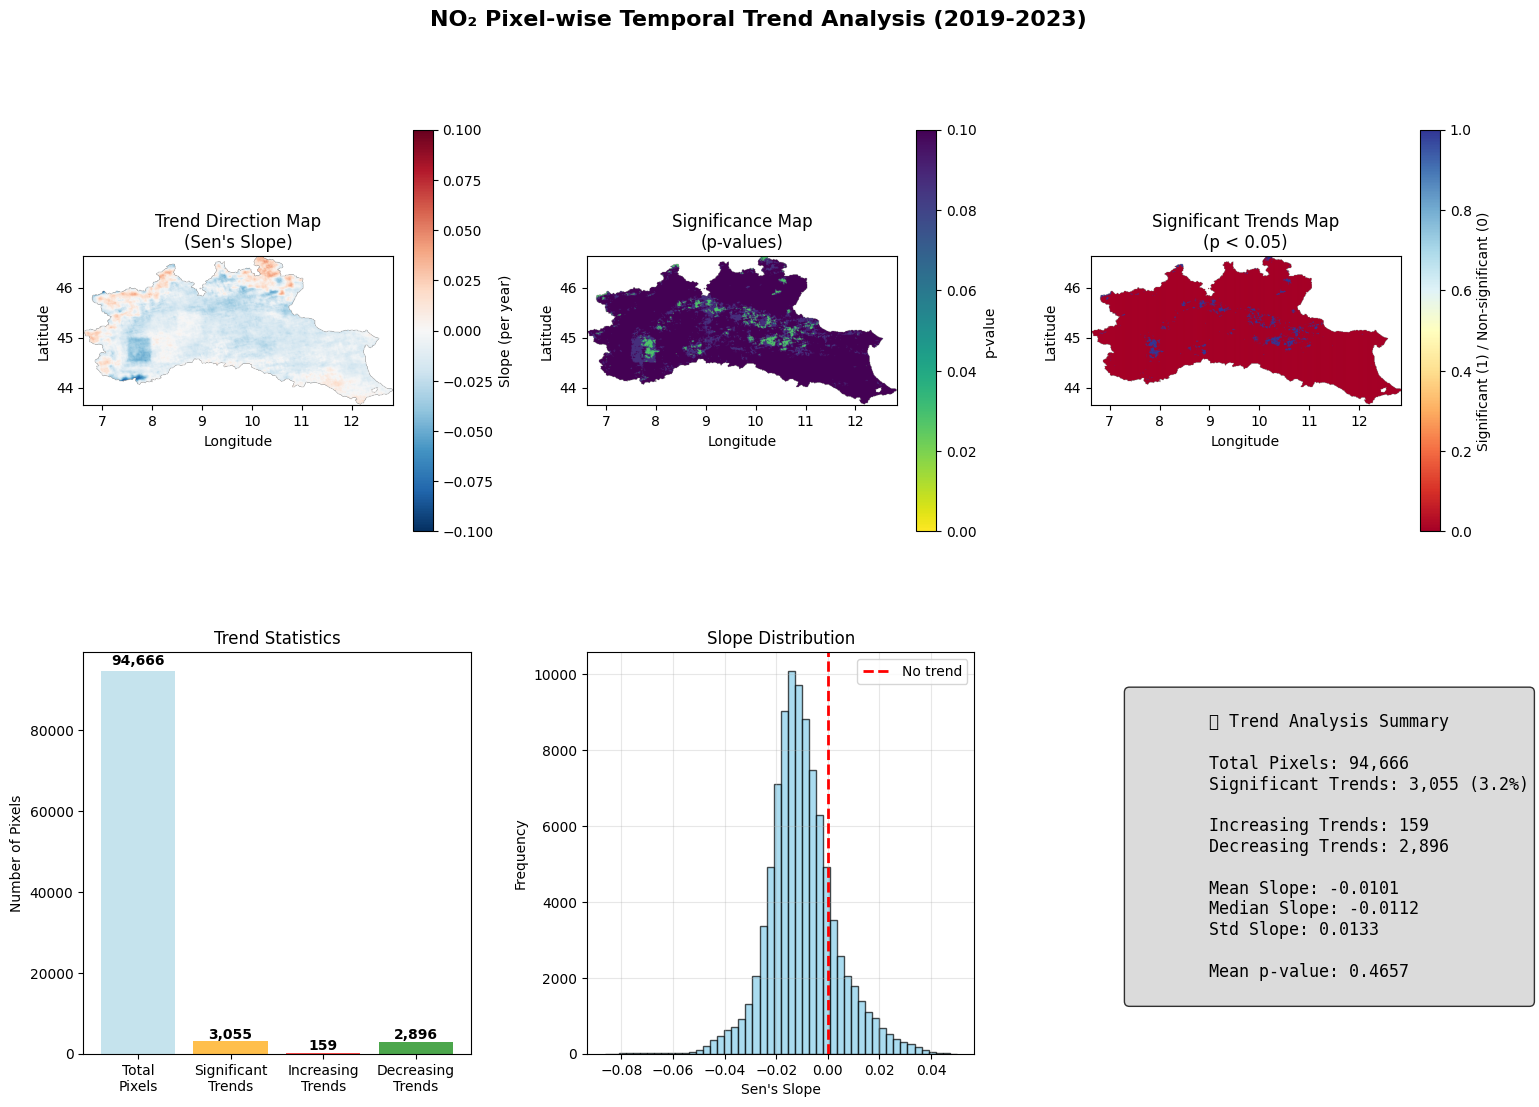


📋 NO2 Pixel-wise Trend Analysis Report

 Analysis Overview:
   Years analyzed: 5
   Year range: 2019 - 2023
   Total pixels analyzed: 94,666

🔍 Trend Results:
   Significant trends: 3,055 (3.2%)
   Increasing trends: 159
   Decreasing trends: 2,896

📈 Slope Statistics:
   Mean slope: -0.0101
   Median slope: -0.0112
   Standard deviation: 0.0133
   Mean p-value: 0.4657

 Interpretation:
   📉 Overall trend: Decreasing missing data over time
   ✅ Low proportion of significant trends - stable patterns

🎯 Recommendations:
   🔍 Focus on areas with significant increasing trends
   📊 Investigate causes of missing data patterns
   🎯 Use trend information for gap-filling strategy optimization
   📈 Monitor trends for data quality assessment

🎉 Analysis completed!

✅ Analysis completed successfully!
📊 Results available in memory
📁 Visualization saved as PNG file


In [ ]:
#!/usr/bin/env python3
"""
NO2 Pixel-wise Temporal Trend Analysis

Modified from the original year-to-year correlation analysis to focus on
pixel-wise temporal trends using Mann-Kendall test and Sen's slope estimation.
"""

import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import os
from scipy.stats import kendalltau
import warnings
warnings.filterwarnings('ignore')

class NO2PixelwiseTrendAnalysis:
    """Analyze pixel-wise temporal trends in NO2 missing patterns"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.file_template = os.path.join(base_path, "GEE_NO2", "NO2_Daily_Multiband_{}.tif")
        self.aoi_path = os.path.join(base_path, "AOI", "delimitazione_distretto.shp")
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("📅 NO2 Pixel-wise Temporal Trend Analyzer")
        print(f" File template: {self.file_template}")
        print(f" AOI: {self.aoi_path}")
        print(f"📅 Years: {self.years}")

    def load_aoi_mask(self, transform, out_shape):
        """Load AOI mask"""
        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_mask = geometry_mask([aoi.geometry.union_all()],
                                   transform=transform,
                                   invert=True,
                                   out_shape=out_shape)
            print(f"✅ AOI mask loaded: {aoi_mask.shape}")
            return aoi_mask
        except Exception as e:
            print(f"❌ Error loading AOI: {e}")
            return None

    def analyze_year_missing_patterns(self, year):
        """Analyze missing patterns for a specific year"""
        print(f"\n Analyzing {year}...")

        file_path = self.file_template.format(year)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return None

        try:
            with rasterio.open(file_path) as src:
                bands = src.read()  # shape: (days, height, width)
                print(f"   Bands: {bands.shape}")

                # 0 or nan is considered missing
                mask = (bands <= 0) | np.isnan(bands)
                yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel
                total_days = bands.shape[0]
                gap_ratio = yearly_gap / total_days   # Missing rate per pixel

                # Get spatial info
                bounds = src.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
                transform = src.transform
                out_shape = (src.height, src.width)

                # Load AOI mask
                aoi_mask = self.load_aoi_mask(transform, out_shape)

                if aoi_mask is not None:
                    # Apply AOI mask to the gap ratio
                    masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

                    # Calculate statistics
                    valid_data = masked_gap_aoi.compressed()

                    if len(valid_data) > 0:
                        year_stats = {
                            'year': year,
                            'total_days': total_days,
                            'valid_pixels': len(valid_data),
                            'mean_missing': np.mean(valid_data),
                            'median_missing': np.median(valid_data),
                            'std_missing': np.std(valid_data),
                            'min_missing': np.min(valid_data),
                            'max_missing': np.max(valid_data),
                            'p90_missing': np.percentile(valid_data, 90),
                            'p95_missing': np.percentile(valid_data, 95),
                            'gap_ratio': gap_ratio,
                            'aoi_mask': aoi_mask,
                            'extent': extent,
                            'transform': transform
                        }

                        print(f"   ✅ Valid pixels: {len(valid_data):,}")
                        print(f"    Mean missing: {np.mean(valid_data):.3f} ({np.mean(valid_data)*100:.1f}%)")
                        print(f"   📊 Std missing: {np.std(valid_data):.3f}")

                        return year_stats
                    else:
                        print(f"   ⚠️ No valid data after AOI masking")
                        return None
                else:
                    print(f"   ❌ AOI mask not available")
                    return None

        except Exception as e:
            print(f"   ❌ Error processing {year}: {e}")
            return None

    def mann_kendall_test(self, time_series):
        """Perform Mann-Kendall test for trend detection"""
        n = len(time_series)
        if n < 3:
            return np.nan, np.nan

        # Remove NaN values
        valid_indices = ~np.isnan(time_series)
        if np.sum(valid_indices) < 3:
            return np.nan, np.nan

        valid_series = time_series[valid_indices]
        valid_years = np.arange(n)[valid_indices]

        # Calculate S statistic
        S = 0
        for i in range(len(valid_series)):
            for j in range(i+1, len(valid_series)):
                S += np.sign(valid_series[j] - valid_series[i])

        # Calculate variance
        var_S = (n * (n - 1) * (2 * n + 5)) / 18

        # Calculate Z statistic
        if S > 0:
            Z = (S - 1) / np.sqrt(var_S)
        elif S < 0:
            Z = (S + 1) / np.sqrt(var_S)
        else:
            Z = 0

        # Calculate p-value (two-tailed)
        p_value = 2 * (1 - stats.norm.cdf(abs(Z)))

        return Z, p_value

    def sens_slope_estimation(self, time_series):
        """Calculate Sen's slope estimator"""
        n = len(time_series)
        if n < 2:
            return np.nan

        # Remove NaN values
        valid_indices = ~np.isnan(time_series)
        if np.sum(valid_indices) < 2:
            return np.nan

        valid_series = time_series[valid_indices]
        valid_years = np.arange(n)[valid_indices]

        # Calculate all pairwise slopes
        slopes = []
        for i in range(len(valid_series)):
            for j in range(i+1, len(valid_series)):
                slope = (valid_series[j] - valid_series[i]) / (valid_years[j] - valid_years[i])
                slopes.append(slope)

        # Return median slope
        return np.median(slopes)

    def analyze_pixelwise_trends(self, yearly_stats):
        """Analyze pixel-wise temporal trends"""
        print(f"\n🔍 Analyzing Pixel-wise Temporal Trends")
        print("=" * 50)

        if len(yearly_stats) < 3:
            print("❌ Need at least 3 years for trend analysis")
            return None

        # Extract data
        years = [stats['year'] for stats in yearly_stats]
        gap_ratios = [stats['gap_ratio'] for stats in yearly_stats]
        aoi_masks = [stats['aoi_mask'] for stats in yearly_stats]

        # Get common AOI mask (intersection of all years)
        common_aoi_mask = np.ones_like(aoi_masks[0], dtype=bool)
        for mask in aoi_masks:
            common_aoi_mask = common_aoi_mask & mask

        print(f"📊 Common AOI pixels: {np.sum(common_aoi_mask):,}")

        # Stack data into 3D cube: (years, height, width)
        data_cube = np.stack(gap_ratios, axis=0)
        print(f"📊 Data cube shape: {data_cube.shape}")

        # Initialize result arrays
        height, width = data_cube.shape[1], data_cube.shape[2]
        significance_map = np.full((height, width), np.nan)
        trend_direction_map = np.full((height, width), np.nan)
        trend_significance_map = np.full((height, width), False)

        # Process each pixel
        print(f" Processing {np.sum(common_aoi_mask):,} pixels...")

        processed_pixels = 0
        significant_trends = 0
        increasing_trends = 0
        decreasing_trends = 0

        for i in range(height):
            for j in range(width):
                if common_aoi_mask[i, j]:
                    # Extract time series for this pixel
                    time_series = data_cube[:, i, j]

                    # Skip if too many NaN values
                    if np.sum(np.isnan(time_series)) > len(time_series) / 2:
                        continue

                    # Perform Mann-Kendall test
                    Z, p_value = self.mann_kendall_test(time_series)

                    # Calculate Sen's slope
                    slope = self.sens_slope_estimation(time_series)

                    # Store results
                    significance_map[i, j] = p_value
                    trend_direction_map[i, j] = slope

                    # Determine significance (p < 0.05)
                    if p_value < 0.05:
                        trend_significance_map[i, j] = True
                        significant_trends += 1

                        if slope > 0:
                            increasing_trends += 1
                        else:
                            decreasing_trends += 1

                    processed_pixels += 1

                    # Progress update
                    if processed_pixels % 10000 == 0:
                        print(f"   Processed {processed_pixels:,} pixels...")

        print(f"✅ Analysis completed!")
        print(f"   Processed pixels: {processed_pixels:,}")
        print(f"   Significant trends: {significant_trends:,} ({significant_trends/processed_pixels*100:.1f}%)")
        print(f"   Increasing trends: {increasing_trends:,} ({increasing_trends/processed_pixels*100:.1f}%)")
        print(f"   Decreasing trends: {decreasing_trends:,} ({decreasing_trends/processed_pixels*100:.1f}%)")

        # Calculate summary statistics
        valid_significance = significance_map[~np.isnan(significance_map)]
        valid_trends = trend_direction_map[~np.isnan(trend_direction_map)]

        trend_results = {
            'significance_map': significance_map,
            'trend_direction_map': trend_direction_map,
            'trend_significance_map': trend_significance_map,
            'years': years,
            'common_aoi_mask': common_aoi_mask,
            'summary_stats': {
                'total_pixels': processed_pixels,
                'significant_trends': significant_trends,
                'increasing_trends': increasing_trends,
                'decreasing_trends': decreasing_trends,
                'significance_rate': significant_trends/processed_pixels*100 if processed_pixels > 0 else 0,
                'mean_p_value': np.mean(valid_significance) if len(valid_significance) > 0 else np.nan,
                'median_slope': np.median(valid_trends) if len(valid_trends) > 0 else np.nan,
                'mean_slope': np.mean(valid_trends) if len(valid_trends) > 0 else np.nan,
                'std_slope': np.std(valid_trends) if len(valid_trends) > 0 else np.nan
            }
        }

        return trend_results

    def create_trend_visualization(self, yearly_stats, trend_results):
        """Create trend visualization"""
        print(f"\n📊 Creating Trend Visualization")
        print("=" * 40)

        if not trend_results:
            print("❌ No trend results for visualization")
            return

        # Extract data
        significance_map = trend_results['significance_map']
        trend_direction_map = trend_results['trend_direction_map']
        trend_significance_map = trend_results['trend_significance_map']
        common_aoi_mask = trend_results['common_aoi_mask']
        summary_stats = trend_results['summary_stats']

        # Get spatial extent from first year
        extent = yearly_stats[0]['extent']

        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))

        # Create subplot layout - 2x3 grid
        gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

        # Plot 1: Trend Direction Map
        ax1 = fig.add_subplot(gs[0, 0])
        im1 = ax1.imshow(trend_direction_map, cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                        extent=extent, origin='upper')
        ax1.set_title('Trend Direction Map\n(Sen\'s Slope)')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        plt.colorbar(im1, ax=ax1, label='Slope (per year)')

        # Plot 2: Significance Map
        ax2 = fig.add_subplot(gs[0, 1])
        im2 = ax2.imshow(significance_map, cmap='viridis_r', vmin=0, vmax=0.1,
                        extent=extent, origin='upper')
        ax2.set_title('Significance Map\n(p-values)')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        plt.colorbar(im2, ax=ax2, label='p-value')

        # Plot 3: Significant Trends Map
        ax3 = fig.add_subplot(gs[0, 2])
        # Create binary map: 1 for significant, 0 for non-significant
        binary_map = trend_significance_map.astype(float)
        binary_map[~common_aoi_mask] = np.nan
        im3 = ax3.imshow(binary_map, cmap='RdYlBu', vmin=0, vmax=1,
                        extent=extent, origin='upper')
        ax3.set_title('Significant Trends Map\n(p < 0.05)')
        ax3.set_xlabel('Longitude')
        ax3.set_ylabel('Latitude')
        plt.colorbar(im3, ax=ax3, label='Significant (1) / Non-significant (0)')

        # Plot 4: Trend Statistics
        ax4 = fig.add_subplot(gs[1, 0])
        categories = ['Total\nPixels', 'Significant\nTrends', 'Increasing\nTrends', 'Decreasing\nTrends']
        values = [summary_stats['total_pixels'],
                 summary_stats['significant_trends'],
                 summary_stats['increasing_trends'],
                 summary_stats['decreasing_trends']]
        colors = ['lightblue', 'orange', 'red', 'green']

        bars = ax4.bar(categories, values, color=colors, alpha=0.7)
        ax4.set_title('Trend Statistics')
        ax4.set_ylabel('Number of Pixels')

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value:,}', ha='center', va='bottom', fontweight='bold')

        # Plot 5: Slope Distribution
        ax5 = fig.add_subplot(gs[1, 1])
        valid_slopes = trend_direction_map[~np.isnan(trend_direction_map)]
        ax5.hist(valid_slopes, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax5.axvline(0, color='red', linestyle='--', linewidth=2, label='No trend')
        ax5.set_title('Slope Distribution')
        ax5.set_xlabel('Sen\'s Slope')
        ax5.set_ylabel('Frequency')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Plot 6: Summary Statistics
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.axis('off')

        # Create summary text
        summary_text = f"""
        📊 Trend Analysis Summary

        Total Pixels: {summary_stats['total_pixels']:,}
        Significant Trends: {summary_stats['significant_trends']:,} ({summary_stats['significance_rate']:.1f}%)

        Increasing Trends: {summary_stats['increasing_trends']:,}
        Decreasing Trends: {summary_stats['decreasing_trends']:,}

        Mean Slope: {summary_stats['mean_slope']:.4f}
        Median Slope: {summary_stats['median_slope']:.4f}
        Std Slope: {summary_stats['std_slope']:.4f}

        Mean p-value: {summary_stats['mean_p_value']:.4f}
        """

        ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=12,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.suptitle('NO₂ Pixel-wise Temporal Trend Analysis (2019-2023)', fontsize=16, fontweight='bold')
        plt.tight_layout()

        # Save figure
        output_path = 'NO2_Pixelwise_Trend_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Figure saved: {output_path}")

        plt.show()

    def generate_trend_report(self, yearly_stats, trend_results):
        """Generate trend analysis report"""
        print(f"\n📋 NO2 Pixel-wise Trend Analysis Report")
        print("=" * 60)

        if not trend_results:
            print("❌ No trend results available for report")
            return

        summary_stats = trend_results['summary_stats']

        print(f"\n Analysis Overview:")
        print(f"   Years analyzed: {len(trend_results['years'])}")
        print(f"   Year range: {min(trend_results['years'])} - {max(trend_results['years'])}")
        print(f"   Total pixels analyzed: {summary_stats['total_pixels']:,}")

        print(f"\n🔍 Trend Results:")
        print(f"   Significant trends: {summary_stats['significant_trends']:,} ({summary_stats['significance_rate']:.1f}%)")
        print(f"   Increasing trends: {summary_stats['increasing_trends']:,}")
        print(f"   Decreasing trends: {summary_stats['decreasing_trends']:,}")

        print(f"\n📈 Slope Statistics:")
        print(f"   Mean slope: {summary_stats['mean_slope']:.4f}")
        print(f"   Median slope: {summary_stats['median_slope']:.4f}")
        print(f"   Standard deviation: {summary_stats['std_slope']:.4f}")
        print(f"   Mean p-value: {summary_stats['mean_p_value']:.4f}")

        print(f"\n Interpretation:")
        if summary_stats['mean_slope'] > 0:
            print("   📈 Overall trend: Increasing missing data over time")
        elif summary_stats['mean_slope'] < 0:
            print("   📉 Overall trend: Decreasing missing data over time")
        else:
            print("   📊 Overall trend: No clear trend")

        if summary_stats['significance_rate'] > 50:
            print("   ⚠️ High proportion of significant trends - investigate causes")
        elif summary_stats['significance_rate'] > 25:
            print("   📊 Moderate proportion of significant trends")
        else:
            print("   ✅ Low proportion of significant trends - stable patterns")

        print(f"\n🎯 Recommendations:")
        print("   🔍 Focus on areas with significant increasing trends")
        print("   📊 Investigate causes of missing data patterns")
        print("   🎯 Use trend information for gap-filling strategy optimization")
        print("   📈 Monitor trends for data quality assessment")

    def run_analysis(self):
        """Run complete pixel-wise trend analysis"""
        print("🚀 Starting NO2 Pixel-wise Temporal Trend Analysis")
        print("=" * 60)

        # Analyze each year
        yearly_stats = []
        for year in self.years:
            stats = self.analyze_year_missing_patterns(year)
            if stats:
                yearly_stats.append(stats)

        if not yearly_stats:
            print("❌ No valid data found for any year")
            return None

        # Analyze pixel-wise trends
        trend_results = self.analyze_pixelwise_trends(yearly_stats)

        if not trend_results:
            print("❌ Trend analysis failed")
            return None

        # Create visualization
        self.create_trend_visualization(yearly_stats, trend_results)

        # Generate report
        self.generate_trend_report(yearly_stats, trend_results)

        print(f"\n🎉 Analysis completed!")
        return {
            'yearly_stats': yearly_stats,
            'trend_results': trend_results
        }


def main():
    """Main function"""
    print("🚀 NO2 Pixel-wise Temporal Trend Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = NO2PixelwiseTrendAnalysis()

    # Run analysis
    results = analyzer.run_analysis()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualization saved as PNG file")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()

# 2. SO2 Year-to-Year Correlation Analysis

🚀 SO2 Year-to-Year Correlation Analysis
📅 SO2 Year-to-Year Correlation Analyzer
📁 File template: /content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_{}.tif
📁 AOI: /content/drive/MyDrive/AOI/delimitazione_distretto.shp
📅 Years: [2019, 2020, 2021, 2022, 2023]
🚀 Starting SO2 Year-to-Year Correlation Analysis

📊 Analyzing 2019...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.751 (75.1%)
   📊 Std missing: 0.075

📊 Analyzing 2020...
   Bands: (366, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.772 (77.2%)
   📊 Std missing: 0.074

📊 Analyzing 2021...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.791 (79.1%)
   📊 Std missing: 0.075

📊 Analyzing 2022...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.770 (77.0%)
   📊 Std missing: 0.066

📊 Analyzing 2023...
   Bands: (365, 300, 621)
✅ AOI m

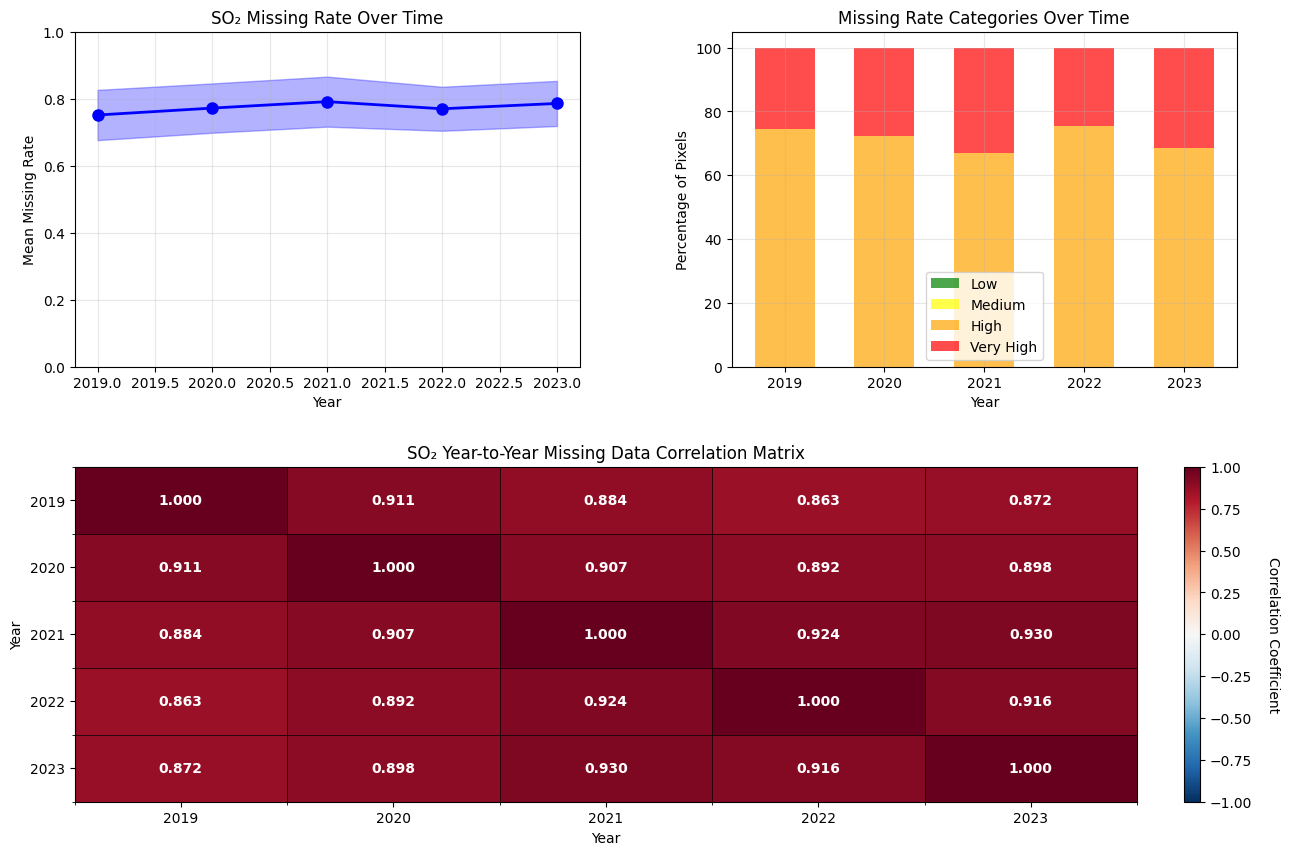


📋 SO2 Year-to-Year Correlation Summary Report

📊 Overall Statistics:
   Years analyzed: 5
   Year range: 2019 - 2023

📅 Yearly Statistics:
   2019:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.751 (75.1%)
     Std missing: 0.075
     P90 missing: 0.874 (87.4%)
   2020:
     Total days: 366
     Valid pixels: 94,666
     Mean missing: 0.772 (77.2%)
     Std missing: 0.074
     P90 missing: 0.896 (89.6%)
   2021:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.791 (79.1%)
     Std missing: 0.075
     P90 missing: 0.918 (91.8%)
   2022:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.770 (77.0%)
     Std missing: 0.066
     P90 missing: 0.877 (87.7%)
   2023:
     Total days: 365
     Valid pixels: 94,666
     Mean missing: 0.786 (78.6%)
     Std missing: 0.067
     P90 missing: 0.893 (89.3%)

🔗 Correlation Analysis:
   Time trend: increasing
   Pearson correlation: 0.680 (p=0.207)
   Spearman correlation: 0.500 (p=0.391)
   

In [ ]:
#!/usr/bin/env python3
"""
SO2 Year-to-Year Correlation Analysis

Based on the NO2 analysis, this script analyzes year-to-year correlations
in SO2 missing patterns.
"""

import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import os

class SO2YearToYearCorrelation:
    """Analyze year-to-year correlations in SO2 missing patterns"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.file_template = os.path.join(base_path, "GEE_SO2", "SO2_Daily_Multiband_{}.tif")
        self.aoi_path = os.path.join(base_path, "AOI", "delimitazione_distretto.shp")
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("📅 SO2 Year-to-Year Correlation Analyzer")
        print(f"📁 File template: {self.file_template}")
        print(f"📁 AOI: {self.aoi_path}")
        print(f"📅 Years: {self.years}")

    def load_aoi_mask(self, transform, out_shape):
        """Load AOI mask"""
        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_mask = geometry_mask([aoi.geometry.union_all()],
                                   transform=transform,
                                   invert=True,
                                   out_shape=out_shape)
            print(f"✅ AOI mask loaded: {aoi_mask.shape}")
            return aoi_mask
        except Exception as e:
            print(f"❌ Error loading AOI: {e}")
            return None

    def analyze_year_missing_patterns(self, year):
        """Analyze missing patterns for a specific year"""
        print(f"\n📊 Analyzing {year}...")

        file_path = self.file_template.format(year)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return None

        try:
            with rasterio.open(file_path) as src:
                bands = src.read()  # shape: (days, height, width)
                print(f"   Bands: {bands.shape}")

                # 0 or nan is considered missing
                mask = (bands <= 0) | np.isnan(bands)
                yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel
                total_days = bands.shape[0]
                gap_ratio = yearly_gap / total_days   # Missing rate per pixel

                # Get spatial info
                bounds = src.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
                transform = src.transform
                out_shape = (src.height, src.width)

                # Load AOI mask
                aoi_mask = self.load_aoi_mask(transform, out_shape)

                if aoi_mask is not None:
                    # Apply AOI mask to the gap ratio
                    masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

                    # Calculate statistics
                    valid_data = masked_gap_aoi.compressed()

                    if len(valid_data) > 0:
                        year_stats = {
                            'year': year,
                            'total_days': total_days,
                            'valid_pixels': len(valid_data),
                            'mean_missing': np.mean(valid_data),
                            'median_missing': np.median(valid_data),
                            'std_missing': np.std(valid_data),
                            'min_missing': np.min(valid_data),
                            'max_missing': np.max(valid_data),
                            'p90_missing': np.percentile(valid_data, 90),
                            'p95_missing': np.percentile(valid_data, 95),
                            'gap_ratio': gap_ratio,
                            'aoi_mask': aoi_mask,
                            'extent': extent,
                            'transform': transform
                        }

                        # Missing rate categories
                        year_stats['low_missing'] = np.sum(valid_data < 0.2)
                        year_stats['medium_missing'] = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
                        year_stats['high_missing'] = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
                        year_stats['very_high_missing'] = np.sum(valid_data >= 0.8)

                        print(f"   ✅ Valid pixels: {len(valid_data):,}")
                        print(f"   📊 Mean missing: {np.mean(valid_data):.3f} ({np.mean(valid_data)*100:.1f}%)")
                        print(f"   📊 Std missing: {np.std(valid_data):.3f}")

                        return year_stats
                    else:
                        print(f"   ⚠️ No valid data after AOI masking")
                        return None
                else:
                    print(f"   ❌ AOI mask not available")
                    return None

        except Exception as e:
            print(f"   ❌ Error processing {year}: {e}")
            return None

    def calculate_year_to_year_correlations(self, yearly_stats):
        """Calculate year-to-year correlations"""
        print(f"\n🔗 Calculating Year-to-Year Correlations")
        print("=" * 50)

        if len(yearly_stats) < 2:
            print("❌ Need at least 2 years for correlation analysis")
            return None

        # Extract yearly statistics
        years = [stats['year'] for stats in yearly_stats]
        mean_missing = [stats['mean_missing'] for stats in yearly_stats]
        std_missing = [stats['std_missing'] for stats in yearly_stats]
        median_missing = [stats['median_missing'] for stats in yearly_stats]

        # Calculate correlations
        correlations = {}

        # Create year-to-year correlation matrix
        n_years = len(years)
        correlation_matrix = np.ones((n_years, n_years))  # Initialize with 1s on diagonal

        print(f"📊 Year-to-Year Correlation Matrix:")
        print(f"   Calculating correlations between {n_years} years...")

        # Calculate pairwise correlations
        for i in range(n_years):
            for j in range(i+1, n_years):
                year_i, year_j = years[i], years[j]

                # Get gap ratios for both years
                gap_ratio_i = yearly_stats[i]['gap_ratio']
                gap_ratio_j = yearly_stats[j]['gap_ratio']
                aoi_mask_i = yearly_stats[i]['aoi_mask']
                aoi_mask_j = yearly_stats[j]['aoi_mask']

                # Apply AOI masks
                masked_i = ma.masked_where(~aoi_mask_i, gap_ratio_i)
                masked_j = ma.masked_where(~aoi_mask_j, gap_ratio_j)

                # Get valid data (where both years have valid data)
                valid_mask = ~(masked_i.mask | masked_j.mask)
                if np.sum(valid_mask) > 100:  # Need sufficient data points
                    valid_data_i = masked_i[valid_mask].compressed()
                    valid_data_j = masked_j[valid_mask].compressed()

                    # Calculate correlation
                    if len(valid_data_i) > 0 and len(valid_data_j) > 0:
                        corr_coef, p_value = pearsonr(valid_data_i, valid_data_j)
                        correlation_matrix[i, j] = corr_coef
                        correlation_matrix[j, i] = corr_coef  # Symmetric matrix

                        print(f"   {year_i} vs {year_j}: r={corr_coef:.3f} (n={len(valid_data_i)})")
                    else:
                        print(f"   {year_i} vs {year_j}: No valid data")
                        correlation_matrix[i, j] = np.nan
                        correlation_matrix[j, i] = np.nan
                else:
                    print(f"   {year_i} vs {year_j}: Insufficient overlap")
                    correlation_matrix[i, j] = np.nan
                    correlation_matrix[j, i] = np.nan

        correlations['correlation_matrix'] = correlation_matrix
        correlations['years'] = years

        # Time trend correlation (year vs missing rate)
        if len(years) >= 2:
            pearson_r, pearson_p = pearsonr(years, mean_missing)
            spearman_r, spearman_p = spearmanr(years, mean_missing)

            correlations['time_trend'] = {
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'trend': 'increasing' if pearson_r > 0 else 'decreasing',
                'significance': 'significant' if pearson_p < 0.05 else 'not_significant'
            }

            print(f"\n📈 Time Trend Correlation:")
            print(f"   Pearson r: {pearson_r:.3f} (p={pearson_p:.3f})")
            print(f"   Spearman r: {spearman_r:.3f} (p={spearman_p:.3f})")
            print(f"   Trend: {'Increasing' if pearson_r > 0 else 'Decreasing'}")
            print(f"   Significance: {'Significant' if pearson_p < 0.05 else 'Not significant'}")

        # Year-to-year variability
        if len(mean_missing) >= 2:
            year_to_year_changes = np.diff(mean_missing)
            correlations['year_to_year_variability'] = {
                'changes': year_to_year_changes,
                'mean_change': np.mean(year_to_year_changes),
                'std_change': np.std(year_to_year_changes),
                'max_increase': np.max(year_to_year_changes),
                'max_decrease': np.min(year_to_year_changes)
            }

            print(f"\n📊 Year-to-Year Variability:")
            print(f"   Mean change: {np.mean(year_to_year_changes):.3f}")
            print(f"   Std change: {np.std(year_to_year_changes):.3f}")
            print(f"   Max increase: {np.max(year_to_year_changes):.3f}")
            print(f"   Max decrease: {np.min(year_to_year_changes):.3f}")

        return correlations

    def create_summary_visualization(self, yearly_stats, correlations):
        """Create summary visualization"""
        print(f"\n📊 Creating Summary Visualization")
        print("=" * 40)

        if not yearly_stats:
            print("❌ No data for visualization")
            return

        # Extract data for plotting
        years = [stats['year'] for stats in yearly_stats]
        mean_missing = [stats['mean_missing'] for stats in yearly_stats]
        std_missing = [stats['std_missing'] for stats in yearly_stats]

        # Create figure with subplots - simplified layout
        fig = plt.figure(figsize=(15, 10))

        # Create subplot layout - 2x2 grid
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        ax1 = fig.add_subplot(gs[0, 0])  # Time series
        ax2 = fig.add_subplot(gs[0, 1])  # Categories
        ax3 = fig.add_subplot(gs[1, :])  # Correlation matrix heatmap (spans full width)

        # Plot 1: Mean missing rate over time
        ax1.plot(years, mean_missing, 'o-', linewidth=2, markersize=8, color='blue')
        ax1.fill_between(years,
                        np.array(mean_missing) - np.array(std_missing),
                        np.array(mean_missing) + np.array(std_missing),
                        alpha=0.3, color='blue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Mean Missing Rate')
        ax1.set_title('SO₂ Missing Rate Over Time')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)

        # Add trend line if correlation exists
        if correlations and 'time_trend' in correlations:
            trend = correlations['time_trend']
            if trend['significance'] == 'significant':
                ax1.text(0.05, 0.95, f"Trend: {trend['trend']}\n(r={trend['pearson_r']:.3f}, p={trend['pearson_p']:.3f})",
                        transform=ax1.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        # Plot 2: Missing rate categories over time
        categories = ['Low (<20%)', 'Medium (20-50%)', 'High (50-80%)', 'Very High (≥80%)']
        low_pct = [stats['low_missing']/stats['valid_pixels']*100 for stats in yearly_stats]
        medium_pct = [stats['medium_missing']/stats['valid_pixels']*100 for stats in yearly_stats]
        high_pct = [stats['high_missing']/stats['valid_pixels']*100 for stats in yearly_stats]
        very_high_pct = [stats['very_high_missing']/stats['valid_pixels']*100 for stats in yearly_stats]

        width = 0.6
        x = np.arange(len(years))

        ax2.bar(x, low_pct, width, label='Low', color='green', alpha=0.7)
        ax2.bar(x, medium_pct, width, bottom=low_pct, label='Medium', color='yellow', alpha=0.7)
        ax2.bar(x, high_pct, width, bottom=np.array(low_pct)+np.array(medium_pct),
                label='High', color='orange', alpha=0.7)
        ax2.bar(x, very_high_pct, width,
                bottom=np.array(low_pct)+np.array(medium_pct)+np.array(high_pct),
                label='Very High', color='red', alpha=0.7)

        ax2.set_xlabel('Year')
        ax2.set_ylabel('Percentage of Pixels')
        ax2.set_title('Missing Rate Categories Over Time')
        ax2.set_xticks(x)
        ax2.set_xticklabels(years)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Year-to-Year Correlation Matrix Heatmap
        if correlations and 'correlation_matrix' in correlations:
            corr_matrix = correlations['correlation_matrix']
            corr_years = correlations['years']

            # Create heatmap
            im = ax3.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

            # Set ticks and labels
            ax3.set_xticks(range(len(corr_years)))
            ax3.set_yticks(range(len(corr_years)))
            ax3.set_xticklabels(corr_years)
            ax3.set_yticklabels(corr_years)

            # Add correlation values as text
            for i in range(len(corr_years)):
                for j in range(len(corr_years)):
                    if not np.isnan(corr_matrix[i, j]):
                        text_color = 'white' if abs(corr_matrix[i, j]) > 0.5 else 'black'
                        ax3.text(j, i, f'{corr_matrix[i, j]:.3f}',
                                ha='center', va='center', color=text_color, fontweight='bold')
                    else:
                        ax3.text(j, i, 'N/A', ha='center', va='center', color='gray')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
            cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

            ax3.set_title('SO₂ Year-to-Year Missing Data Correlation Matrix')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Year')

            # Add grid
            ax3.set_xticks(np.arange(-0.5, len(corr_years), 1), minor=True)
            ax3.set_yticks(np.arange(-0.5, len(corr_years), 1), minor=True)
            ax3.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

        plt.tight_layout()

        # Save figure
        output_path = 'SO2_Year_to_Year_Correlation_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Figure saved: {output_path}")

        plt.show()

    def generate_summary_report(self, yearly_stats, correlations):
        """Generate summary report"""
        print(f"\n📋 SO2 Year-to-Year Correlation Summary Report")
        print("=" * 60)

        if not yearly_stats:
            print("❌ No data available for summary")
            return

        # Overall statistics
        print(f"\n📊 Overall Statistics:")
        print(f"   Years analyzed: {len(yearly_stats)}")
        print(f"   Year range: {min([s['year'] for s in yearly_stats])} - {max([s['year'] for s in yearly_stats])}")

        # Yearly statistics
        print(f"\n📅 Yearly Statistics:")
        for stats in yearly_stats:
            print(f"   {stats['year']}:")
            print(f"     Total days: {stats['total_days']}")
            print(f"     Valid pixels: {stats['valid_pixels']:,}")
            print(f"     Mean missing: {stats['mean_missing']:.3f} ({stats['mean_missing']*100:.1f}%)")
            print(f"     Std missing: {stats['std_missing']:.3f}")
            print(f"     P90 missing: {stats['p90_missing']:.3f} ({stats['p90_missing']*100:.1f}%)")

        # Correlation results
        if correlations:
            print(f"\n🔗 Correlation Analysis:")
            if 'time_trend' in correlations:
                trend = correlations['time_trend']
                print(f"   Time trend: {trend['trend']}")
                print(f"   Pearson correlation: {trend['pearson_r']:.3f} (p={trend['pearson_p']:.3f})")
                print(f"   Spearman correlation: {trend['spearman_r']:.3f} (p={trend['spearman_p']:.3f})")
                print(f"   Significance: {trend['significance']}")

            if 'year_to_year_variability' in correlations:
                var = correlations['year_to_year_variability']
                print(f"   Year-to-year variability:")
                print(f"     Mean change: {var['mean_change']:.3f}")
                print(f"     Std change: {var['std_change']:.3f}")
                print(f"     Max increase: {var['max_increase']:.3f}")
                print(f"     Max decrease: {var['max_decrease']:.3f}")

        # Recommendations
        print(f"\n💡 Recommendations:")
        if correlations and 'time_trend' in correlations:
            trend = correlations['time_trend']
            if trend['significance'] == 'significant':
                if trend['trend'] == 'increasing':
                    print("   ⚠️ Missing data is increasing over time - investigate causes")
                else:
                    print("   ✅ Missing data is decreasing over time - good trend")
            else:
                print("   📊 No significant time trend in missing data")

        print("   🔄 Consider seasonal analysis for more detailed patterns")
        print("   📈 Monitor year-to-year changes for data quality assessment")
        print("   🎯 Use findings to improve gap-filling strategies")

    def run_analysis(self):
        """Run complete year-to-year correlation analysis"""
        print("🚀 Starting SO2 Year-to-Year Correlation Analysis")
        print("=" * 60)

        # Analyze each year
        yearly_stats = []
        for year in self.years:
            stats = self.analyze_year_missing_patterns(year)
            if stats:
                yearly_stats.append(stats)

        if not yearly_stats:
            print("❌ No valid data found for any year")
            return None

        # Calculate correlations
        correlations = self.calculate_year_to_year_correlations(yearly_stats)

        # Create visualization
        self.create_summary_visualization(yearly_stats, correlations)

        # Generate report
        self.generate_summary_report(yearly_stats, correlations)

        print(f"\n🎉 Analysis completed!")
        return {
            'yearly_stats': yearly_stats,
            'correlations': correlations
        }


def main():
    """Main function"""
    print("🚀 SO2 Year-to-Year Correlation Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = SO2YearToYearCorrelation()

    # Run analysis
    results = analyzer.run_analysis()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualization saved as PNG file")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()


🚀 SO2 Pixel-wise Temporal Trend Analysis
📅 SO2 Pixel-wise Temporal Trend Analyzer
 File template: /content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_{}.tif
 AOI: /content/drive/MyDrive/AOI/delimitazione_distretto.shp
📅 Years: [2019, 2020, 2021, 2022, 2023]
🚀 Starting SO2 Pixel-wise Temporal Trend Analysis

 Analyzing 2019...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.751 (75.1%)
   📊 Std missing: 0.075

 Analyzing 2020...
   Bands: (366, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.772 (77.2%)
   📊 Std missing: 0.074

 Analyzing 2021...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.791 (79.1%)
   📊 Std missing: 0.075

 Analyzing 2022...
   Bands: (365, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
    Mean missing: 0.770 (77.0%)
   📊 Std missing: 0.066

 Analyzing 2023...
   Bands: (365, 300, 621)
✅ AOI mask load

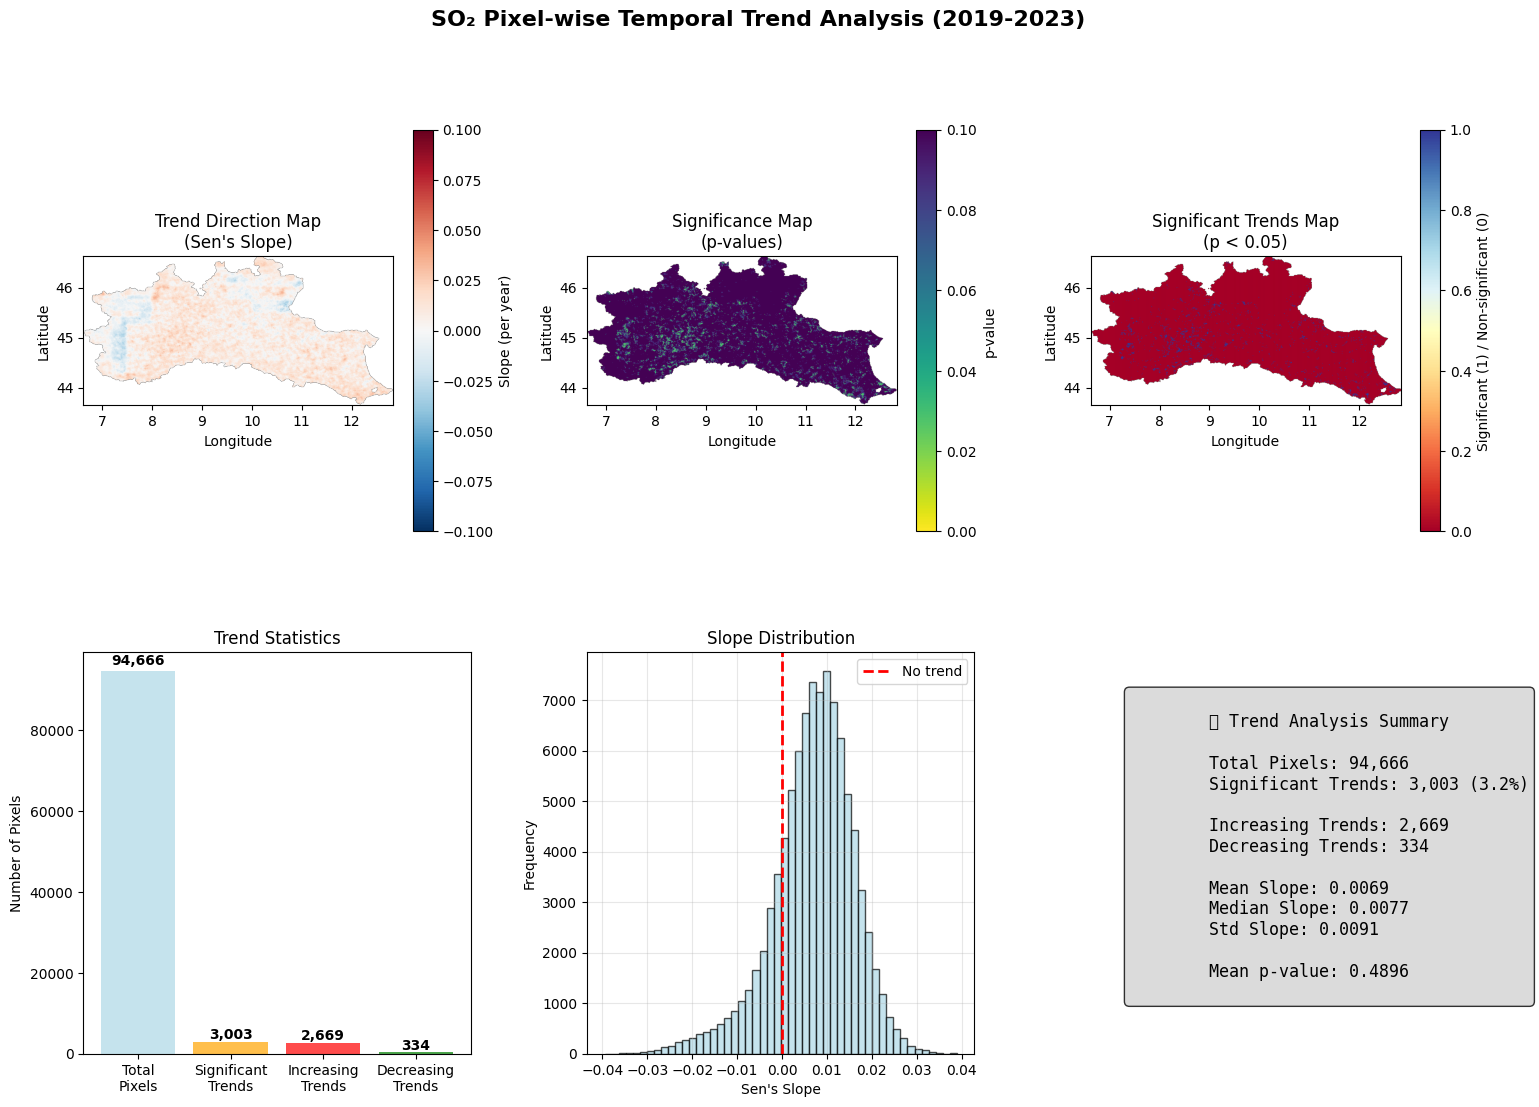


📋 SO2 Pixel-wise Trend Analysis Report

 Analysis Overview:
   Years analyzed: 5
   Year range: 2019 - 2023
   Total pixels analyzed: 94,666

🔍 Trend Results:
   Significant trends: 3,003 (3.2%)
   Increasing trends: 2,669
   Decreasing trends: 334

📈 Slope Statistics:
   Mean slope: 0.0069
   Median slope: 0.0077
   Standard deviation: 0.0091
   Mean p-value: 0.4896

 Interpretation:
   📈 Overall trend: Increasing missing data over time
   ✅ Low proportion of significant trends - stable patterns

🎯 Recommendations:
   🔍 Focus on areas with significant increasing trends
   📊 Investigate causes of missing data patterns
   🎯 Use trend information for gap-filling strategy optimization
    Monitor trends for data quality assessment
   ⚠️ SO2 data quality is generally lower than NO2 - consider enhanced preprocessing

🎉 Analysis completed!

✅ Analysis completed successfully!
📊 Results available in memory
📁 Visualization saved as PNG file


In [ ]:
#!/usr/bin/env python3
"""
SO2 Pixel-wise Temporal Trend Analysis

Modified from the original year-to-year correlation analysis to focus on
pixel-wise temporal trends using Mann-Kendall test and Sen's slope estimation.
"""

import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import os
from scipy.stats import kendalltau
import warnings
warnings.filterwarnings('ignore')

class SO2PixelwiseTrendAnalysis:
    """Analyze pixel-wise temporal trends in SO2 missing patterns"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.file_template = os.path.join(base_path, "GEE_SO2", "SO2_Daily_Multiband_{}.tif")
        self.aoi_path = os.path.join(base_path, "AOI", "delimitazione_distretto.shp")
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("📅 SO2 Pixel-wise Temporal Trend Analyzer")
        print(f" File template: {self.file_template}")
        print(f" AOI: {self.aoi_path}")
        print(f"📅 Years: {self.years}")

    def load_aoi_mask(self, transform, out_shape):
        """Load AOI mask"""
        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_mask = geometry_mask([aoi.geometry.union_all()],
                                   transform=transform,
                                   invert=True,
                                   out_shape=out_shape)
            print(f"✅ AOI mask loaded: {aoi_mask.shape}")
            return aoi_mask
        except Exception as e:
            print(f"❌ Error loading AOI: {e}")
            return None

    def analyze_year_missing_patterns(self, year):
        """Analyze missing patterns for a specific year"""
        print(f"\n Analyzing {year}...")

        file_path = self.file_template.format(year)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return None

        try:
            with rasterio.open(file_path) as src:
                bands = src.read()  # shape: (days, height, width)
                print(f"   Bands: {bands.shape}")

                # 0 or nan is considered missing
                mask = (bands <= 0) | np.isnan(bands)
                yearly_gap = np.sum(mask, axis=0)     # Missing days per pixel
                total_days = bands.shape[0]
                gap_ratio = yearly_gap / total_days   # Missing rate per pixel

                # Get spatial info
                bounds = src.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
                transform = src.transform
                out_shape = (src.height, src.width)

                # Load AOI mask
                aoi_mask = self.load_aoi_mask(transform, out_shape)

                if aoi_mask is not None:
                    # Apply AOI mask to the gap ratio
                    masked_gap_aoi = ma.masked_where(~aoi_mask, gap_ratio)

                    # Calculate statistics
                    valid_data = masked_gap_aoi.compressed()

                    if len(valid_data) > 0:
                        year_stats = {
                            'year': year,
                            'total_days': total_days,
                            'valid_pixels': len(valid_data),
                            'mean_missing': np.mean(valid_data),
                            'median_missing': np.median(valid_data),
                            'std_missing': np.std(valid_data),
                            'min_missing': np.min(valid_data),
                            'max_missing': np.max(valid_data),
                            'p90_missing': np.percentile(valid_data, 90),
                            'p95_missing': np.percentile(valid_data, 95),
                            'gap_ratio': gap_ratio,
                            'aoi_mask': aoi_mask,
                            'extent': extent,
                            'transform': transform
                        }

                        # Missing rate categories
                        year_stats['low_missing'] = np.sum(valid_data < 0.2)
                        year_stats['medium_missing'] = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
                        year_stats['high_missing'] = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
                        year_stats['very_high_missing'] = np.sum(valid_data >= 0.8)

                        print(f"   ✅ Valid pixels: {len(valid_data):,}")
                        print(f"    Mean missing: {np.mean(valid_data):.3f} ({np.mean(valid_data)*100:.1f}%)")
                        print(f"   📊 Std missing: {np.std(valid_data):.3f}")

                        return year_stats
                    else:
                        print(f"   ⚠️ No valid data after AOI masking")
                        return None
                else:
                    print(f"   ❌ AOI mask not available")
                    return None

        except Exception as e:
            print(f"   ❌ Error processing {year}: {e}")
            return None

    def mann_kendall_test(self, time_series):
        """Perform Mann-Kendall test for trend detection"""
        n = len(time_series)
        if n < 3:
            return np.nan, np.nan

        # Remove NaN values
        valid_indices = ~np.isnan(time_series)
        if np.sum(valid_indices) < 3:
            return np.nan, np.nan

        valid_series = time_series[valid_indices]
        valid_years = np.arange(n)[valid_indices]

        # Calculate S statistic
        S = 0
        for i in range(len(valid_series)):
            for j in range(i+1, len(valid_series)):
                S += np.sign(valid_series[j] - valid_series[i])

        # Calculate variance
        var_S = (n * (n - 1) * (2 * n + 5)) / 18

        # Calculate Z statistic
        if S > 0:
            Z = (S - 1) / np.sqrt(var_S)
        elif S < 0:
            Z = (S + 1) / np.sqrt(var_S)
        else:
            Z = 0

        # Calculate p-value (two-tailed)
        p_value = 2 * (1 - stats.norm.cdf(abs(Z)))

        return Z, p_value

    def sens_slope_estimation(self, time_series):
        """Calculate Sen's slope estimator"""
        n = len(time_series)
        if n < 2:
            return np.nan

        # Remove NaN values
        valid_indices = ~np.isnan(time_series)
        if np.sum(valid_indices) < 2:
            return np.nan

        valid_series = time_series[valid_indices]
        valid_years = np.arange(n)[valid_indices]

        # Calculate all pairwise slopes
        slopes = []
        for i in range(len(valid_series)):
            for j in range(i+1, len(valid_series)):
                slope = (valid_series[j] - valid_series[i]) / (valid_years[j] - valid_years[i])
                slopes.append(slope)

        # Return median slope
        return np.median(slopes)

    def analyze_pixelwise_trends(self, yearly_stats):
        """Analyze pixel-wise temporal trends"""
        print(f"\n🔍 Analyzing Pixel-wise Temporal Trends")
        print("=" * 50)

        if len(yearly_stats) < 3:
            print("❌ Need at least 3 years for trend analysis")
            return None

        # Extract data
        years = [stats['year'] for stats in yearly_stats]
        gap_ratios = [stats['gap_ratio'] for stats in yearly_stats]
        aoi_masks = [stats['aoi_mask'] for stats in yearly_stats]

        # Get common AOI mask (intersection of all years)
        common_aoi_mask = np.ones_like(aoi_masks[0], dtype=bool)
        for mask in aoi_masks:
            common_aoi_mask = common_aoi_mask & mask

        print(f"📊 Common AOI pixels: {np.sum(common_aoi_mask):,}")

        # Stack data into 3D cube: (years, height, width)
        data_cube = np.stack(gap_ratios, axis=0)
        print(f"📊 Data cube shape: {data_cube.shape}")

        # Initialize result arrays
        height, width = data_cube.shape[1], data_cube.shape[2]
        significance_map = np.full((height, width), np.nan)
        trend_direction_map = np.full((height, width), np.nan)
        trend_significance_map = np.full((height, width), False)

        # Process each pixel
        print(f" Processing {np.sum(common_aoi_mask):,} pixels...")

        processed_pixels = 0
        significant_trends = 0
        increasing_trends = 0
        decreasing_trends = 0

        for i in range(height):
            for j in range(width):
                if common_aoi_mask[i, j]:
                    # Extract time series for this pixel
                    time_series = data_cube[:, i, j]

                    # Skip if too many NaN values
                    if np.sum(np.isnan(time_series)) > len(time_series) / 2:
                        continue

                    # Perform Mann-Kendall test
                    Z, p_value = self.mann_kendall_test(time_series)

                    # Calculate Sen's slope
                    slope = self.sens_slope_estimation(time_series)

                    # Store results
                    significance_map[i, j] = p_value
                    trend_direction_map[i, j] = slope

                    # Determine significance (p < 0.05)
                    if p_value < 0.05:
                        trend_significance_map[i, j] = True
                        significant_trends += 1

                        if slope > 0:
                            increasing_trends += 1
                        else:
                            decreasing_trends += 1

                    processed_pixels += 1

                    # Progress update
                    if processed_pixels % 10000 == 0:
                        print(f"   Processed {processed_pixels:,} pixels...")

        print(f"✅ Analysis completed!")
        print(f"   Processed pixels: {processed_pixels:,}")
        print(f"   Significant trends: {significant_trends:,} ({significant_trends/processed_pixels*100:.1f}%)")
        print(f"   Increasing trends: {increasing_trends:,} ({increasing_trends/processed_pixels*100:.1f}%)")
        print(f"   Decreasing trends: {decreasing_trends:,} ({decreasing_trends/processed_pixels*100:.1f}%)")

        # Calculate summary statistics
        valid_significance = significance_map[~np.isnan(significance_map)]
        valid_trends = trend_direction_map[~np.isnan(trend_direction_map)]

        trend_results = {
            'significance_map': significance_map,
            'trend_direction_map': trend_direction_map,
            'trend_significance_map': trend_significance_map,
            'years': years,
            'common_aoi_mask': common_aoi_mask,
            'summary_stats': {
                'total_pixels': processed_pixels,
                'significant_trends': significant_trends,
                'increasing_trends': increasing_trends,
                'decreasing_trends': decreasing_trends,
                'significance_rate': significant_trends/processed_pixels*100 if processed_pixels > 0 else 0,
                'mean_p_value': np.mean(valid_significance) if len(valid_significance) > 0 else np.nan,
                'median_slope': np.median(valid_trends) if len(valid_trends) > 0 else np.nan,
                'mean_slope': np.mean(valid_trends) if len(valid_trends) > 0 else np.nan,
                'std_slope': np.std(valid_trends) if len(valid_trends) > 0 else np.nan
            }
        }

        return trend_results

    def create_trend_visualization(self, yearly_stats, trend_results):
        """Create trend visualization"""
        print(f"\n📊 Creating Trend Visualization")
        print("=" * 40)

        if not trend_results:
            print("❌ No trend results for visualization")
            return

        # Extract data
        significance_map = trend_results['significance_map']
        trend_direction_map = trend_results['trend_direction_map']
        trend_significance_map = trend_results['trend_significance_map']
        common_aoi_mask = trend_results['common_aoi_mask']
        summary_stats = trend_results['summary_stats']

        # Get spatial extent from first year
        extent = yearly_stats[0]['extent']

        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))

        # Create subplot layout - 2x3 grid
        gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

        # Plot 1: Trend Direction Map
        ax1 = fig.add_subplot(gs[0, 0])
        im1 = ax1.imshow(trend_direction_map, cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                        extent=extent, origin='upper')
        ax1.set_title('Trend Direction Map\n(Sen\'s Slope)')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        plt.colorbar(im1, ax=ax1, label='Slope (per year)')

        # Plot 2: Significance Map
        ax2 = fig.add_subplot(gs[0, 1])
        im2 = ax2.imshow(significance_map, cmap='viridis_r', vmin=0, vmax=0.1,
                        extent=extent, origin='upper')
        ax2.set_title('Significance Map\n(p-values)')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        plt.colorbar(im2, ax=ax2, label='p-value')

        # Plot 3: Significant Trends Map
        ax3 = fig.add_subplot(gs[0, 2])
        # Create binary map: 1 for significant, 0 for non-significant
        binary_map = trend_significance_map.astype(float)
        binary_map[~common_aoi_mask] = np.nan
        im3 = ax3.imshow(binary_map, cmap='RdYlBu', vmin=0, vmax=1,
                        extent=extent, origin='upper')
        ax3.set_title('Significant Trends Map\n(p < 0.05)')
        ax3.set_xlabel('Longitude')
        ax3.set_ylabel('Latitude')
        plt.colorbar(im3, ax=ax3, label='Significant (1) / Non-significant (0)')

        # Plot 4: Trend Statistics
        ax4 = fig.add_subplot(gs[1, 0])
        categories = ['Total\nPixels', 'Significant\nTrends', 'Increasing\nTrends', 'Decreasing\nTrends']
        values = [summary_stats['total_pixels'],
                 summary_stats['significant_trends'],
                 summary_stats['increasing_trends'],
                 summary_stats['decreasing_trends']]
        colors = ['lightblue', 'orange', 'red', 'green']

        bars = ax4.bar(categories, values, color=colors, alpha=0.7)
        ax4.set_title('Trend Statistics')
        ax4.set_ylabel('Number of Pixels')

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value:,}', ha='center', va='bottom', fontweight='bold')

        # Plot 5: Slope Distribution
        ax5 = fig.add_subplot(gs[1, 1])
        valid_slopes = trend_direction_map[~np.isnan(trend_direction_map)]
        ax5.hist(valid_slopes, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        ax5.axvline(0, color='red', linestyle='--', linewidth=2, label='No trend')
        ax5.set_title('Slope Distribution')
        ax5.set_xlabel('Sen\'s Slope')
        ax5.set_ylabel('Frequency')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Plot 6: Summary Statistics
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.axis('off')

        # Create summary text
        summary_text = f"""
        📊 Trend Analysis Summary

        Total Pixels: {summary_stats['total_pixels']:,}
        Significant Trends: {summary_stats['significant_trends']:,} ({summary_stats['significance_rate']:.1f}%)

        Increasing Trends: {summary_stats['increasing_trends']:,}
        Decreasing Trends: {summary_stats['decreasing_trends']:,}

        Mean Slope: {summary_stats['mean_slope']:.4f}
        Median Slope: {summary_stats['median_slope']:.4f}
        Std Slope: {summary_stats['std_slope']:.4f}

        Mean p-value: {summary_stats['mean_p_value']:.4f}
        """

        ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=12,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.suptitle('SO₂ Pixel-wise Temporal Trend Analysis (2019-2023)', fontsize=16, fontweight='bold')
        plt.tight_layout()

        # Save figure
        output_path = 'SO2_Pixelwise_Trend_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Figure saved: {output_path}")

        plt.show()

    def generate_trend_report(self, yearly_stats, trend_results):
        """Generate trend analysis report"""
        print(f"\n📋 SO2 Pixel-wise Trend Analysis Report")
        print("=" * 60)

        if not trend_results:
            print("❌ No trend results available for report")
            return

        summary_stats = trend_results['summary_stats']

        print(f"\n Analysis Overview:")
        print(f"   Years analyzed: {len(trend_results['years'])}")
        print(f"   Year range: {min(trend_results['years'])} - {max(trend_results['years'])}")
        print(f"   Total pixels analyzed: {summary_stats['total_pixels']:,}")

        print(f"\n🔍 Trend Results:")
        print(f"   Significant trends: {summary_stats['significant_trends']:,} ({summary_stats['significance_rate']:.1f}%)")
        print(f"   Increasing trends: {summary_stats['increasing_trends']:,}")
        print(f"   Decreasing trends: {summary_stats['decreasing_trends']:,}")

        print(f"\n📈 Slope Statistics:")
        print(f"   Mean slope: {summary_stats['mean_slope']:.4f}")
        print(f"   Median slope: {summary_stats['median_slope']:.4f}")
        print(f"   Standard deviation: {summary_stats['std_slope']:.4f}")
        print(f"   Mean p-value: {summary_stats['mean_p_value']:.4f}")

        print(f"\n Interpretation:")
        if summary_stats['mean_slope'] > 0:
            print("   📈 Overall trend: Increasing missing data over time")
        elif summary_stats['mean_slope'] < 0:
            print("   📉 Overall trend: Decreasing missing data over time")
        else:
            print("   📊 Overall trend: No clear trend")

        if summary_stats['significance_rate'] > 50:
            print("   ⚠️ High proportion of significant trends - investigate causes")
        elif summary_stats['significance_rate'] > 25:
            print("   📊 Moderate proportion of significant trends")
        else:
            print("   ✅ Low proportion of significant trends - stable patterns")

        print(f"\n🎯 Recommendations:")
        print("   🔍 Focus on areas with significant increasing trends")
        print("   📊 Investigate causes of missing data patterns")
        print("   🎯 Use trend information for gap-filling strategy optimization")
        print("    Monitor trends for data quality assessment")
        print("   ⚠️ SO2 data quality is generally lower than NO2 - consider enhanced preprocessing")

    def run_analysis(self):
        """Run complete pixel-wise trend analysis"""
        print("🚀 Starting SO2 Pixel-wise Temporal Trend Analysis")
        print("=" * 60)

        # Analyze each year
        yearly_stats = []
        for year in self.years:
            stats = self.analyze_year_missing_patterns(year)
            if stats:
                yearly_stats.append(stats)

        if not yearly_stats:
            print("❌ No valid data found for any year")
            return None

        # Analyze pixel-wise trends
        trend_results = self.analyze_pixelwise_trends(yearly_stats)

        if not trend_results:
            print("❌ Trend analysis failed")
            return None

        # Create visualization
        self.create_trend_visualization(yearly_stats, trend_results)

        # Generate report
        self.generate_trend_report(yearly_stats, trend_results)

        print(f"\n🎉 Analysis completed!")
        return {
            'yearly_stats': yearly_stats,
            'trend_results': trend_results
        }


def main():
    """Main function"""
    print("🚀 SO2 Pixel-wise Temporal Trend Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = SO2PixelwiseTrendAnalysis()

    # Run analysis
    results = analyzer.run_analysis()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualization saved as PNG file")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()

# 3. NO2 Season-to-Season Correlation Analysis

🚀 NO2 Season-to-Season Correlation Analysis
🌸 NO2 Season-to-Season Correlation Analyzer
📁 File template: /content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_{}.tif
📁 AOI: /content/drive/MyDrive/AOI/delimitazione_distretto.shp
📅 Years: [2019, 2020, 2021, 2022, 2023]
🌿 Seasons: ['spring', 'summer', 'autumn', 'winter']
🚀 Starting NO2 Season-to-Season Correlation Analysis

🌿 Analyzing spring...
   2019 spring bands: (92, 300, 621)
   2020 spring bands: (92, 300, 621)
   2021 spring bands: (92, 300, 621)
   2022 spring bands: (92, 300, 621)
   2023 spring bands: (92, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.460 (46.0%)
   📊 Std missing: 0.119

🌿 Analyzing summer...
   2019 summer bands: (92, 300, 621)
   2020 summer bands: (92, 300, 621)
   2021 summer bands: (92, 300, 621)
   2022 summer bands: (92, 300, 621)
   2023 summer bands: (92, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.356 (35.6%)
   📊 Std mis

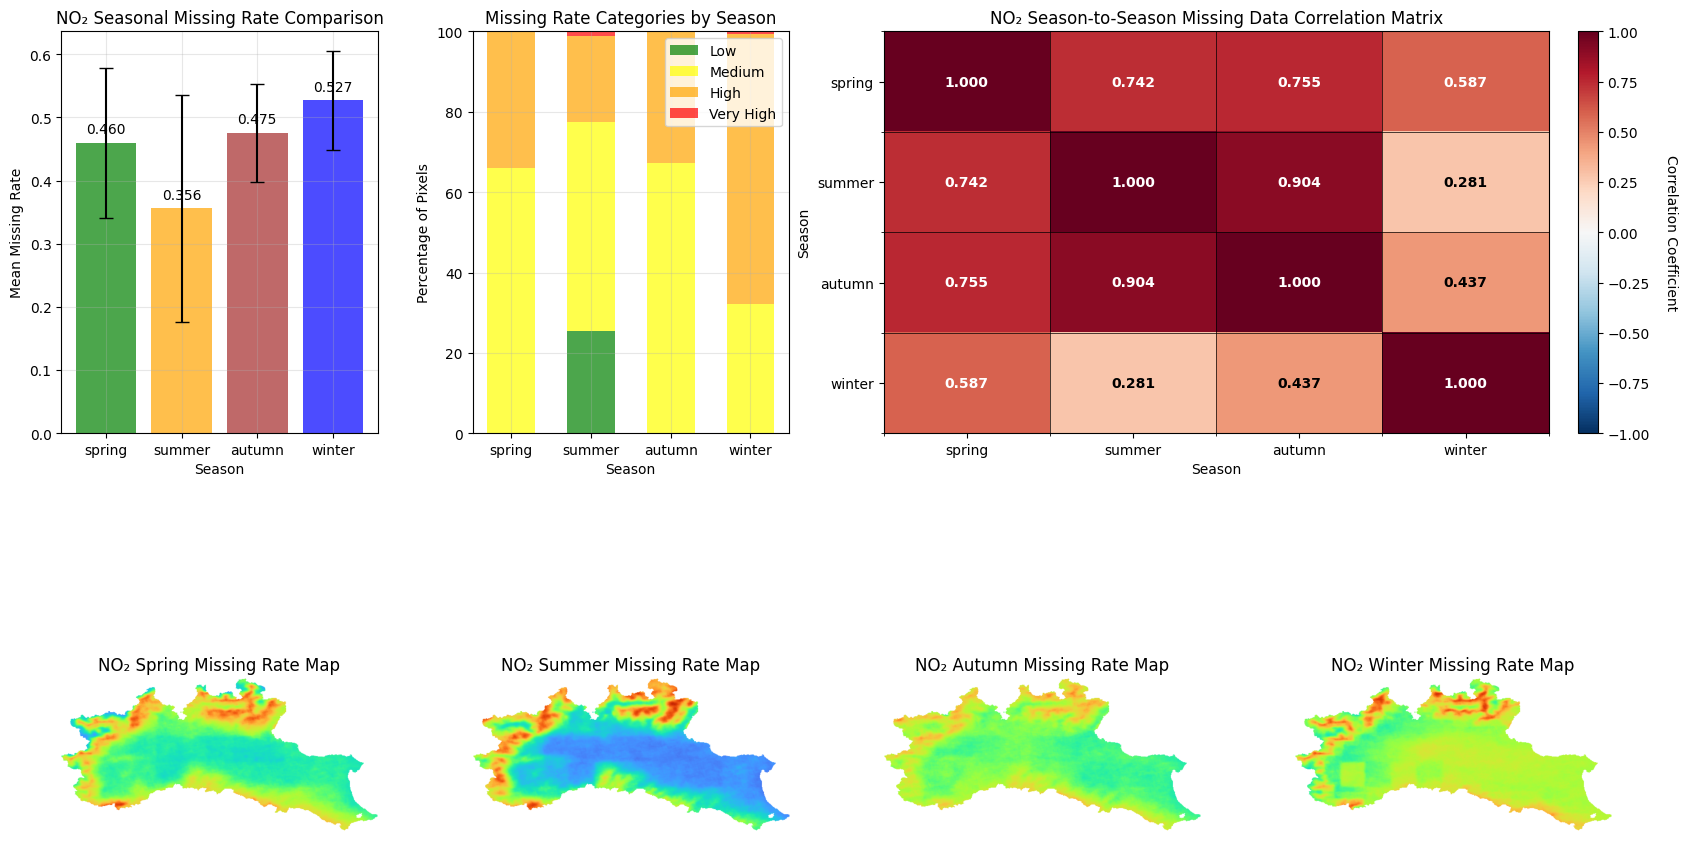


📋 NO2 Season-to-Season Correlation Summary Report

📊 Overall Statistics:
   Seasons analyzed: 4
   Seasons: ['spring', 'summer', 'autumn', 'winter']

🌿 Seasonal Statistics:
   Spring:
     Total days: 460
     Valid pixels: 94,666
     Mean missing: 0.460 (46.0%)
     Std missing: 0.119
     P90 missing: 0.637 (63.7%)
   Summer:
     Total days: 460
     Valid pixels: 94,666
     Mean missing: 0.356 (35.6%)
     Std missing: 0.180
     P90 missing: 0.654 (65.4%)
   Autumn:
     Total days: 455
     Valid pixels: 94,666
     Mean missing: 0.475 (47.5%)
     Std missing: 0.078
     P90 missing: 0.596 (59.6%)
   Winter:
     Total days: 451
     Valid pixels: 94,666
     Mean missing: 0.527 (52.7%)
     Std missing: 0.079
     P90 missing: 0.627 (62.7%)

🔗 Season-to-Season Correlation Analysis:
   Correlation Matrix:
       Season  spring  summer  autumn  winter
       spring   1.000   0.742   0.755   0.587
       summer   0.742   1.000   0.904   0.281
       autumn   0.755   0.904   1.0

In [ ]:
#!/usr/bin/env python3
"""
NO2 Season-to-Season Correlation Analysis

Based on the user's existing seasonal analysis code,
this script analyzes season-to-season correlations in NO2 missing patterns.
"""

import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import os

class NO2SeasonToSeasonCorrelation:
    """Analyze season-to-season correlations in NO2 missing patterns"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.file_template = os.path.join(base_path, "GEE_NO2", "NO2_Daily_Multiband_{}.tif")
        self.aoi_path = os.path.join(base_path, "AOI", "delimitazione_distretto.shp")
        self.years = [2019, 2020, 2021, 2022, 2023]

        # Define seasons
        self.seasons = {
            'spring': [3, 4, 5],    # March, April, May
            'summer': [6, 7, 8],    # June, July, August
            'autumn': [9, 10, 11],  # September, October, November
            'winter': [12, 1, 2]    # December, January, February
        }

        print("🌸 NO2 Season-to-Season Correlation Analyzer")
        print(f"📁 File template: {self.file_template}")
        print(f"📁 AOI: {self.aoi_path}")
        print(f"📅 Years: {self.years}")
        print(f"🌿 Seasons: {list(self.seasons.keys())}")

    def load_aoi_mask(self, transform, out_shape):
        """Load AOI mask"""
        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_mask = geometry_mask([aoi.geometry.union_all()],
                                   transform=transform,
                                   invert=True,
                                   out_shape=out_shape)
            print(f"✅ AOI mask loaded: {aoi_mask.shape}")
            return aoi_mask
        except Exception as e:
            print(f"❌ Error loading AOI: {e}")
            return None

    def get_season_indices(self, year, season_months):
        """Get day indices for a specific season in a year"""
        days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
        season_indices = []

        for month in season_months:
            if month == 12:  # December (previous year)
                month_start = sum(days_in_month[:11])  # Jan-Nov
            elif month == 1:  # January
                month_start = 0
            elif month == 2:  # February
                month_start = days_in_month[0]  # January
            else:  # March-November
                month_start = sum(days_in_month[:month-1])

            month_end = month_start + days_in_month[month-1]
            season_indices.extend(range(month_start, month_end))

        return season_indices

    def analyze_season_missing_patterns(self, season_name, season_months):
        """Analyze missing patterns for a specific season across all years"""
        print(f"\n🌿 Analyzing {season_name}...")

        # Initialize variables for gap statistics
        sum_gap = None
        total_season_days = 0
        seasonal_data = {}

        for year in self.years:
            file_path = self.file_template.format(year)

            if not os.path.exists(file_path):
                print(f"   ❌ File not found: {file_path}")
                continue

            try:
                with rasterio.open(file_path) as src:
                    bands = src.read()  # shape: (days, height, width)
                    season_idx = self.get_season_indices(year, season_months)

                    # Ensure indices are within bounds
                    valid_idx = [i for i in season_idx if i < bands.shape[0]]
                    if len(valid_idx) == 0:
                        print(f"   ⚠️ No valid days for {season_name} {year}")
                        continue

                    season_bands = bands[valid_idx, :, :]
                    print(f"   {year} {season_name} bands: {season_bands.shape}")

                    # Missing if value <= 0 or NaN
                    mask = (season_bands <= 0) | np.isnan(season_bands)
                    yearly_gap = np.sum(mask, axis=0)  # Missing days per pixel

                    # Store yearly data
                    seasonal_data[year] = {
                        'gap_ratio': yearly_gap / season_bands.shape[0],
                        'total_days': season_bands.shape[0],
                        'missing_days': yearly_gap
                    }

                    if sum_gap is None:
                        sum_gap = yearly_gap
                    else:
                        sum_gap += yearly_gap

                    total_season_days += season_bands.shape[0]

            except Exception as e:
                print(f"   ❌ Error processing {season_name} {year}: {e}")
                continue

        if sum_gap is None:
            print(f"   ❌ No valid data for {season_name}")
            return None

        # Calculate overall season missing ratio
        gap_ratio_season = sum_gap / total_season_days

        # Get spatial info from last available year
        for year in reversed(self.years):
            file_path = self.file_template.format(year)
            if os.path.exists(file_path):
                try:
                    with rasterio.open(file_path) as src:
                        bounds = src.bounds
                        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
                        transform = src.transform
                        out_shape = (src.height, src.width)
                        break
                except:
                    continue

        # Load AOI mask
        aoi_mask = self.load_aoi_mask(transform, out_shape)

        if aoi_mask is not None:
            # Apply AOI mask
            gap_ratio_season_aoi = ma.masked_where(~aoi_mask, gap_ratio_season)

            # Calculate statistics
            valid_data = gap_ratio_season_aoi.compressed()

            if len(valid_data) > 0:
                season_stats = {
                    'season': season_name,
                    'total_days': total_season_days,
                    'valid_pixels': len(valid_data),
                    'mean_missing': np.mean(valid_data),
                    'median_missing': np.median(valid_data),
                    'std_missing': np.std(valid_data),
                    'min_missing': np.min(valid_data),
                    'max_missing': np.max(valid_data),
                    'p90_missing': np.percentile(valid_data, 90),
                    'gap_ratio': gap_ratio_season,
                    'aoi_mask': aoi_mask,
                    'extent': extent,
                    'transform': transform,
                    'yearly_data': seasonal_data
                }

                # Missing rate categories
                season_stats['low_missing'] = np.sum(valid_data < 0.2)
                season_stats['medium_missing'] = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
                season_stats['high_missing'] = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
                season_stats['very_high_missing'] = np.sum(valid_data >= 0.8)

                print(f"   ✅ Valid pixels: {len(valid_data):,}")
                print(f"   📊 Mean missing: {np.mean(valid_data):.3f} ({np.mean(valid_data)*100:.1f}%)")
                print(f"   📊 Std missing: {np.std(valid_data):.3f}")

                return season_stats
            else:
                print(f"   ⚠️ No valid data after AOI masking")
                return None
        else:
            print(f"   ❌ AOI mask not available")
            return None

    def calculate_season_to_season_correlations(self, seasonal_stats):
        """Calculate season-to-season correlations"""
        print(f"\n🔗 Calculating Season-to-Season Correlations")
        print("=" * 50)

        if len(seasonal_stats) < 2:
            print("❌ Need at least 2 seasons for correlation analysis")
            return None

        # Create season-to-season correlation matrix
        seasons = list(seasonal_stats.keys())
        n_seasons = len(seasons)
        correlation_matrix = np.ones((n_seasons, n_seasons))  # Initialize with 1s on diagonal

        print(f"📊 Season-to-Season Correlation Matrix:")
        print(f"   Calculating correlations between {n_seasons} seasons...")

        # Calculate pairwise correlations
        for i in range(n_seasons):
            for j in range(i+1, n_seasons):
                season_i, season_j = seasons[i], seasons[j]

                # Get gap ratios for both seasons
                gap_ratio_i = seasonal_stats[season_i]['gap_ratio']
                gap_ratio_j = seasonal_stats[season_j]['gap_ratio']
                aoi_mask_i = seasonal_stats[season_i]['aoi_mask']
                aoi_mask_j = seasonal_stats[season_j]['aoi_mask']

                # Apply AOI masks
                masked_i = ma.masked_where(~aoi_mask_i, gap_ratio_i)
                masked_j = ma.masked_where(~aoi_mask_j, gap_ratio_j)

                # Get valid data (where both seasons have valid data)
                valid_mask = ~(masked_i.mask | masked_j.mask)
                if np.sum(valid_mask) > 100:  # Need sufficient data points
                    valid_data_i = masked_i[valid_mask].compressed()
                    valid_data_j = masked_j[valid_mask].compressed()

                    # Calculate correlation
                    if len(valid_data_i) > 0 and len(valid_data_j) > 0:
                        corr_coef, p_value = pearsonr(valid_data_i, valid_data_j)
                        correlation_matrix[i, j] = corr_coef
                        correlation_matrix[j, i] = corr_coef  # Symmetric matrix

                        print(f"   {season_i} vs {season_j}: r={corr_coef:.3f} (n={len(valid_data_i)})")
                    else:
                        print(f"   {season_i} vs {season_j}: No valid data")
                        correlation_matrix[i, j] = np.nan
                        correlation_matrix[j, i] = np.nan
                else:
                    print(f"   {season_i} vs {season_j}: Insufficient overlap")
                    correlation_matrix[i, j] = np.nan
                    correlation_matrix[j, i] = np.nan

        return {
            'correlation_matrix': correlation_matrix,
            'seasons': seasons
        }

    def create_seasonal_visualization(self, seasonal_stats, correlations):
        """Create seasonal visualization"""
        print(f"\n📊 Creating Seasonal Visualization")
        print("=" * 40)

        if not seasonal_stats:
            print("❌ No data for visualization")
            return

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))

        # Create subplot layout - 2x4 grid to accommodate all 4 seasons
        gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

        # Plot 1: Seasonal missing rate comparison
        ax1 = fig.add_subplot(gs[0, 0])
        seasons = list(seasonal_stats.keys())
        mean_missing = [seasonal_stats[s]['mean_missing'] for s in seasons]
        std_missing = [seasonal_stats[s]['std_missing'] for s in seasons]

        bars = ax1.bar(seasons, mean_missing, color=['green', 'orange', 'brown', 'blue'], alpha=0.7)
        ax1.errorbar(seasons, mean_missing, yerr=std_missing, fmt='none', color='black', capsize=5)
        ax1.set_xlabel('Season')
        ax1.set_ylabel('Mean Missing Rate')
        ax1.set_title('NO₂ Seasonal Missing Rate Comparison')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, mean_val in zip(bars, mean_missing):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{mean_val:.3f}', ha='center', va='bottom')

        # Plot 2: Seasonal missing rate categories
        ax2 = fig.add_subplot(gs[0, 1])

        # Prepare data for stacked bar chart
        low_pct = [seasonal_stats[s]['low_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]
        medium_pct = [seasonal_stats[s]['medium_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]
        high_pct = [seasonal_stats[s]['high_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]
        very_high_pct = [seasonal_stats[s]['very_high_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]

        width = 0.6
        x = np.arange(len(seasons))

        ax2.bar(x, low_pct, width, label='Low', color='green', alpha=0.7)
        ax2.bar(x, medium_pct, width, bottom=low_pct, label='Medium', color='yellow', alpha=0.7)
        ax2.bar(x, high_pct, width, bottom=np.array(low_pct)+np.array(medium_pct),
                label='High', color='orange', alpha=0.7)
        ax2.bar(x, very_high_pct, width,
                bottom=np.array(low_pct)+np.array(medium_pct)+np.array(high_pct),
                label='Very High', color='red', alpha=0.7)

        ax2.set_xlabel('Season')
        ax2.set_ylabel('Percentage of Pixels')
        ax2.set_title('Missing Rate Categories by Season')
        ax2.set_xticks(x)
        ax2.set_xticklabels(seasons)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Season-to-Season Correlation Matrix Heatmap
        ax3 = fig.add_subplot(gs[0, 2:4])  # Span across columns 2-3

        if correlations and 'correlation_matrix' in correlations:
            corr_matrix = correlations['correlation_matrix']
            corr_seasons = correlations['seasons']

            # Create heatmap
            im = ax3.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

            # Set ticks and labels
            ax3.set_xticks(range(len(corr_seasons)))
            ax3.set_yticks(range(len(corr_seasons)))
            ax3.set_xticklabels(corr_seasons)
            ax3.set_yticklabels(corr_seasons)

            # Add correlation values as text
            for i in range(len(corr_seasons)):
                for j in range(len(corr_seasons)):
                    if not np.isnan(corr_matrix[i, j]):
                        text_color = 'white' if abs(corr_matrix[i, j]) > 0.5 else 'black'
                        ax3.text(j, i, f'{corr_matrix[i, j]:.3f}',
                                ha='center', va='center', color=text_color, fontweight='bold')
                    else:
                        ax3.text(j, i, 'N/A', ha='center', va='center', color='gray')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
            cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

            ax3.set_title('NO₂ Season-to-Season Missing Data Correlation Matrix')
            ax3.set_xlabel('Season')
            ax3.set_ylabel('Season')

            # Add grid
            ax3.set_xticks(np.arange(-0.5, len(corr_seasons), 1), minor=True)
            ax3.set_yticks(np.arange(-0.5, len(corr_seasons), 1), minor=True)
            ax3.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

        # Plot 4-6: Individual season maps (bottom row)
        for idx, (season_name, season_stats) in enumerate(seasonal_stats.items()):
            if idx >= 4:  # Show all 4 seasons
                break

            ax = fig.add_subplot(gs[1, idx])

            # Create masked data for visualization
            gap_ratio = season_stats['gap_ratio']
            aoi_mask = season_stats['aoi_mask']
            extent = season_stats['extent']

            gap_ratio_aoi = ma.masked_where(~aoi_mask, gap_ratio)

            # Plot
            im = ax.imshow(gap_ratio_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)
            im.cmap.set_bad(color='white')

            ax.set_title(f'NO₂ {season_name.capitalize()} Missing Rate Map')
            ax.axis('off')

        plt.tight_layout()

        # Save figure
        output_path = 'NO2_Season_to_Season_Correlation_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Figure saved: {output_path}")

        plt.show()

    def generate_seasonal_report(self, seasonal_stats, correlations):
        """Generate seasonal analysis report"""
        print(f"\n📋 NO2 Season-to-Season Correlation Summary Report")
        print("=" * 60)

        if not seasonal_stats:
            print("❌ No data available for summary")
            return

        # Overall statistics
        print(f"\n📊 Overall Statistics:")
        print(f"   Seasons analyzed: {len(seasonal_stats)}")
        print(f"   Seasons: {list(seasonal_stats.keys())}")

        # Seasonal statistics
        print(f"\n🌿 Seasonal Statistics:")
        for season_name, stats in seasonal_stats.items():
            print(f"   {season_name.capitalize()}:")
            print(f"     Total days: {stats['total_days']}")
            print(f"     Valid pixels: {stats['valid_pixels']:,}")
            print(f"     Mean missing: {stats['mean_missing']:.3f} ({stats['mean_missing']*100:.1f}%)")
            print(f"     Std missing: {stats['std_missing']:.3f}")
            print(f"     P90 missing: {stats['p90_missing']:.3f} ({stats['p90_missing']*100:.1f}%)")

        # Correlation results
        if correlations:
            print(f"\n🔗 Season-to-Season Correlation Analysis:")
            corr_matrix = correlations['correlation_matrix']
            corr_seasons = correlations['seasons']

            print(f"   Correlation Matrix:")
            print(f"     {'Season':>8}", end="")
            for season in corr_seasons:
                print(f"{season:>8}", end="")
            print()

            for i, season in enumerate(corr_seasons):
                print(f"     {season:>8}", end="")
                for j in range(len(corr_seasons)):
                    if not np.isnan(corr_matrix[i, j]):
                        print(f"{corr_matrix[i, j]:>8.3f}", end="")
                    else:
                        print(f"{'N/A':>8}", end="")
                print()

            # Find highest and lowest correlations
            off_diagonal = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
            valid_corrs = off_diagonal[~np.isnan(off_diagonal)]

            if len(valid_corrs) > 0:
                max_corr_idx = np.argmax(valid_corrs)
                min_corr_idx = np.argmin(valid_corrs)

                triu_indices = np.triu_indices_from(corr_matrix, k=1)
                max_corr_seasons = (corr_seasons[triu_indices[0][max_corr_idx]],
                                  corr_seasons[triu_indices[1][max_corr_idx]])
                min_corr_seasons = (corr_seasons[triu_indices[0][min_corr_idx]],
                                  corr_seasons[triu_indices[1][min_corr_idx]])

                print(f"\n   Key Findings:")
                print(f"     Highest correlation: {valid_corrs[max_corr_idx]:.3f} ({max_corr_seasons[0]} vs {max_corr_seasons[1]})")
                print(f"     Lowest correlation: {valid_corrs[min_corr_idx]:.3f} ({min_corr_seasons[0]} vs {min_corr_seasons[1]})")
                print(f"     Average correlation: {np.mean(valid_corrs):.3f}")

        # Recommendations
        print(f"\n💡 Recommendations:")
        print("   🔄 Consider seasonal patterns in gap-filling strategies")
        print("   📈 Monitor seasonal variations for data quality assessment")
        print("   🎯 Use seasonal correlations to improve temporal modeling")
        print("   🌡️ Account for seasonal effects in model training")

    def run_analysis(self):
        """Run complete season-to-season correlation analysis"""
        print("🚀 Starting NO2 Season-to-Season Correlation Analysis")
        print("=" * 60)

        # Analyze each season
        seasonal_stats = {}
        for season_name, season_months in self.seasons.items():
            stats = self.analyze_season_missing_patterns(season_name, season_months)
            if stats:
                seasonal_stats[season_name] = stats

        if not seasonal_stats:
            print("❌ No valid data found for any season")
            return None

        # Calculate correlations
        correlations = self.calculate_season_to_season_correlations(seasonal_stats)

        # Create visualization
        self.create_seasonal_visualization(seasonal_stats, correlations)

        # Generate report
        self.generate_seasonal_report(seasonal_stats, correlations)

        print(f"\n🎉 Analysis completed!")
        return {
            'seasonal_stats': seasonal_stats,
            'correlations': correlations
        }


def main():
    """Main function"""
    print("🚀 NO2 Season-to-Season Correlation Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = NO2SeasonToSeasonCorrelation()

    # Run analysis
    results = analyzer.run_analysis()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualization saved as PNG file")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()


# 4. SO2 Season-to-Season Correlation Analysis

🚀 SO2 Season-to-Season Correlation Analysis
🌸 SO2 Season-to-Season Correlation Analyzer
📁 File template: /content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_{}.tif
📁 AOI: /content/drive/MyDrive/AOI/delimitazione_distretto.shp
📅 Years: [2019, 2020, 2021, 2022, 2023]
🌿 Seasons: ['spring', 'summer', 'autumn', 'winter']
🚀 Starting SO2 Season-to-Season Correlation Analysis

🌿 Analyzing spring...
   2019 spring bands: (92, 300, 621)
   2020 spring bands: (92, 300, 621)
   2021 spring bands: (92, 300, 621)
   2022 spring bands: (92, 300, 621)
   2023 spring bands: (92, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.725 (72.5%)
   📊 Std missing: 0.121

🌿 Analyzing summer...
   2019 summer bands: (92, 300, 621)
   2020 summer bands: (92, 300, 621)
   2021 summer bands: (92, 300, 621)
   2022 summer bands: (92, 300, 621)
   2023 summer bands: (92, 300, 621)
✅ AOI mask loaded: (300, 621)
   ✅ Valid pixels: 94,666
   📊 Mean missing: 0.643 (64.3%)
   📊 Std mis

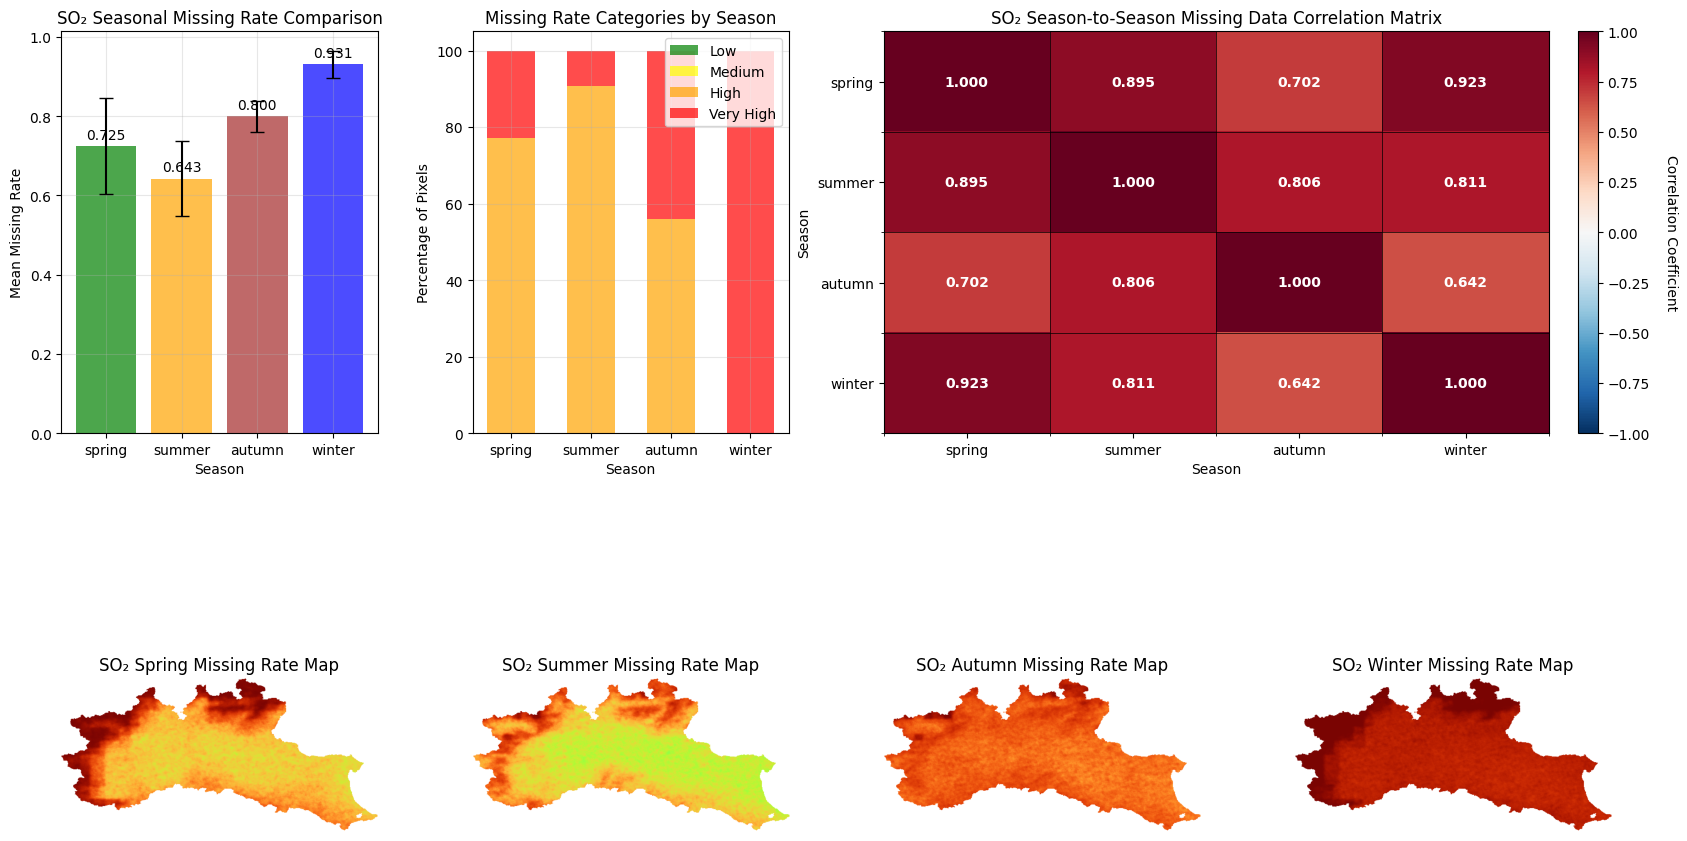


📋 SO2 Season-to-Season Correlation Summary Report

📊 Overall Statistics:
   Seasons analyzed: 4
   Seasons: ['spring', 'summer', 'autumn', 'winter']

🌿 Seasonal Statistics:
   Spring:
     Total days: 460
     Valid pixels: 94,666
     Mean missing: 0.725 (72.5%)
     Std missing: 0.121
     P90 missing: 0.957 (95.7%)
   Summer:
     Total days: 460
     Valid pixels: 94,666
     Mean missing: 0.643 (64.3%)
     Std missing: 0.095
     P90 missing: 0.793 (79.3%)
   Autumn:
     Total days: 455
     Valid pixels: 94,666
     Mean missing: 0.800 (80.0%)
     Std missing: 0.039
     P90 missing: 0.846 (84.6%)
   Winter:
     Total days: 451
     Valid pixels: 94,666
     Mean missing: 0.931 (93.1%)
     Std missing: 0.035
     P90 missing: 1.000 (100.0%)

🔗 Season-to-Season Correlation Analysis:
   Correlation Matrix:
       Season  spring  summer  autumn  winter
       spring   1.000   0.895   0.702   0.923
       summer   0.895   1.000   0.806   0.811
       autumn   0.702   0.806   1.

In [ ]:
#!/usr/bin/env python3
"""
SO2 Season-to-Season Correlation Analysis

Based on the NO2 seasonal analysis, this script analyzes season-to-season
correlations in SO2 missing patterns.
"""

import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from rasterio.features import geometry_mask
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import os

class SO2SeasonToSeasonCorrelation:
    """Analyze season-to-season correlations in SO2 missing patterns"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.file_template = os.path.join(base_path, "GEE_SO2", "SO2_Daily_Multiband_{}.tif")
        self.aoi_path = os.path.join(base_path, "AOI", "delimitazione_distretto.shp")
        self.years = [2019, 2020, 2021, 2022, 2023]

        # Define seasons
        self.seasons = {
            'spring': [3, 4, 5],    # March, April, May
            'summer': [6, 7, 8],    # June, July, August
            'autumn': [9, 10, 11],  # September, October, November
            'winter': [12, 1, 2]    # December, January, February
        }

        print("🌸 SO2 Season-to-Season Correlation Analyzer")
        print(f"📁 File template: {self.file_template}")
        print(f"📁 AOI: {self.aoi_path}")
        print(f"📅 Years: {self.years}")
        print(f"🌿 Seasons: {list(self.seasons.keys())}")

    def load_aoi_mask(self, transform, out_shape):
        """Load AOI mask"""
        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_mask = geometry_mask([aoi.geometry.union_all()],
                                   transform=transform,
                                   invert=True,
                                   out_shape=out_shape)
            print(f"✅ AOI mask loaded: {aoi_mask.shape}")
            return aoi_mask
        except Exception as e:
            print(f"❌ Error loading AOI: {e}")
            return None

    def get_season_indices(self, year, season_months):
        """Get day indices for a specific season in a year"""
        days_in_month = [calendar.monthrange(year, m)[1] for m in range(1, 13)]
        season_indices = []

        for month in season_months:
            if month == 12:  # December (previous year)
                month_start = sum(days_in_month[:11])  # Jan-Nov
            elif month == 1:  # January
                month_start = 0
            elif month == 2:  # February
                month_start = days_in_month[0]  # January
            else:  # March-November
                month_start = sum(days_in_month[:month-1])

            month_end = month_start + days_in_month[month-1]
            season_indices.extend(range(month_start, month_end))

        return season_indices

    def analyze_season_missing_patterns(self, season_name, season_months):
        """Analyze missing patterns for a specific season across all years"""
        print(f"\n🌿 Analyzing {season_name}...")

        # Initialize variables for gap statistics
        sum_gap = None
        total_season_days = 0
        seasonal_data = {}

        for year in self.years:
            file_path = self.file_template.format(year)

            if not os.path.exists(file_path):
                print(f"   ❌ File not found: {file_path}")
                continue

            try:
                with rasterio.open(file_path) as src:
                    bands = src.read()  # shape: (days, height, width)
                    season_idx = self.get_season_indices(year, season_months)

                    # Ensure indices are within bounds
                    valid_idx = [i for i in season_idx if i < bands.shape[0]]
                    if len(valid_idx) == 0:
                        print(f"   ⚠️ No valid days for {season_name} {year}")
                        continue

                    season_bands = bands[valid_idx, :, :]
                    print(f"   {year} {season_name} bands: {season_bands.shape}")

                    # Missing if value <= 0 or NaN
                    mask = (season_bands <= 0) | np.isnan(season_bands)
                    yearly_gap = np.sum(mask, axis=0)  # Missing days per pixel

                    # Store yearly data
                    seasonal_data[year] = {
                        'gap_ratio': yearly_gap / season_bands.shape[0],
                        'total_days': season_bands.shape[0],
                        'missing_days': yearly_gap
                    }

                    if sum_gap is None:
                        sum_gap = yearly_gap
                    else:
                        sum_gap += yearly_gap

                    total_season_days += season_bands.shape[0]

            except Exception as e:
                print(f"   ❌ Error processing {season_name} {year}: {e}")
                continue

        if sum_gap is None:
            print(f"   ❌ No valid data for {season_name}")
            return None

        # Calculate overall season missing ratio
        gap_ratio_season = sum_gap / total_season_days

        # Get spatial info from last available year
        for year in reversed(self.years):
            file_path = self.file_template.format(year)
            if os.path.exists(file_path):
                try:
                    with rasterio.open(file_path) as src:
                        bounds = src.bounds
                        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
                        transform = src.transform
                        out_shape = (src.height, src.width)
                        break
                except:
                    continue

        # Load AOI mask
        aoi_mask = self.load_aoi_mask(transform, out_shape)

        if aoi_mask is not None:
            # Apply AOI mask
            gap_ratio_season_aoi = ma.masked_where(~aoi_mask, gap_ratio_season)

            # Calculate statistics
            valid_data = gap_ratio_season_aoi.compressed()

            if len(valid_data) > 0:
                season_stats = {
                    'season': season_name,
                    'total_days': total_season_days,
                    'valid_pixels': len(valid_data),
                    'mean_missing': np.mean(valid_data),
                    'median_missing': np.median(valid_data),
                    'std_missing': np.std(valid_data),
                    'min_missing': np.min(valid_data),
                    'max_missing': np.max(valid_data),
                    'p90_missing': np.percentile(valid_data, 90),
                    'gap_ratio': gap_ratio_season,
                    'aoi_mask': aoi_mask,
                    'extent': extent,
                    'transform': transform,
                    'yearly_data': seasonal_data
                }

                # Missing rate categories
                season_stats['low_missing'] = np.sum(valid_data < 0.2)
                season_stats['medium_missing'] = np.sum((valid_data >= 0.2) & (valid_data < 0.5))
                season_stats['high_missing'] = np.sum((valid_data >= 0.5) & (valid_data < 0.8))
                season_stats['very_high_missing'] = np.sum(valid_data >= 0.8)

                print(f"   ✅ Valid pixels: {len(valid_data):,}")
                print(f"   📊 Mean missing: {np.mean(valid_data):.3f} ({np.mean(valid_data)*100:.1f}%)")
                print(f"   📊 Std missing: {np.std(valid_data):.3f}")

                return season_stats
            else:
                print(f"   ⚠️ No valid data after AOI masking")
                return None
        else:
            print(f"   ❌ AOI mask not available")
            return None

    def calculate_season_to_season_correlations(self, seasonal_stats):
        """Calculate season-to-season correlations"""
        print(f"\n🔗 Calculating Season-to-Season Correlations")
        print("=" * 50)

        if len(seasonal_stats) < 2:
            print("❌ Need at least 2 seasons for correlation analysis")
            return None

        # Create season-to-season correlation matrix
        seasons = list(seasonal_stats.keys())
        n_seasons = len(seasons)
        correlation_matrix = np.ones((n_seasons, n_seasons))  # Initialize with 1s on diagonal

        print(f"📊 Season-to-Season Correlation Matrix:")
        print(f"   Calculating correlations between {n_seasons} seasons...")

        # Calculate pairwise correlations
        for i in range(n_seasons):
            for j in range(i+1, n_seasons):
                season_i, season_j = seasons[i], seasons[j]

                # Get gap ratios for both seasons
                gap_ratio_i = seasonal_stats[season_i]['gap_ratio']
                gap_ratio_j = seasonal_stats[season_j]['gap_ratio']
                aoi_mask_i = seasonal_stats[season_i]['aoi_mask']
                aoi_mask_j = seasonal_stats[season_j]['aoi_mask']

                # Apply AOI masks
                masked_i = ma.masked_where(~aoi_mask_i, gap_ratio_i)
                masked_j = ma.masked_where(~aoi_mask_j, gap_ratio_j)

                # Get valid data (where both seasons have valid data)
                valid_mask = ~(masked_i.mask | masked_j.mask)
                if np.sum(valid_mask) > 100:  # Need sufficient data points
                    valid_data_i = masked_i[valid_mask].compressed()
                    valid_data_j = masked_j[valid_mask].compressed()

                    # Calculate correlation
                    if len(valid_data_i) > 0 and len(valid_data_j) > 0:
                        corr_coef, p_value = pearsonr(valid_data_i, valid_data_j)
                        correlation_matrix[i, j] = corr_coef
                        correlation_matrix[j, i] = corr_coef  # Symmetric matrix

                        print(f"   {season_i} vs {season_j}: r={corr_coef:.3f} (n={len(valid_data_i)})")
                    else:
                        print(f"   {season_i} vs {season_j}: No valid data")
                        correlation_matrix[i, j] = np.nan
                        correlation_matrix[j, i] = np.nan
                else:
                    print(f"   {season_i} vs {season_j}: Insufficient overlap")
                    correlation_matrix[i, j] = np.nan
                    correlation_matrix[j, i] = np.nan

        return {
            'correlation_matrix': correlation_matrix,
            'seasons': seasons
        }

    def create_seasonal_visualization(self, seasonal_stats, correlations):
        """Create seasonal visualization"""
        print(f"\n📊 Creating Seasonal Visualization")
        print("=" * 40)

        if not seasonal_stats:
            print("❌ No data for visualization")
            return

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))

        # Create subplot layout - 2x4 grid to accommodate all 4 seasons
        gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

        # Plot 1: Seasonal missing rate comparison
        ax1 = fig.add_subplot(gs[0, 0])
        seasons = list(seasonal_stats.keys())
        mean_missing = [seasonal_stats[s]['mean_missing'] for s in seasons]
        std_missing = [seasonal_stats[s]['std_missing'] for s in seasons]

        bars = ax1.bar(seasons, mean_missing, color=['green', 'orange', 'brown', 'blue'], alpha=0.7)
        ax1.errorbar(seasons, mean_missing, yerr=std_missing, fmt='none', color='black', capsize=5)
        ax1.set_xlabel('Season')
        ax1.set_ylabel('Mean Missing Rate')
        ax1.set_title('SO₂ Seasonal Missing Rate Comparison')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, mean_val in zip(bars, mean_missing):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{mean_val:.3f}', ha='center', va='bottom')

        # Plot 2: Seasonal missing rate categories
        ax2 = fig.add_subplot(gs[0, 1])

        # Prepare data for stacked bar chart
        low_pct = [seasonal_stats[s]['low_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]
        medium_pct = [seasonal_stats[s]['medium_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]
        high_pct = [seasonal_stats[s]['high_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]
        very_high_pct = [seasonal_stats[s]['very_high_missing']/seasonal_stats[s]['valid_pixels']*100 for s in seasons]

        width = 0.6
        x = np.arange(len(seasons))

        ax2.bar(x, low_pct, width, label='Low', color='green', alpha=0.7)
        ax2.bar(x, medium_pct, width, bottom=low_pct, label='Medium', color='yellow', alpha=0.7)
        ax2.bar(x, high_pct, width, bottom=np.array(low_pct)+np.array(medium_pct),
                label='High', color='orange', alpha=0.7)
        ax2.bar(x, very_high_pct, width,
                bottom=np.array(low_pct)+np.array(medium_pct)+np.array(high_pct),
                label='Very High', color='red', alpha=0.7)

        ax2.set_xlabel('Season')
        ax2.set_ylabel('Percentage of Pixels')
        ax2.set_title('Missing Rate Categories by Season')
        ax2.set_xticks(x)
        ax2.set_xticklabels(seasons)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Season-to-Season Correlation Matrix Heatmap
        ax3 = fig.add_subplot(gs[0, 2:4])  # Span across columns 2-3

        if correlations and 'correlation_matrix' in correlations:
            corr_matrix = correlations['correlation_matrix']
            corr_seasons = correlations['seasons']

            # Create heatmap
            im = ax3.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

            # Set ticks and labels
            ax3.set_xticks(range(len(corr_seasons)))
            ax3.set_yticks(range(len(corr_seasons)))
            ax3.set_xticklabels(corr_seasons)
            ax3.set_yticklabels(corr_seasons)

            # Add correlation values as text
            for i in range(len(corr_seasons)):
                for j in range(len(corr_seasons)):
                    if not np.isnan(corr_matrix[i, j]):
                        text_color = 'white' if abs(corr_matrix[i, j]) > 0.5 else 'black'
                        ax3.text(j, i, f'{corr_matrix[i, j]:.3f}',
                                ha='center', va='center', color=text_color, fontweight='bold')
                    else:
                        ax3.text(j, i, 'N/A', ha='center', va='center', color='gray')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
            cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

            ax3.set_title('SO₂ Season-to-Season Missing Data Correlation Matrix')
            ax3.set_xlabel('Season')
            ax3.set_ylabel('Season')

            # Add grid
            ax3.set_xticks(np.arange(-0.5, len(corr_seasons), 1), minor=True)
            ax3.set_yticks(np.arange(-0.5, len(corr_seasons), 1), minor=True)
            ax3.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

        # Plot 4-7: Individual season maps (bottom row)
        for idx, (season_name, season_stats) in enumerate(seasonal_stats.items()):
            if idx >= 4:  # Show all 4 seasons
                break

            ax = fig.add_subplot(gs[1, idx])

            # Create masked data for visualization
            gap_ratio = season_stats['gap_ratio']
            aoi_mask = season_stats['aoi_mask']
            extent = season_stats['extent']

            gap_ratio_aoi = ma.masked_where(~aoi_mask, gap_ratio)

            # Plot
            im = ax.imshow(gap_ratio_aoi, extent=extent, cmap='turbo', vmin=0, vmax=1)
            im.cmap.set_bad(color='white')

            ax.set_title(f'SO₂ {season_name.capitalize()} Missing Rate Map')
            ax.axis('off')

        plt.tight_layout()

        # Save figure
        output_path = 'SO2_Season_to_Season_Correlation_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Figure saved: {output_path}")

        plt.show()

    def generate_seasonal_report(self, seasonal_stats, correlations):
        """Generate seasonal analysis report"""
        print(f"\n📋 SO2 Season-to-Season Correlation Summary Report")
        print("=" * 60)

        if not seasonal_stats:
            print("❌ No data available for summary")
            return

        # Overall statistics
        print(f"\n📊 Overall Statistics:")
        print(f"   Seasons analyzed: {len(seasonal_stats)}")
        print(f"   Seasons: {list(seasonal_stats.keys())}")

        # Seasonal statistics
        print(f"\n🌿 Seasonal Statistics:")
        for season_name, stats in seasonal_stats.items():
            print(f"   {season_name.capitalize()}:")
            print(f"     Total days: {stats['total_days']}")
            print(f"     Valid pixels: {stats['valid_pixels']:,}")
            print(f"     Mean missing: {stats['mean_missing']:.3f} ({stats['mean_missing']*100:.1f}%)")
            print(f"     Std missing: {stats['std_missing']:.3f}")
            print(f"     P90 missing: {stats['p90_missing']:.3f} ({stats['p90_missing']*100:.1f}%)")

        # Correlation results
        if correlations:
            print(f"\n🔗 Season-to-Season Correlation Analysis:")
            corr_matrix = correlations['correlation_matrix']
            corr_seasons = correlations['seasons']

            print(f"   Correlation Matrix:")
            print(f"     {'Season':>8}", end="")
            for season in corr_seasons:
                print(f"{season:>8}", end="")
            print()

            for i, season in enumerate(corr_seasons):
                print(f"     {season:>8}", end="")
                for j in range(len(corr_seasons)):
                    if not np.isnan(corr_matrix[i, j]):
                        print(f"{corr_matrix[i, j]:>8.3f}", end="")
                    else:
                        print(f"{'N/A':>8}", end="")
                print()

            # Find highest and lowest correlations
            off_diagonal = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
            valid_corrs = off_diagonal[~np.isnan(off_diagonal)]

            if len(valid_corrs) > 0:
                max_corr_idx = np.argmax(valid_corrs)
                min_corr_idx = np.argmin(valid_corrs)

                triu_indices = np.triu_indices_from(corr_matrix, k=1)
                max_corr_seasons = (corr_seasons[triu_indices[0][max_corr_idx]],
                                  corr_seasons[triu_indices[1][max_corr_idx]])
                min_corr_seasons = (corr_seasons[triu_indices[0][min_corr_idx]],
                                  corr_seasons[triu_indices[1][min_corr_idx]])

                print(f"\n   Key Findings:")
                print(f"     Highest correlation: {valid_corrs[max_corr_idx]:.3f} ({max_corr_seasons[0]} vs {max_corr_seasons[1]})")
                print(f"     Lowest correlation: {valid_corrs[min_corr_idx]:.3f} ({min_corr_seasons[0]} vs {min_corr_seasons[1]})")
                print(f"     Average correlation: {np.mean(valid_corrs):.3f}")

        # Recommendations
        print(f"\n💡 Recommendations:")
        print("   🔄 Consider seasonal patterns in gap-filling strategies")
        print("   📈 Monitor seasonal variations for data quality assessment")
        print("   🎯 Use seasonal correlations to improve temporal modeling")
        print("   🌡️ Account for seasonal effects in model training")

    def run_analysis(self):
        """Run complete season-to-season correlation analysis"""
        print("🚀 Starting SO2 Season-to-Season Correlation Analysis")
        print("=" * 60)

        # Analyze each season
        seasonal_stats = {}
        for season_name, season_months in self.seasons.items():
            stats = self.analyze_season_missing_patterns(season_name, season_months)
            if stats:
                seasonal_stats[season_name] = stats

        if not seasonal_stats:
            print("❌ No valid data found for any season")
            return None

        # Calculate correlations
        correlations = self.calculate_season_to_season_correlations(seasonal_stats)

        # Create visualization
        self.create_seasonal_visualization(seasonal_stats, correlations)

        # Generate report
        self.generate_seasonal_report(seasonal_stats, correlations)

        print(f"\n🎉 Analysis completed!")
        return {
            'seasonal_stats': seasonal_stats,
            'correlations': correlations
        }


def main():
    """Main function"""
    print("🚀 SO2 Season-to-Season Correlation Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = SO2SeasonToSeasonCorrelation()

    # Run analysis
    results = analyzer.run_analysis()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualization saved as PNG file")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()


# 5. Elevation-Gaps Correlation Analysis For NO2 and SO2

🔢 Matrix-based Elevation-Missing Data Analysis
🔢 Matrix-based Elevation-Missing Data Analyzer
📁 Base path: /content/drive/MyDrive
🚀 Starting Comprehensive Matrix Analysis

🚀 Starting Matrix Analysis: NO2

📊 Loading NO2 Data Matrices
   ✅ 2019: 365 days, 300x621 pixels
   ✅ 2020: 366 days, 300x621 pixels
   ✅ 2021: 365 days, 300x621 pixels
   ✅ 2022: 365 days, 300x621 pixels
   ✅ 2023: 365 days, 300x621 pixels
✅ Missing ratio matrix: (300, 621)
   Range: 0.330 - 1.000
   Total days: 1826

🏔️ Loading Elevation Matrix
✅ DEM loaded: (300, 621)
✅ Elevation matrix: (300, 621)
   Range: -6.8 - 4239.5 m

🗺️ Loading AOI Matrix
✅ AOI matrix: (300, 621)
   Valid pixels: 94,666

🔗 Calculating Matrix Correlations
✅ Analyzing 94,666 valid pixels
✅ Pearson r: 0.7688 (p=0.000e+00)
✅ Spearman r: 0.8957 (p=0.000e+00)

📊 Creating Matrix Visualization
✅ Visualization saved: NO2_Matrix_Elevation_Missing_Analysis.png


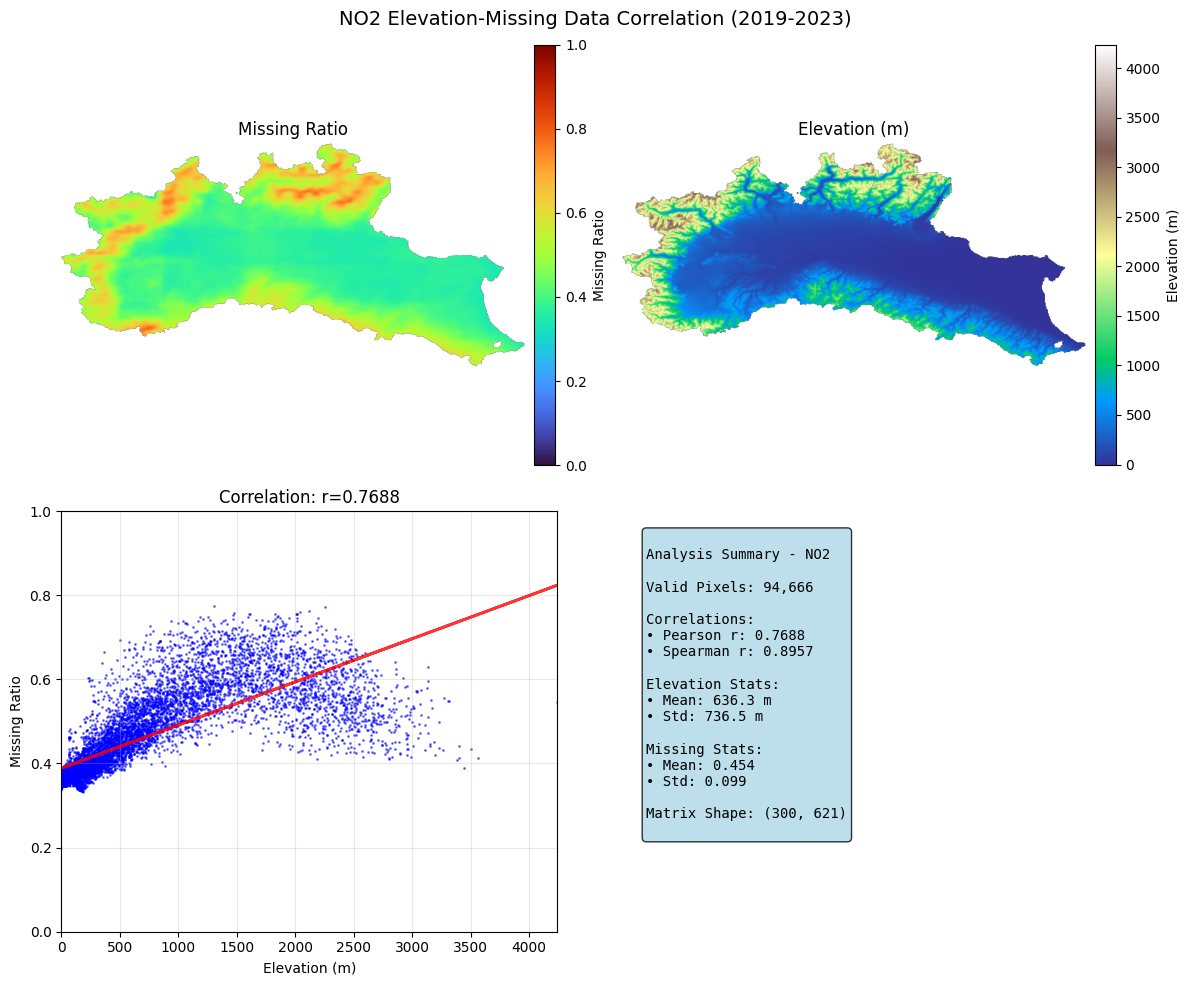


🎉 Matrix analysis completed for NO2!

🚀 Starting Matrix Analysis: SO2

📊 Loading SO2 Data Matrices
   ✅ 2019: 365 days, 300x621 pixels
   ✅ 2020: 366 days, 300x621 pixels
   ✅ 2021: 365 days, 300x621 pixels
   ✅ 2022: 365 days, 300x621 pixels
   ✅ 2023: 365 days, 300x621 pixels
✅ Missing ratio matrix: (300, 621)
   Range: 0.673 - 1.000
   Total days: 1826

🏔️ Loading Elevation Matrix
✅ DEM loaded: (300, 621)
✅ Elevation matrix: (300, 621)
   Range: -6.8 - 4239.5 m

🗺️ Loading AOI Matrix
✅ AOI matrix: (300, 621)
   Valid pixels: 94,666

🔗 Calculating Matrix Correlations
✅ Analyzing 94,666 valid pixels
✅ Pearson r: 0.9198 (p=0.000e+00)
✅ Spearman r: 0.9194 (p=0.000e+00)

📊 Creating Matrix Visualization
✅ Visualization saved: SO2_Matrix_Elevation_Missing_Analysis.png


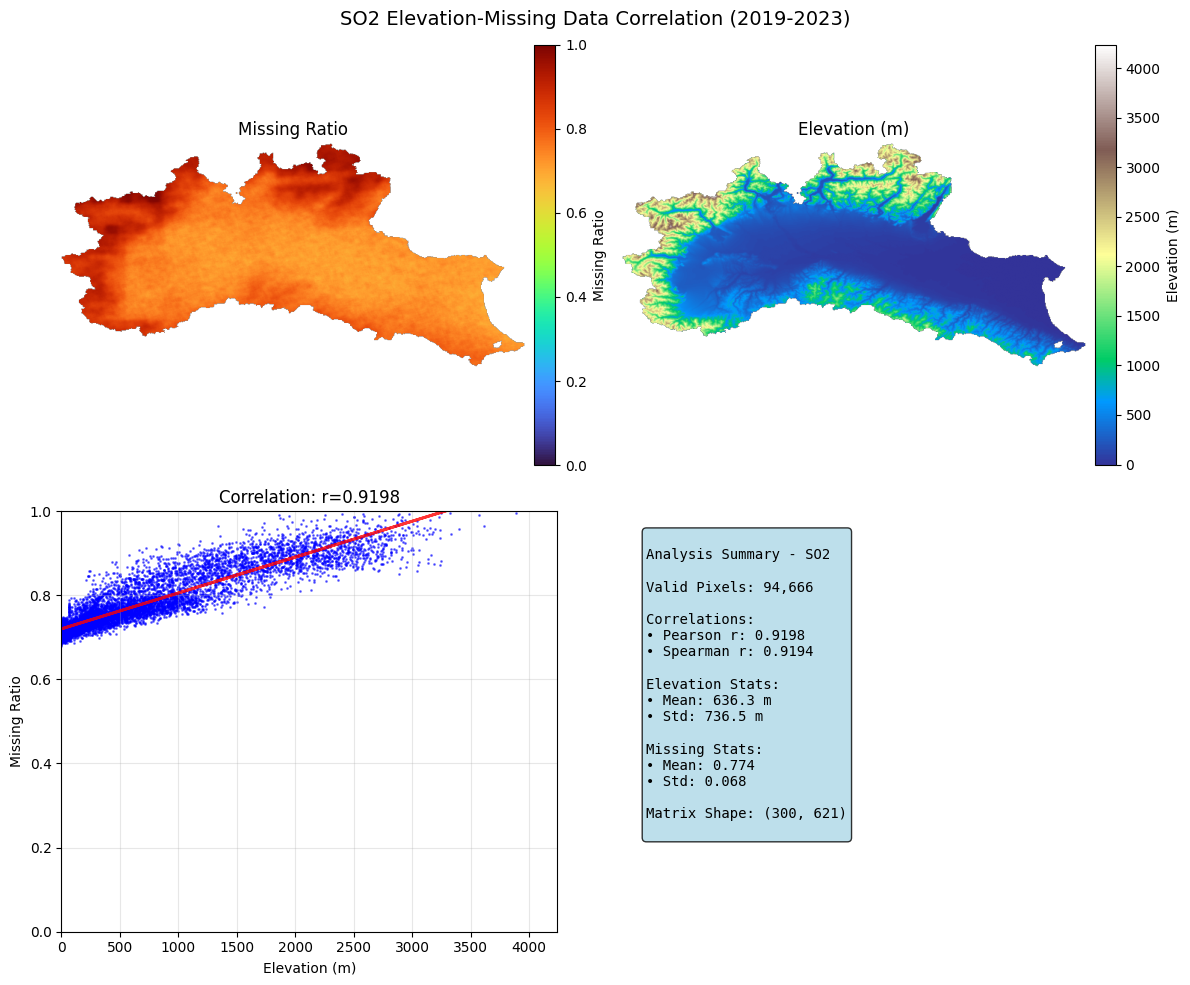


🎉 Matrix analysis completed for SO2!

📋 Matrix Analysis Summary

🌫️ NO2 Results:
   Matrix shape: (300, 621)
   Valid pixels: 94,666
   Pearson r: 0.7688
   Spearman r: 0.8957
   Mean elevation: 636.3 m
   Mean missing: 0.454

🌫️ SO2 Results:
   Matrix shape: (300, 621)
   Valid pixels: 94,666
   Pearson r: 0.9198
   Spearman r: 0.9194
   Mean elevation: 636.3 m
   Mean missing: 0.774

✅ Matrix analysis completed!
📊 Results available in memory
📁 Visualizations saved as PNG files


In [ ]:
#!/usr/bin/env python3
"""
Matrix-based Elevation-Missing Data Correlation Analysis

Simplified analysis using matrix operations for better performance and clarity.
"""

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
from rasterio.warp import reproject, Resampling
from scipy.stats import pearsonr, spearmanr
import os

class MatrixElevationMissingAnalyzer:
    """Matrix-based analyzer for elevation-missing data correlations"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.dem_path = f"{base_path}/Variables/dem_aligned_s5p/dem_s5p_aligned.tif"
        self.aoi_path = f"{base_path}/AOI/delimitazione_distretto.shp"
        self.no2_template = f"{base_path}/GEE_NO2/NO2_Daily_Multiband_{{}}.tif"
        self.so2_template = f"{base_path}/GEE_SO2/SO2_Daily_Multiband_{{}}.tif"
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("🔢 Matrix-based Elevation-Missing Data Analyzer")
        print(f"📁 Base path: {self.base_path}")

    def load_data_matrices(self, pollutant):
        """Load all data as matrices"""
        print(f"\n📊 Loading {pollutant} Data Matrices")
        print("=" * 40)

        file_template = self.no2_template if pollutant == 'NO2' else self.so2_template

        # Initialize matrices
        missing_matrix = None
        total_days = 0
        successful_years = []

        # Load pollutant data
        for year in self.years:
            file_path = file_template.format(year)
            if not os.path.exists(file_path):
                print(f"   ❌ {year}: File not found")
                continue

            try:
                with rasterio.open(file_path) as src:
                    # Read all bands at once (shape: days, height, width)
                    bands = src.read()

                    # Create missing mask (0 or nan = missing)
                    missing_mask = (bands <= 0) | np.isnan(bands)

                    # Sum missing days per pixel
                    yearly_missing = np.sum(missing_mask, axis=0, dtype=np.float32)

                    if missing_matrix is None:
                        missing_matrix = yearly_missing
                        # Store spatial info
                        self.transform = src.transform
                        self.crs = src.crs
                        self.shape = (src.height, src.width)
                        self.bounds = src.bounds
                    else:
                        missing_matrix += yearly_missing

                    total_days += bands.shape[0]
                    successful_years.append(year)
                    print(f"   ✅ {year}: {bands.shape[0]} days, {bands.shape[1]}x{bands.shape[2]} pixels")

            except Exception as e:
                print(f"   ❌ {year}: {e}")
                continue

        if missing_matrix is None:
            print("❌ No valid data found")
            return None

        # Convert to missing ratio matrix
        missing_ratio_matrix = missing_matrix / total_days

        print(f"✅ Missing ratio matrix: {missing_ratio_matrix.shape}")
        print(f"   Range: {np.min(missing_ratio_matrix):.3f} - {np.max(missing_ratio_matrix):.3f}")
        print(f"   Total days: {total_days}")

        return {
            'missing_ratio': missing_ratio_matrix,
            'total_days': total_days,
            'successful_years': successful_years
        }

    def load_elevation_matrix(self):
        """Load elevation as matrix"""
        print(f"\n🏔️ Loading Elevation Matrix")
        print("=" * 30)

        if not os.path.exists(self.dem_path):
            print(f"❌ DEM file not found: {self.dem_path}")
            return None

        try:
            with rasterio.open(self.dem_path) as dem_src:
                print(f"✅ DEM loaded: {dem_src.shape}")

                # Resample DEM to match pollutant grid
                elevation_matrix = np.zeros(self.shape, dtype=np.float32)

                reproject(
                    source=dem_src.read(1),
                    destination=elevation_matrix,
                    src_transform=dem_src.transform,
                    src_crs=dem_src.crs,
                    dst_transform=self.transform,
                    dst_crs=self.crs,
                    resampling=Resampling.bilinear
                )

                print(f"✅ Elevation matrix: {elevation_matrix.shape}")
                print(f"   Range: {np.min(elevation_matrix):.1f} - {np.max(elevation_matrix):.1f} m")

                return elevation_matrix

        except Exception as e:
            print(f"❌ Error loading DEM: {e.g}")
            return None

    def load_aoi_matrix(self):
        """Load AOI as boolean matrix"""
        print(f"\n🗺️ Loading AOI Matrix")
        print("=" * 25)

        try:
            aoi = gpd.read_file(self.aoi_path)
            aoi_matrix = geometry_mask([aoi.geometry.union_all()],
                                     transform=self.transform,
                                     invert=True,
                                     out_shape=self.shape)

            print(f"✅ AOI matrix: {aoi_matrix.shape}")
            print(f"   Valid pixels: {np.sum(aoi_matrix):,}")

            return aoi_matrix

        except Exception as e:
            print(f"❌ Error loading AOI: {e}")
            return None

    def calculate_matrix_correlations(self, missing_matrix, elevation_matrix, aoi_matrix):
        """Calculate correlations using matrix operations"""
        print(f"\n🔗 Calculating Matrix Correlations")
        print("=" * 35)

        # Apply AOI mask
        missing_masked = np.where(aoi_matrix, missing_matrix, np.nan)
        elevation_masked = np.where(aoi_matrix, elevation_matrix, np.nan)

        # Flatten matrices
        missing_flat = missing_masked.flatten()
        elevation_flat = elevation_masked.flatten()

        # Remove NaN values
        valid_mask = ~(np.isnan(missing_flat) | np.isnan(elevation_flat))
        missing_valid = missing_flat[valid_mask]
        elevation_valid = elevation_flat[valid_mask]

        if len(missing_valid) < 1000:
            print(f"❌ Insufficient valid pixels: {len(missing_valid)}")
            return None

        print(f"✅ Analyzing {len(missing_valid):,} valid pixels")

        # Calculate correlations
        pearson_r, pearson_p = pearsonr(elevation_valid, missing_valid)
        spearman_r, spearman_p = spearmanr(elevation_valid, missing_valid)

        # Calculate statistics
        stats = {
            'valid_pixels': len(missing_valid),
            'pearson_r': pearson_r,
            'pearson_p': pearson_p,
            'spearman_r': spearman_r,
            'spearman_p': spearman_p,
            'elevation_mean': np.mean(elevation_valid),
            'elevation_std': np.std(elevation_valid),
            'missing_mean': np.mean(missing_valid),
            'missing_std': np.std(missing_valid)
        }

        print(f"✅ Pearson r: {pearson_r:.4f} (p={pearson_p:.3e})")
        print(f"✅ Spearman r: {spearman_r:.4f} (p={spearman_p:.3e})")

        return stats, missing_valid, elevation_valid

    def create_matrix_visualization(self, pollutant, missing_matrix, elevation_matrix, aoi_matrix, stats, missing_valid, elevation_valid):
        """Create clean matrix-based visualization"""
        print(f"\n📊 Creating Matrix Visualization")
        print("=" * 35)

        # Create figure with proper scaling
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'{pollutant} Elevation-Missing Data Correlation (2019-2023)', fontsize=14)

        # Apply AOI mask for visualization
        missing_vis = np.where(aoi_matrix, missing_matrix, np.nan)
        elevation_vis = np.where(aoi_matrix, elevation_matrix, np.nan)

        # Plot 1: Missing pattern
        ax1 = axes[0, 0]
        im1 = ax1.imshow(missing_vis, cmap='turbo', vmin=0, vmax=1)
        ax1.set_title('Missing Ratio')
        ax1.axis('off')
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
        cbar1.set_label('Missing Ratio')

        # Plot 2: Elevation
        ax2 = axes[0, 1]
        # im2 = ax2.imshow(elevation_vis, cmap='terrain', aspect='auto')
        im2 = ax2.imshow(elevation_vis, cmap='terrain', aspect='equal')
        ax2.set_title('Elevation (m)')
        ax2.axis('off')
        cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
        cbar2.set_label('Elevation (m)')

        # Plot 3: Scatter plot with proper scaling
        ax3 = axes[1, 0]

        # Sample data if too large
        if len(missing_valid) > 10000:
            sample_idx = np.random.choice(len(missing_valid), 10000, replace=False)
            missing_sample = missing_valid[sample_idx]
            elevation_sample = elevation_valid[sample_idx]
        else:
            missing_sample = missing_valid
            elevation_sample = elevation_valid

        # Create scatter plot
        ax3.scatter(elevation_sample, missing_sample, alpha=0.5, s=1, c='blue')

        # Add trend line
        z = np.polyfit(elevation_sample, missing_sample, 1)
        p = np.poly1d(z)
        ax3.plot(elevation_sample, p(elevation_sample), "r-", linewidth=2, alpha=0.8)

        # Set proper scaling
        ax3.set_xlim(0, np.max(elevation_valid))
        ax3.set_ylim(0, 1)  # Full range for missing ratio
        ax3.set_xlabel('Elevation (m)')
        ax3.set_ylabel('Missing Ratio')
        ax3.set_title(f'Correlation: r={stats["pearson_r"]:.4f}')
        ax3.grid(True, alpha=0.3)

        # Plot 4: Statistics summary
        ax4 = axes[1, 1]
        ax4.axis('off')

        # Create summary text
        summary_text = f"""
Analysis Summary - {pollutant}

Valid Pixels: {stats['valid_pixels']:,}

Correlations:
• Pearson r: {stats['pearson_r']:.4f}
• Spearman r: {stats['spearman_r']:.4f}

Elevation Stats:
• Mean: {stats['elevation_mean']:.1f} m
• Std: {stats['elevation_std']:.1f} m

Missing Stats:
• Mean: {stats['missing_mean']:.3f}
• Std: {stats['missing_std']:.3f}

Matrix Shape: {missing_matrix.shape}
        """

        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        plt.tight_layout()

        # Save figure
        output_path = f'{pollutant}_Matrix_Elevation_Missing_Analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"✅ Visualization saved: {output_path}")

        plt.show()

    def run_matrix_analysis(self, pollutant):
        """Run complete matrix-based analysis"""
        print(f"\n🚀 Starting Matrix Analysis: {pollutant}")
        print("=" * 50)

        # Load data matrices
        missing_data = self.load_data_matrices(pollutant)
        if missing_data is None:
            return None

        # Load elevation matrix
        elevation_matrix = self.load_elevation_matrix()
        if elevation_matrix is None:
            return None

        # Load AOI matrix
        aoi_matrix = self.load_aoi_matrix()
        if aoi_matrix is None:
            return None

        # Calculate correlations
        stats, missing_valid, elevation_valid = self.calculate_matrix_correlations(
            missing_data['missing_ratio'], elevation_matrix, aoi_matrix
        )
        if stats is None:
            return None

        # Create visualization
        self.create_matrix_visualization(
            pollutant, missing_data['missing_ratio'], elevation_matrix, aoi_matrix,
            stats, missing_valid, elevation_valid
        )

        print(f"\n🎉 Matrix analysis completed for {pollutant}!")
        return {
            'missing_matrix': missing_data['missing_ratio'],
            'elevation_matrix': elevation_matrix,
            'aoi_matrix': aoi_matrix,
            'stats': stats
        }

    def run_comprehensive_analysis(self):
        """Run analysis for both pollutants"""
        print("🚀 Starting Comprehensive Matrix Analysis")
        print("=" * 60)

        all_results = {}

        for pollutant in ['NO2', 'SO2']:
            result = self.run_matrix_analysis(pollutant)
            all_results[pollutant] = result

        # Generate summary
        self.generate_summary(all_results)

        return all_results

    def generate_summary(self, all_results):
        """Generate summary"""
        print(f"\n📋 Matrix Analysis Summary")
        print("=" * 40)

        for pollutant, result in all_results.items():
            if result is None:
                print(f"\n❌ {pollutant}: Analysis failed")
                continue

            print(f"\n🌫️ {pollutant} Results:")
            print("=" * 25)

            stats = result['stats']
            print(f"   Matrix shape: {result['missing_matrix'].shape}")
            print(f"   Valid pixels: {stats['valid_pixels']:,}")
            print(f"   Pearson r: {stats['pearson_r']:.4f}")
            print(f"   Spearman r: {stats['spearman_r']:.4f}")
            print(f"   Mean elevation: {stats['elevation_mean']:.1f} m")
            print(f"   Mean missing: {stats['missing_mean']:.3f}")


def main():
    """Main function"""
    print("🔢 Matrix-based Elevation-Missing Data Analysis")
    print("=" * 60)

    # Create analyzer
    analyzer = MatrixElevationMissingAnalyzer()

    # Run comprehensive analysis
    results = analyzer.run_comprehensive_analysis()

    if results:
        print(f"\n✅ Matrix analysis completed!")
        print(f"📊 Results available in memory")
        print(f"📁 Visualizations saved as PNG files")
    else:
        print(f"\n❌ Analysis failed")


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
DEM变形问题诊断和修复

分析missing_dem.py中的坐标系和分辨率处理问题
"""

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
from rasterio.warp import reproject, Resampling
from scipy.stats import pearsonr, spearmanr
import os

class DEMDeformationAnalyzer:
    """分析DEM变形问题的根本原因"""

    def __init__(self, base_path="/content/drive/MyDrive"):
        self.base_path = base_path
        self.dem_path = f"{base_path}/Variables/dem_aligned_s5p/dem_s5p_aligned.tif"
        self.aoi_path = f"{base_path}/AOI/delimitazione_distretto.shp"
        self.no2_template = f"{base_path}/GEE_NO2/NO2_Daily_Multiband_{{}}.tif"
        self.so2_template = f"{base_path}/GEE_SO2/SO2_Daily_Multiband_{{}}.tif"
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("🔍 DEM变形问题诊断器")
        print(f" Base path: {self.base_path}")

    def diagnose_spatial_metadata(self):
        """诊断空间元数据问题"""
        print(f"\n 诊断空间元数据问题")
        print("=" * 40)

        # 检查DEM文件
        print("1. 检查DEM文件:")
        if os.path.exists(self.dem_path):
            with rasterio.open(self.dem_path) as dem_src:
                print(f"   ✅ DEM文件存在")
                print(f"   📐 DEM shape: {dem_src.shape}")
                print(f"   🌍 DEM CRS: {dem_src.crs}")
                print(f"    DEM transform: {dem_src.transform}")
                print(f"    DEM bounds: {dem_src.bounds}")
                print(f"   📊 DEM resolution: {dem_src.res}")
        else:
            print(f"   ❌ DEM文件不存在: {self.dem_path}")

        # 检查NO2文件
        print("\n2. 检查NO2文件:")
        no2_file = self.no2_template.format(2019)
        if os.path.exists(no2_file):
            with rasterio.open(no2_file) as no2_src:
                print(f"   ✅ NO2文件存在")
                print(f"   📐 NO2 shape: {no2_src.shape}")
                print(f"   🌍 NO2 CRS: {no2_src.crs}")
                print(f"    NO2 transform: {no2_src.transform}")
                print(f"    NO2 bounds: {no2_src.bounds}")
                print(f"   📊 NO2 resolution: {no2_src.res}")
        else:
            print(f"   ❌ NO2文件不存在: {no2_file}")

        # 检查SO2文件
        print("\n3. 检查SO2文件:")
        so2_file = self.so2_template.format(2019)
        if os.path.exists(so2_file):
            with rasterio.open(so2_file) as so2_src:
                print(f"   ✅ SO2文件存在")
                print(f"   📐 SO2 shape: {so2_src.shape}")
                print(f"   🌍 SO2 CRS: {so2_src.crs}")
                print(f"    SO2 transform: {so2_src.transform}")
                print(f"    SO2 bounds: {so2_src.bounds}")
                print(f"   📊 SO2 resolution: {so2_src.res}")
        else:
            print(f"   ❌ SO2文件不存在: {so2_file}")

    def identify_deformation_causes(self):
        """识别变形原因"""
        print(f"\n 识别变形原因")
        print("=" * 30)

        # 检查坐标系一致性
        print("1. 坐标系一致性检查:")
        dem_crs = None
        no2_crs = None
        so2_crs = None

        if os.path.exists(self.dem_path):
            with rasterio.open(self.dem_path) as dem_src:
                dem_crs = dem_src.crs

        no2_file = self.no2_template.format(2019)
        if os.path.exists(no2_file):
            with rasterio.open(no2_file) as no2_src:
                no2_crs = no2_src.crs

        so2_file = self.so2_template.format(2019)
        if os.path.exists(so2_file):
            with rasterio.open(so2_file) as so2_src:
                so2_crs = so2_src.crs

        if dem_crs and no2_crs:
            if dem_crs == no2_crs:
                print(f"   ✅ DEM和NO2坐标系一致: {dem_crs}")
            else:
                print(f"   ❌ DEM和NO2坐标系不一致:")
                print(f"      DEM: {dem_crs}")
                print(f"      NO2: {no2_crs}")

        if dem_crs and so2_crs:
            if dem_crs == so2_crs:
                print(f"   ✅ DEM和SO2坐标系一致: {dem_crs}")
            else:
                print(f"   ❌ DEM和SO2坐标系不一致:")
                print(f"      DEM: {dem_crs}")
                print(f"      SO2: {so2_crs}")

        # 检查分辨率一致性
        print("\n2. 分辨率一致性检查:")
        dem_res = None
        no2_res = None
        so2_res = None

        if os.path.exists(self.dem_path):
            with rasterio.open(self.dem_path) as dem_src:
                dem_res = dem_src.res

        if os.path.exists(no2_file):
            with rasterio.open(no2_file) as no2_src:
                no2_res = no2_src.res

        if os.path.exists(so2_file):
            with rasterio.open(so2_file) as so2_src:
                so2_res = so2_src.res

        if dem_res and no2_res:
            if abs(dem_res[0] - no2_res[0]) < 0.001 and abs(dem_res[1] - no2_res[1]) < 0.001:
                print(f"   ✅ DEM和NO2分辨率一致: {dem_res}")
            else:
                print(f"   ❌ DEM和NO2分辨率不一致:")
                print(f"      DEM: {dem_res}")
                print(f"      NO2: {no2_res}")

        if dem_res and so2_res:
            if abs(dem_res[0] - so2_res[0]) < 0.001 and abs(dem_res[1] - so2_res[1]) < 0.001:
                print(f"   ✅ DEM和SO2分辨率一致: {so2_res}")
            else:
                print(f"   ❌ DEM和SO2分辨率不一致:")
                print(f"      DEM: {dem_res}")
                print(f"      SO2: {so2_res}")

        # 检查形状一致性
        print("\n3. 形状一致性检查:")
        dem_shape = None
        no2_shape = None
        so2_shape = None

        if os.path.exists(self.dem_path):
            with rasterio.open(self.dem_path) as dem_src:
                dem_shape = dem_src.shape

        if os.path.exists(no2_file):
            with rasterio.open(no2_file) as no2_src:
                no2_shape = no2_src.shape

        if os.path.exists(so2_file):
            with rasterio.open(so2_file) as so2_src:
                so2_shape = so2_src.shape

        if dem_shape and no2_shape:
            if dem_shape == no2_shape:
                print(f"   ✅ DEM和NO2形状一致: {dem_shape}")
            else:
                print(f"   ❌ DEM和NO2形状不一致:")
                print(f"      DEM: {dem_shape}")
                print(f"      NO2: {no2_shape}")

        if dem_shape and so2_shape:
            if dem_shape == so2_shape:
                print(f"   ✅ DEM和SO2形状一致: {so2_shape}")
            else:
                print(f"   ❌ DEM和SO2形状不一致:")
                print(f"      DEM: {dem_shape}")
                print(f"      SO2: {so2_shape}")

    def analyze_reprojection_issues(self):
        """分析重投影问题"""
        print(f"\n🔍 分析重投影问题")
        print("=" * 30)

        # 检查原始代码中的重投影逻辑
        print("1. 检查原始重投影逻辑:")
        print("   问题1: 使用pollutant的transform作为目标transform")
        print("   问题2: 使用pollutant的CRS作为目标CRS")
        print("   问题3: 没有检查重投影后的数据质量")

        # 检查重投影参数
        print("\n2. 重投影参数检查:")
        if os.path.exists(self.dem_path) and os.path.exists(self.no2_template.format(2019)):
            with rasterio.open(self.dem_path) as dem_src:
                with rasterio.open(self.no2_template.format(2019)) as no2_src:
                    print(f"   DEM transform: {dem_src.transform}")
                    print(f"   NO2 transform: {no2_src.transform}")
                    print(f"   DEM CRS: {dem_src.crs}")
                    print(f"   NO2 CRS: {no2_src.crs}")

                    # 检查transform是否兼容
                    if dem_src.crs != no2_src.crs:
                        print(f"   ⚠️ 需要重投影: {dem_src.crs} -> {no2_src.crs}")
                    else:
                        print(f"   ✅ 无需重投影，坐标系一致")

    def suggest_fixes(self):
        """建议修复方案"""
        print(f"\n 建议修复方案")
        print("=" * 25)

        print("1. 坐标系问题修复:")
        print("   - 确保所有数据使用相同的坐标系")
        print("   - 在重投影前检查源和目标坐标系")
        print("   - 使用适当的重投影方法")

        print("\n2. 分辨率问题修复:")
        print("   - 确保所有数据使用相同的分辨率")
        print("   - 在重采样前检查源和目标分辨率")
        print("   - 使用适当的重采样方法")

        print("\n3. 形状问题修复:")
        print("   - 确保所有数据使用相同的形状")
        print("   - 在重投影后检查数据质量")
        print("   - 验证重投影后的数据完整性")

        print("\n4. 代码改进建议:")
        print("   - 添加数据质量检查")
        print("   - 添加重投影验证")
        print("   - 添加错误处理")
        print("   - 添加数据完整性验证")

    def run_diagnosis(self):
        """运行完整诊断"""
        print("🔍 开始DEM变形问题诊断")
        print("=" * 50)

        # 诊断空间元数据
        self.diagnose_spatial_metadata()

        # 识别变形原因
        self.identify_deformation_causes()

        # 分析重投影问题
        self.analyze_reprojection_issues()

        # 建议修复方案
        self.suggest_fixes()

        print(f"\n✅ 诊断完成！")


def main():
    """主函数"""
    print("🔍 DEM变形问题诊断工具")
    print("=" * 40)

    # 创建诊断器
    analyzer = DEMDeformationAnalyzer()

    # 运行诊断
    analyzer.run_diagnosis()


if __name__ == "__main__":
    main()

🔍 DEM变形问题诊断工具
🔍 DEM变形问题诊断器
 Base path: /content/drive/MyDrive
🔍 开始DEM变形问题诊断

 诊断空间元数据问题
1. 检查DEM文件:
   ✅ DEM文件存在
   📐 DEM shape: (300, 621)
   🌍 DEM CRS: EPSG:4326
    DEM transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
    DEM bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
   📊 DEM resolution: (0.010000045742818514, 0.010000045742818514)

2. 检查NO2文件:
   ✅ NO2文件存在
   📐 NO2 shape: (300, 621)
   🌍 NO2 CRS: EPSG:4326
    NO2 transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
    NO2 bounds: BoundingBox(left=6.620030281745857, bottom=43.640199621659995, right=12.830058688036154, top=46.64021334450555)
   📊 NO2 resolution: (0.010000045742818514, 0.010000045742818514)

3. 检查SO2文件:
   ✅ SO2文件存在
   📐 SO2 shape: (300, 621)
   🌍 SO2 CRS: EPSG:4326
    SO2 transform: | 0.01, 0.00, 6.62|
| 0.00,-0.01, 46.64|
| 0.00, 0.00, 1.00|
    SO2 bounds: BoundingBox(left=6.620030281745857, bo

# 6. NO2 5-Year Missing vs Cloud Correlation Analysis

🚀 NO2 5-Year Missing vs Cloud Correlation
🌫️ NO2 5-Year Missing vs Cloud Correlation Analyzer
📁 Base path: /content/drive/MyDrive

📊 Aggregating 5-year NO2 missing and cloud
   ✅ 2019: NO2 days=365, Cloud days=365
   ✅ 2020: NO2 days=366, Cloud days=366
   ✅ 2021: NO2 days=365, Cloud days=365
   ✅ 2022: NO2 days=365, Cloud days=365
   ✅ 2023: NO2 days=365, Cloud days=365
✅ Years used: [2019, 2020, 2021, 2022, 2023]
✅ Total days: 1826
   Missing ratio range: 0.330-1.000
   Cloud mean range: 0.000-0.540

📈 Correlating and visualizing

✅ Correlation results (pixel-level)
   Pearson r = 0.707513, p = <1e-300
   Spearman r = 0.789886, p = <1e-300
✅ Figure saved: NO2_5Year_Missing_Cloud_Correlation.png


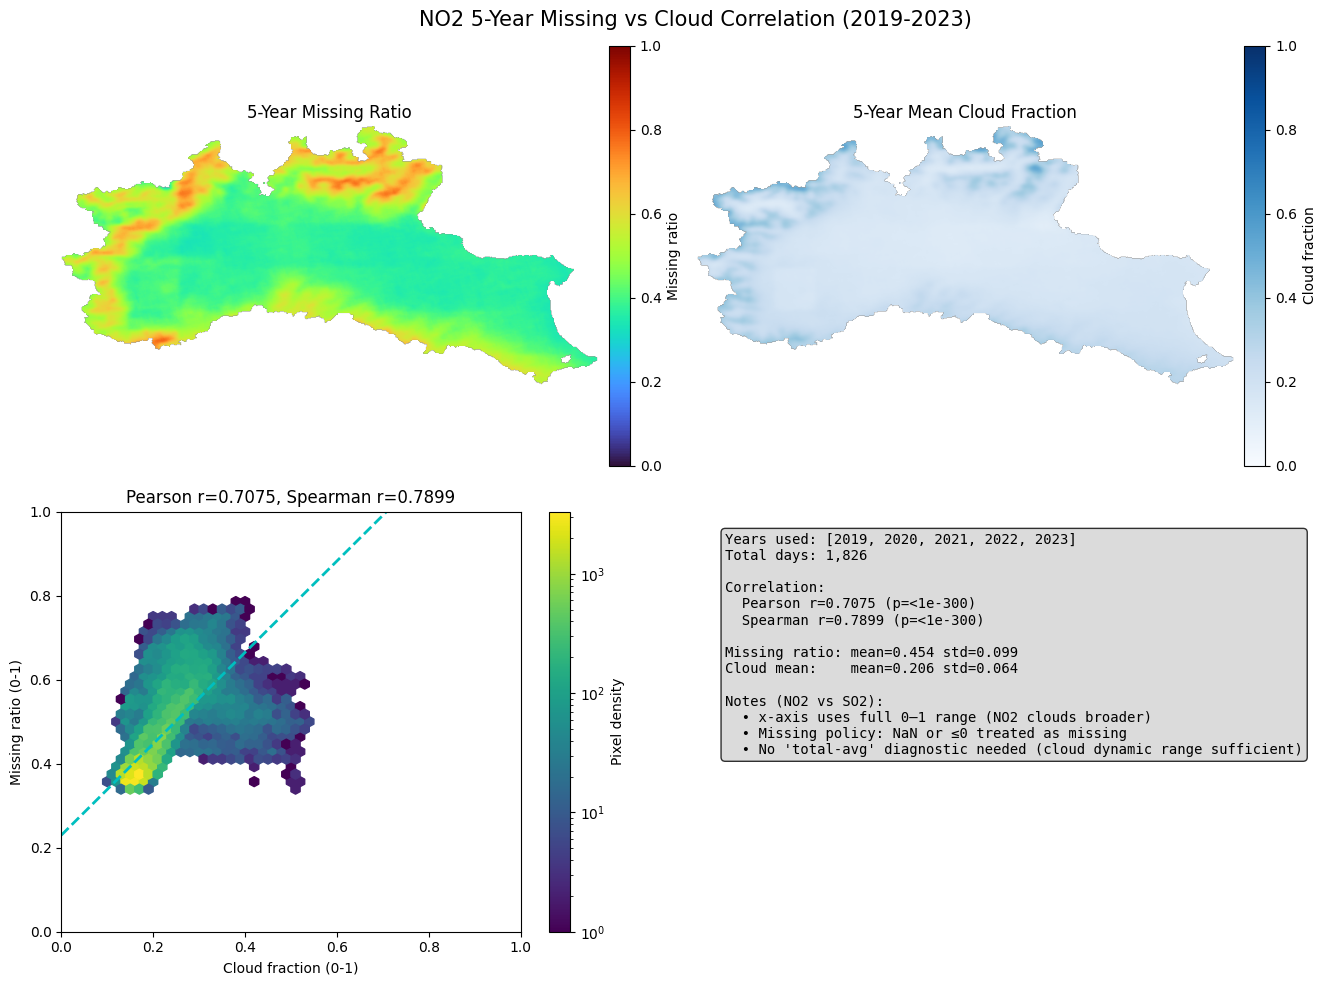

In [13]:
#!/usr/bin/env python3
"""
NO2 5-Year Missing vs Cloud Correlation Analysis

This script computes the 5-year NO2 missing ratio (2019-2023) and the
5-year average cloud fraction aligned per pixel, then evaluates pixel-level
correlations and produces maps and a scatter plot.
"""

import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from scipy.stats import pearsonr, spearmanr


class NO2FiveYearMissingCloudAnalyzer:
    def __init__(self, base_path: str = "/content/drive/MyDrive") -> None:
        self.base_path = base_path
        self.aoi_path = f"{base_path}/AOI/delimitazione_distretto.shp"
        self.no2_template = f"{base_path}/GEE_NO2/NO2_Daily_Multiband_{{}}.tif"
        # We support multiple possible cloud storage layouts (first match wins)
        # 1) Your screenshot: all years in one folder GEE_Cloud_NO2/
        self.cloud_templates = [
            f"{base_path}/GEE_Cloud_NO2/NO2_Cloud_Fraction_Daily_Multiband_{{}}_Uint8.tif",
            f"{base_path}/GEE_Cloud_NO2/NO2_Cloud_Fraction_Daily_Multiband_{{}}_UInt8.tif",
            # 2) Per-year folders (older runs)
            f"{base_path}/GEE_Cloud_NO2_{{}}/NO2_Cloud_Fraction_Daily_Multiband_{{}}_UInt8.tif",
            f"{base_path}/GEE_Cloud_{{}}/NO2_Cloud_Fraction_Daily_Multiband_{{}}_UInt8.tif",
            # 3) Non-UInt8 naming
            f"{base_path}/GEE_Cloud_NO2/NO2_Cloud_Fraction_Daily_Multiband_{{}}.tif",
            f"{base_path}/GEE_Cloud_NO2_{{}}/NO2_Cloud_Fraction_Daily_Multiband_{{}}.tif",
            f"{base_path}/GEE_Cloud_{{}}/NO2_Cloud_Fraction_Daily_Multiband_{{}}.tif",
        ]
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("🌫️ NO2 5-Year Missing vs Cloud Correlation Analyzer")
        print(f"📁 Base path: {self.base_path}")

    def _find_cloud_path(self, year: int) -> str | None:
        for tpl in self.cloud_templates:
            p = tpl.format(year, year)
            if os.path.exists(p):
                return p
        return None

    def _load_aoi_mask(self, transform, out_shape):
        aoi = gpd.read_file(self.aoi_path)
        return geometry_mask([aoi.geometry.union_all()], transform=transform, invert=True, out_shape=out_shape)

    def compute_5year_missing_and_cloud(self):
        print("\n📊 Aggregating 5-year NO2 missing and cloud")
        print("=" * 55)

        missing_sum = None
        cloud_sum = None
        cloud_valid_count_sum = None  # 像素级有效云天数累计（避免被0当成缺测）
        total_days = 0

        ref_transform = None
        ref_shape = None
        ref_bounds = None

        years_used = []

        for year in self.years:
            no2_path = self.no2_template.format(year)
            cloud_path = self._find_cloud_path(year)

            if not os.path.exists(no2_path):
                print(f"   ❌ NO2 {year} not found: {no2_path}")
                continue
            if cloud_path is None:
                print(f"   ❌ Cloud {year} not found in expected folders")
                continue

            try:
                with rasterio.open(no2_path) as no2_src, rasterio.open(cloud_path) as cloud_src:
                    # Read all bands
                    no2_stack = no2_src.read()  # (days, H, W)

                    # 关键修复1：以MaskedArray读入云数据，显式区分缺测（mask/NaN）与真实的0（无云）
                    cloud_stack_ma = cloud_src.read(masked=True)  # (days, H, W) MaskedArray
                    cloud_stack = cloud_stack_ma.filled(np.nan).astype(np.float32)

                    # Align basic metadata from NO2 (assumed identical grid)
                    ref_transform = no2_src.transform
                    ref_shape = (no2_src.height, no2_src.width)
                    ref_bounds = no2_src.bounds

                    # NO2 missing: values <= 0 or NaN considered missing
                    no2_missing = (no2_stack <= 0) | np.isnan(no2_stack)
                    yearly_missing = np.sum(no2_missing, axis=0, dtype=np.float32)

                    # Cloud: convert to fraction (0-1) if 0-255; 此时dtype已是float32
                    # 注意：原始uint8=0..255，缺测现在为NaN
                    if cloud_src.dtypes[0] == 'uint8':
                        cloud_stack = cloud_stack / 255.0

                    # 统计像素级的“有效云天数”（非NaN），并对云量做nan安全求和
                    yearly_cloud_valid = np.sum(~np.isnan(cloud_stack), axis=0, dtype=np.float32)
                    yearly_cloud_sum = np.nansum(cloud_stack, axis=0, dtype=np.float32)

                    if missing_sum is None:
                        missing_sum = yearly_missing
                        cloud_sum = yearly_cloud_sum
                        cloud_valid_count_sum = yearly_cloud_valid
                    else:
                        missing_sum += yearly_missing
                        cloud_sum += yearly_cloud_sum
                        cloud_valid_count_sum += yearly_cloud_valid

                    total_days += no2_stack.shape[0]
                    years_used.append(year)
                    print(f"   ✅ {year}: NO2 days={no2_stack.shape[0]}, Cloud days={cloud_stack.shape[0]}")
            except Exception as e:
                print(f"   ❌ Error {year}: {e}")
                continue

        if missing_sum is None or cloud_sum is None or total_days == 0:
            print("❌ No valid overlapping NO2 and cloud data")
            return None

        missing_ratio = missing_sum / float(total_days)
        # 关键修复2：按像素用“有效云天数”取均值，而不是统一用total_days
        cloud_mean = np.where(cloud_valid_count_sum > 0, cloud_sum / cloud_valid_count_sum, np.nan)

        print(f"✅ Years used: {years_used}")
        print(f"✅ Total days: {total_days}")
        print(f"   Missing ratio range: {np.nanmin(missing_ratio):.3f}-{np.nanmax(missing_ratio):.3f}")
        print(f"   Cloud mean range: {np.nanmin(cloud_mean):.3f}-{np.nanmax(cloud_mean):.3f}")

        return {
            "missing_ratio": missing_ratio,
            "cloud_mean": cloud_mean,
            "transform": ref_transform,
            "shape": ref_shape,
            "bounds": ref_bounds,
            "years_used": years_used,
            "total_days": total_days,
        }

    def correlate_and_visualize(self, agg):
        print("\n📈 Correlating and visualizing")
        print("=" * 35)

        aoi_mask = self._load_aoi_mask(agg["transform"], agg["shape"]) if os.path.exists(self.aoi_path) else np.ones(agg["shape"], dtype=bool)

        miss_aoi = np.where(aoi_mask, agg["missing_ratio"], np.nan)
        cloud_aoi = np.where(aoi_mask, agg["cloud_mean"], np.nan)

        miss_flat = miss_aoi.flatten()
        cloud_flat = cloud_aoi.flatten()
        valid = ~(np.isnan(miss_flat) | np.isnan(cloud_flat))

        miss_valid = miss_flat[valid]
        cloud_valid = cloud_flat[valid]

        if len(miss_valid) < 1000:
            print("❌ Not enough valid pixels for correlation")
            return None

        pr, pp = pearsonr(cloud_valid, miss_valid)
        sr, sp = spearmanr(cloud_valid, miss_valid)

        # 规范化p值显示，避免0.00e+00
        def fmt_p(p, min_exp=300):
            return f"<1e-{min_exp}" if (p == 0 or p < 10**(-min_exp)) else f"{p:.3e}"

        # 同步在终端打印关键统计结果
        print(f"\n✅ Correlation results (pixel-level)")
        print(f"   Pearson r = {pr:.6f}, p = {fmt_p(pp)}")
        print(f"   Spearman r = {sr:.6f}, p = {fmt_p(sp)}")

        # Visualization
        bounds = agg["bounds"]
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle("NO2 5-Year Missing vs Cloud Correlation (2019-2023)", fontsize=15)

        ax1 = axes[0, 0]
        im1 = ax1.imshow(miss_aoi, extent=extent, cmap="turbo", vmin=0, vmax=1)
        ax1.set_title("5-Year Missing Ratio")
        ax1.axis("off")
        ax1.set_aspect('equal')  # 避免变形
        c1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
        c1.set_label("Missing ratio")

        ax2 = axes[0, 1]
        im2 = ax2.imshow(cloud_aoi, extent=extent, cmap="Blues", vmin=0, vmax=1)
        ax2.set_title("5-Year Mean Cloud Fraction")
        ax2.axis("off")
        ax2.set_aspect('equal')  # 避免变形
        c2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
        c2.set_label("Cloud fraction")

        ax3 = axes[1, 0]
        # Sample up to 50k points for plotting
        n = len(miss_valid)
        if n > 50000:
            idx = np.random.choice(n, 50000, replace=False)
            x = cloud_valid[idx]
            y = miss_valid[idx]
        else:
            x = cloud_valid
            y = miss_valid
        # 关键修复3：低密度区域可见性（mincnt=1, bins='log'）并采用更友好的配色
        hb = ax3.hexbin(x, y, gridsize=50, cmap="viridis", extent=(0, 1, 0, 1), mincnt=1, bins='log')
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        xs = np.linspace(0, 1, 100)
        ax3.plot(xs, p(xs), "c--", linewidth=2)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
        ax3.set_xlabel("Cloud fraction (0-1)")
        ax3.set_ylabel("Missing ratio (0-1)")
        ax3.set_title(f"Pearson r={pr:.4f}, Spearman r={sr:.4f}")
        plt.colorbar(hb, ax=ax3, label="Pixel density")

        ax4 = axes[1, 1]
        ax4.axis("off")
        # 与SO2版本保持一致的摘要，并在Notes中说明差异点
        summary = (
            f"Years used: {agg['years_used']}\n"
            f"Total days: {agg['total_days']:,}\n\n"
            f"Correlation:\n  Pearson r={pr:.4f} (p={fmt_p(pp)})\n  Spearman r={sr:.4f} (p={fmt_p(sp)})\n\n"
            f"Missing ratio: mean={np.nanmean(miss_aoi):.3f} std={np.nanstd(miss_aoi):.3f}\n"
            f"Cloud mean:    mean={np.nanmean(cloud_aoi):.3f} std={np.nanstd(cloud_aoi):.3f}\n\n"
            f"Notes (NO2 vs SO2):\n  • x-axis uses full 0–1 range (NO2 clouds broader)\n  • Missing policy: NaN or ≤0 treated as missing\n  • No 'total-avg' diagnostic needed (cloud dynamic range sufficient)"
        )
        ax4.text(0.05, 0.95, summary, transform=ax4.transAxes, fontsize=10, va="top",
                  fontfamily="monospace", bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8))

        plt.tight_layout()
        # 保存到当前工作目录
        out_png = "NO2_5Year_Missing_Cloud_Correlation.png"
        plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white", edgecolor="none")
        print(f"✅ Figure saved: {out_png}")
        plt.show()

        return {
            "pearson_r": pr,
            "pearson_p": pp,
            "spearman_r": sr,
            "spearman_p": sp,
        }


def main():
    print("🚀 NO2 5-Year Missing vs Cloud Correlation")
    print("=" * 60)
    analyzer = NO2FiveYearMissingCloudAnalyzer()
    agg = analyzer.compute_5year_missing_and_cloud()
    if agg is None:
        return
    analyzer.correlate_and_visualize(agg)


if __name__ == "__main__":
    main()




# 7. SO2 5-Year Missing vs Cloud Correlation Analysis

🚀 SO2 5-Year Missing vs Cloud Correlation
🌫️ SO2 5-Year Missing vs Cloud Correlation Analyzer
📁 Base path: /content/drive/MyDrive

📊 Aggregating 5-year SO2 missing and cloud
   ✅ 2019: SO2 days=365, Cloud days=365
   ✅ 2020: SO2 days=366, Cloud days=366
   ✅ 2021: SO2 days=365, Cloud days=365
   ✅ 2022: SO2 days=365, Cloud days=365
   ✅ 2023: SO2 days=365, Cloud days=365
✅ Years used: [2019, 2020, 2021, 2022, 2023]
✅ Total days: 1826
   Missing ratio range: 0.673-1.000
   Cloud mean (valid-avg) range: 0.000-0.048
   Cloud mean (total-avg) range: 0.000-0.048
   Cloud valid ratio mean=1.000

📈 Correlating and visualizing (SO2)

✅ Correlation results (SO2 pixel-level)
   valid-avg:   Pearson r = -0.904779, p = <1e-300; Spearman r = -0.742660, p = <1e-300
   total-avg:   Pearson r = -0.904779, p = <1e-300; Spearman r = -0.742660, p = <1e-300
✅ Figure saved: SO2_5Year_Missing_Cloud_Correlation.png


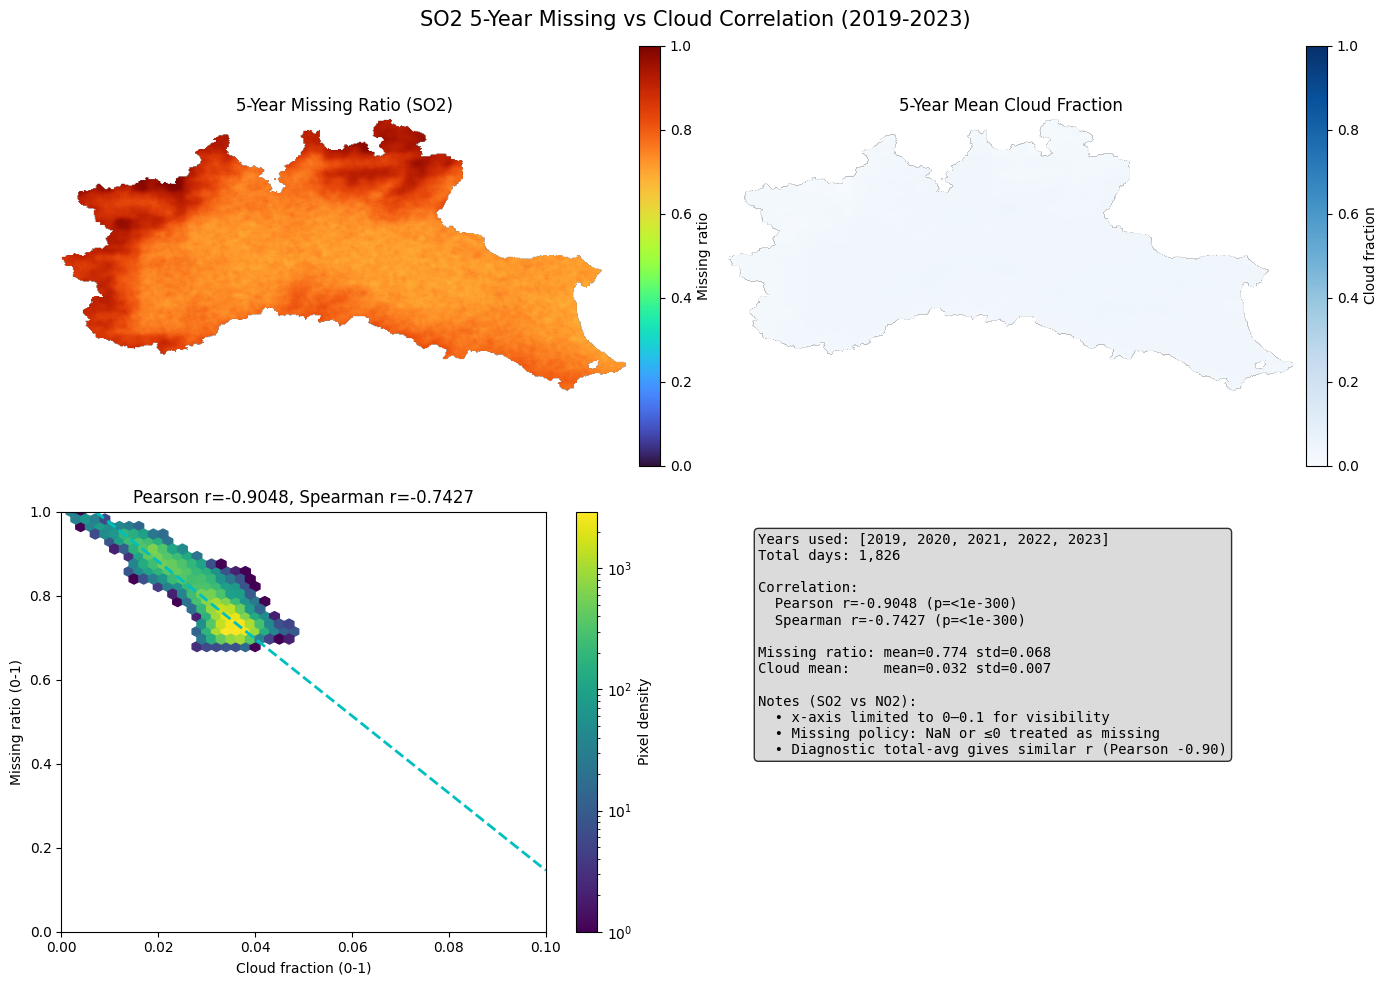

In [14]:
#!/usr/bin/env python3
"""
SO2 5-Year Missing vs Cloud Correlation Analysis

Computes the 5-year SO2 missing ratio (2019-2023) and the 5-year average
cloud fraction aligned per pixel, then evaluates pixel-level correlations
and produces maps plus a scatter plot.
"""

import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from scipy.stats import pearsonr, spearmanr


class SO2FiveYearMissingCloudAnalyzer:
    def __init__(self, base_path: str = "/content/drive/MyDrive") -> None:
        self.base_path = base_path
        self.aoi_path = f"{base_path}/AOI/delimitazione_distretto.shp"
        self.so2_template = f"{base_path}/GEE_SO2/SO2_Daily_Multiband_{{}}.tif"
        # Cloud file templates (first match wins). Prefer folder GEE_Cloud_SO2
        self.cloud_templates = [
            f"{base_path}/GEE_Cloud_SO2/SO2_Cloud_Fraction_Daily_Multiband_{{}}_Uint8.tif",
            f"{base_path}/GEE_Cloud_SO2/SO2_Cloud_Fraction_Daily_Multiband_{{}}_UInt8.tif",
            f"{base_path}/GEE_Cloud_SO2_{{}}/SO2_Cloud_Fraction_Daily_Multiband_{{}}_UInt8.tif",
            f"{base_path}/GEE_Cloud_SO2_{{}}/SO2_Cloud_Fraction_Daily_Multiband_{{}}.tif",
        ]
        self.years = [2019, 2020, 2021, 2022, 2023]

        print("🌫️ SO2 5-Year Missing vs Cloud Correlation Analyzer")
        print(f"📁 Base path: {self.base_path}")

    def _find_cloud_path(self, year: int) -> str | None:
        for tpl in self.cloud_templates:
            p = tpl.format(year, year)
            if os.path.exists(p):
                return p
        return None

    def _load_aoi_mask(self, transform, out_shape):
        aoi = gpd.read_file(self.aoi_path)
        return geometry_mask([aoi.geometry.union_all()], transform=transform, invert=True, out_shape=out_shape)

    def compute_5year_missing_and_cloud(self):
        print("\n📊 Aggregating 5-year SO2 missing and cloud")
        print("=" * 55)

        missing_sum = None
        cloud_sum = None
        cloud_valid_count_sum = None  # 像素级有效云天数累计
        total_days = 0

        ref_transform = None
        ref_shape = None
        ref_bounds = None

        years_used = []

        for year in self.years:
            so2_path = self.so2_template.format(year)
            cloud_path = self._find_cloud_path(year)

            if not os.path.exists(so2_path):
                print(f"   ❌ SO2 {year} not found: {so2_path}")
                continue
            if cloud_path is None:
                print(f"   ❌ Cloud {year} not found in expected folders")
                continue

            try:
                with rasterio.open(so2_path) as so2_src, rasterio.open(cloud_path) as cloud_src:
                    # Read all bands
                    so2_stack = so2_src.read()  # (days, H, W)
                    # 以MaskedArray读取云，保留缺测为NaN
                    cloud_stack_ma = cloud_src.read(masked=True)
                    cloud_stack = cloud_stack_ma.filled(np.nan).astype(np.float32)

                    # Align basic metadata from SO2 (assumed identical grid)
                    ref_transform = so2_src.transform
                    ref_shape = (so2_src.height, so2_src.width)
                    ref_bounds = so2_src.bounds

                    # SO2 missing: values <= 0 or NaN considered missing
                    so2_missing = (so2_stack <= 0) | np.isnan(so2_stack)
                    yearly_missing = np.sum(so2_missing, axis=0, dtype=np.float32)

                    # Cloud: 若为uint8则转为0-1；缺测已是NaN
                    if cloud_src.dtypes[0] == 'uint8':
                        cloud_stack = cloud_stack / 255.0
                    # 按像素统计有效天数并做nan安全求和
                    yearly_cloud_valid = np.sum(~np.isnan(cloud_stack), axis=0, dtype=np.float32)
                    yearly_cloud_sum = np.nansum(cloud_stack, axis=0, dtype=np.float32)

                    if missing_sum is None:
                        missing_sum = yearly_missing
                        cloud_sum = yearly_cloud_sum
                        cloud_valid_count_sum = yearly_cloud_valid
                    else:
                        missing_sum += yearly_missing
                        cloud_sum += yearly_cloud_sum
                        cloud_valid_count_sum += yearly_cloud_valid

                    total_days += so2_stack.shape[0]
                    years_used.append(year)
                    print(f"   ✅ {year}: SO2 days={so2_stack.shape[0]}, Cloud days={cloud_stack.shape[0]}")
            except Exception as e:
                print(f"   ❌ Error {year}: {e}")
                continue

        if missing_sum is None or cloud_sum is None or total_days == 0:
            print("❌ No valid overlapping SO2 and cloud data")
            return None

        missing_ratio = missing_sum / float(total_days)
        # 用有效云天数做均值，避免把真实0当作缺测
        cloud_mean = np.where(cloud_valid_count_sum > 0, cloud_sum / cloud_valid_count_sum, np.nan)
        # 对照口径：按总天数取平均（缺测按0处理的效果）
        cloud_mean_total = cloud_sum / float(total_days)
        # 云数据有效覆盖比例
        cloud_valid_ratio = cloud_valid_count_sum / float(total_days)

        print(f"✅ Years used: {years_used}")
        print(f"✅ Total days: {total_days}")
        print(f"   Missing ratio range: {np.nanmin(missing_ratio):.3f}-{np.nanmax(missing_ratio):.3f}")
        print(f"   Cloud mean (valid-avg) range: {np.nanmin(cloud_mean):.3f}-{np.nanmax(cloud_mean):.3f}")
        print(f"   Cloud mean (total-avg) range: {np.nanmin(cloud_mean_total):.3f}-{np.nanmax(cloud_mean_total):.3f}")
        print(f"   Cloud valid ratio mean={np.nanmean(cloud_valid_ratio):.3f}")

        return {
            "missing_ratio": missing_ratio,
            "cloud_mean": cloud_mean,
            "cloud_mean_total": cloud_mean_total,
            "cloud_valid_ratio": cloud_valid_ratio,
            "transform": ref_transform,
            "shape": ref_shape,
            "bounds": ref_bounds,
            "years_used": years_used,
            "total_days": total_days,
        }

    def correlate_and_visualize(self, agg):
        print("\n📈 Correlating and visualizing (SO2)")
        print("=" * 40)

        aoi_mask = self._load_aoi_mask(agg["transform"], agg["shape"]) if os.path.exists(self.aoi_path) else np.ones(agg["shape"], dtype=bool)

        miss_aoi = np.where(aoi_mask, agg["missing_ratio"], np.nan)
        cloud_aoi = np.where(aoi_mask, agg["cloud_mean"], np.nan)
        cloud_total_aoi = np.where(aoi_mask, agg["cloud_mean_total"], np.nan)
        cloud_valid_ratio_aoi = np.where(aoi_mask, agg["cloud_valid_ratio"], np.nan)

        miss_flat = miss_aoi.flatten()
        cloud_flat = cloud_aoi.flatten()
        valid = ~(np.isnan(miss_flat) | np.isnan(cloud_flat))

        miss_valid = miss_flat[valid]
        cloud_valid = cloud_flat[valid]

        if len(miss_valid) < 1000:
            print("❌ Not enough valid pixels for correlation")
            return None

        pr, pp = pearsonr(cloud_valid, miss_valid)
        sr, sp = spearmanr(cloud_valid, miss_valid)
        # 对照：按总天数均值的相关性
        cloud_total_flat = cloud_total_aoi.flatten()[valid]
        pr_t, pp_t = pearsonr(cloud_total_flat, miss_valid)
        sr_t, sp_t = spearmanr(cloud_total_flat, miss_valid)

        # 规范化p值显示，避免0.00e+00
        def fmt_p(p, min_exp=300):
            return f"<1e-{min_exp}" if (p == 0 or p < 10**(-min_exp)) else f"{p:.3e}"

        # Visualization
        bounds = agg["bounds"]
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle("SO2 5-Year Missing vs Cloud Correlation (2019-2023)", fontsize=15)

        ax1 = axes[0, 0]
        im1 = ax1.imshow(miss_aoi, extent=extent, cmap="turbo", vmin=0, vmax=1)
        ax1.set_title("5-Year Missing Ratio (SO2)")
        ax1.axis("off")
        ax1.set_aspect('equal')
        c1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
        c1.set_label("Missing ratio")

        ax2 = axes[0, 1]
        im2 = ax2.imshow(cloud_aoi, extent=extent, cmap="Blues", vmin=0, vmax=1)
        # 与NO2一致的标题命名
        ax2.set_title("5-Year Mean Cloud Fraction")
        ax2.axis("off")
        ax2.set_aspect('equal')
        c2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
        c2.set_label("Cloud fraction")

        ax3 = axes[1, 0]
        # Sample for plotting
        n = len(miss_valid)
        if n > 50000:
            idx = np.random.choice(n, 50000, replace=False)
            x = cloud_valid[idx]
            y = miss_valid[idx]
        else:
            x = cloud_valid
            y = miss_valid
        # 低密度区域可见性提升；SO2云量很低，横轴限定到0–0.1
        hb = ax3.hexbin(x, y, gridsize=50, cmap="viridis", extent=(0, 0.1, 0, 1), mincnt=1, bins='log')
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        xs = np.linspace(0, 0.1, 100)
        ax3.plot(xs, p(xs), "c--", linewidth=2)
        ax3.set_xlim(0, 0.1)
        ax3.set_ylim(0, 1)
        ax3.set_xlabel("Cloud fraction (0-1)")
        ax3.set_ylabel("Missing ratio (0-1)")
        ax3.set_title(f"Pearson r={pr:.4f}, Spearman r={sr:.4f}")
        plt.colorbar(hb, ax=ax3, label="Pixel density")

        ax4 = axes[1, 1]
        ax4.axis("off")
        # 与NO2一致的摘要字段，另加“Differences”说明
        summary = (
            f"Years used: {agg['years_used']}\n"
            f"Total days: {agg['total_days']:,}\n\n"
            f"Correlation:\n  Pearson r={pr:.4f} (p={fmt_p(pp)})\n  Spearman r={sr:.4f} (p={fmt_p(sp)})\n\n"
            f"Missing ratio: mean={np.nanmean(miss_aoi):.3f} std={np.nanstd(miss_aoi):.3f}\n"
            f"Cloud mean:    mean={np.nanmean(cloud_aoi):.3f} std={np.nanstd(cloud_aoi):.3f}\n\n"
            f"Notes (SO2 vs NO2):\n  • x-axis limited to 0–0.1 for visibility\n  • Missing policy: NaN or ≤0 treated as missing\n  • Diagnostic total-avg gives similar r (Pearson {pr_t:.2f})"
        )
        ax4.text(0.05, 0.95, summary, transform=ax4.transAxes, fontsize=10, va="top",
                  fontfamily="monospace", bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8))

        # 打印相关性到终端
        print(f"\n✅ Correlation results (SO2 pixel-level)")
        print(f"   valid-avg:   Pearson r = {pr:.6f}, p = {fmt_p(pp)}; Spearman r = {sr:.6f}, p = {fmt_p(sp)}")
        print(f"   total-avg:   Pearson r = {pr_t:.6f}, p = {fmt_p(pp_t)}; Spearman r = {sr_t:.6f}, p = {fmt_p(sp_t)}")

        plt.tight_layout()
        out_png = "SO2_5Year_Missing_Cloud_Correlation.png"
        plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white", edgecolor="none")
        print(f"✅ Figure saved: {out_png}")
        plt.show()

        return {
            "pearson_r": pr,
            "pearson_p": pp,
            "spearman_r": sr,
            "spearman_p": sp,
        }


def main():
    print("🚀 SO2 5-Year Missing vs Cloud Correlation")
    print("=" * 60)
    analyzer = SO2FiveYearMissingCloudAnalyzer()
    agg = analyzer.compute_5year_missing_and_cloud()
    if agg is None:
        return
    analyzer.correlate_and_visualize(agg)


if __name__ == "__main__":
    main()


